# How can the mediating factors predict a company’s compliance with the requirements of the EU AI Act?

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import MultiComparison

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import linear_model

from statsmodels.stats.multicomp import pairwise_tukeyhsd

import os

In [ ]:
from pymer4.models import Lmer

# Table of Contents
1. [CLEANING](#section-0.1)

2. [ANALYSIS](#section-0)

3. [MODEL](#section-7)

# CLEANING <a id='section-0.1'></a>

In [3]:
#This allows me to view the full data inside of a datframe when i call it
pd.set_option('display.max_columns', None)

In [5]:
#I change my directory and load the AI survey results into a new dataframe
#os.chdir("/Users/melvingatherer/Downloads/CleanedCategories311023")
df = pd.read_excel("AIsurvey.xlsx")
df.head()

,StartDate,EndDate,Status,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,DistributionChannel,UserLanguage,Q132,Q1,Q149,Q5,Q5_4_TEXT,Q6,Q9,Q9_5_TEXT,Q7,Q10,Q22_NPS_GROUP,Q22,Q23_NPS_GROUP,Q23,Q16_NPS_GROUP,Q16,Q17,Q18_NPS_GROUP,Q18,Q19,Q20,Q25_NPS_GROUP,Q25,Q28,Q29,Q80,Q32,Q33,Q79,Q35,Q35_2_TEXT,Q36,Q37,Q78,Q39,Q39_5_TEXT,Q77,Q41,Q42,Q42_5_TEXT,Q75,Q76,Q45,Q46,Q47,Q48,Q48_5_TEXT,Q74,Q50,Q51,Q73,Q53,Q53_5_TEXT,Q71,Q55,Q70,Q58,Q69,Q68,Q61,Q61_5_TEXT,Q62,Q63,Q67,Q66,Q82,Q83,Q83_5_TEXT,Q84,Q85,Q85_5_TEXT,Q86,Q87,Q88,Q89,Q90,Q91,Q91_6_TEXT,Q93,Q94,Q95,Q96,Q97,Q98,Q100,Q99,Q102,Q103,Q103_4_TEXT,Q106,Q104,Q105,Q108,Q107,Q109,Q109_4_TEXT,Q110,Q111,Q118,Q119,Q120,Q121,Q122,Q123,Q124,Q125,Q126,Q127,Q128,Q128_6_TEXT,Q129,Q8
0,2023-05-11 07:08:57,2023-05-11 07:39:37,0,100,1839,1,2023-05-11 07:39:38.143,R_3QJMMTA24YX2yVg,anonymous,EN,NaN,Company 1,person 1,"2,3",NaN,1,1,NaN,1,2,1,2,1,0,1,5,3,3,9,3,2,1,6,2.0,4.0,5.0,2.0,1.0,5.0,2.0,We mostly use encrypted data but in a certain ...,1.0,3.0,5.0,3,NaN,4.0,4.0,5,No departments,5.0,5.0,2.0,2.0,3.0,3,NaN,2.0,1.0,3.0,3.0,3,NaN,4.0,3.0,4.0,2.0,3.0,3.0,"3,4",NaN,1.0,1.0,2.0,4.0,4.0,4.0,NaN,3.0,3,NaN,2.0,3.0,1.0,3.0,4.0,"3,4,5,6",Model Oversight Committee,1.0,5.0,3.0,4.0,3.0,1.0,2.0,5.0,1.0,1,NaN,1.0,4.0,1.0,1.0,1.0,1,NaN,5.0,5.0,1.0,3,1.0,1.0,5.0,1.0,1.0,1.0,4.0,1.0,3,NaN,4.0,NaN
1,2023-05-11 09:06:25,2023-05-11 09:33:34,0,100,1629,1,2023-05-11 09:33:36.779,R_31hoIANMOQfACE2,anonymous,EN,NaN,Company 2,person 2,"1,3",NaN,1,5,"finance, healthcare",1,2,1,0,1,0,1,5,3,2,8,2,3,1,0,2.0,2.0,4.0,1.0,1.0,4.0,2.0,bad encryption of customer information,3.0,3.0,4.0,"3,4",NaN,4.0,4.0,6,NaN,5.0,5.0,1.0,4.0,4.0,5,management,1.0,1.0,2.0,4.0,"1,3,5",management,4.0,1.0,4.0,2.0,2.0,2.0,"3,4",NaN,1.0,1.0,5.0,1.0,2.0,4.0,NaN,1.0,"3,4,5",management,2.0,4.0,3.0,6.0,1.0,"1,4,6",management,1.0,4.0,4.0,4.0,1.0,1.0,2.0,5.0,1.0,"1,2",NaN,1.0,4.0,1.0,2.0,2.0,1,NaN,5.0,3.0,1.0,"3,4",2.0,4.0,1.0,1.0,1.0,1.0,3.0,2.0,"1,3,4,6",management,4.0,NaN
2,2023-05-22 04:44:00,2023-05-22 05:05:05,0,100,1264,1,2023-05-22 05:05:07.760,R_e9XbZplwgOLxZbX,anonymous,EN,NaN,Company 3,person 3,1,NaN,1,5,Smart Buildings,1,3,1,3,1,2,1,3,3,2,7,2,3,1,1,2.0,4.0,5.0,4.0,4.0,4.0,1.0,NaN,4.0,1.0,3.0,3,NaN,3.0,1.0,3,NaN,5.0,5.0,3.0,4.0,4.0,3,NaN,1.0,4.0,4.0,1.0,3,NaN,1.0,4.0,5.0,3.0,2.0,1.0,3,NaN,1.0,1.0,2.0,2.0,5.0,4.0,NaN,3.0,3,NaN,2.0,2.0,1.0,6.0,1.0,1,NaN,3.0,4.0,4.0,4.0,1.0,2.0,2.0,4.0,4.0,2,NaN,2.0,1.0,1.0,1.0,2.0,1,NaN,3.0,3.0,1.0,"3,4",3.0,3.0,3.0,1.0,1.0,1.0,2.0,2.0,"1,2,3,4",NaN,5.0,NaN
3,2023-05-22 09:20:53,2023-05-22 10:07:53,0,100,2820,1,2023-05-22 10:07:55.874,R_1KwOOSISIYqCkoY,anonymous,EN,NaN,Company 4,person 4,4,Operation Researcher,4,5,Food Industry,1,4,1,1,1,4,2,7,3,2,7,1,3,1,5,2.0,2.0,5.0,2.0,2.0,4.0,2.0,We operate with a lot of partial information.,1.0,5.0,5.0,"3,4,5",Management,5.0,1.0,"3,4,5",NaN,5.0,5.0,1.0,1.0,1.0,5,Everyone in company,4.0,2.0,1.0,3.0,5,Everyone for which this is relevant,4.0,2.0,5.0,2.0,2.0,3.0,"3,4",NaN,1.0,2.0,5.0,3.0,5.0,4.0,NaN,3.0,5,NaN,1.0,2.0,3.0,6.0,2.0,"3,4,5,6",Managers,2.0,4.0,3.0,3.0,3.0,1.0,2.0,5.0,4.0,"2,4",Business/marketing,2.0,4.0,2.0,1.0,3.0,"1,4",Create new model,5.0,4.0,1.0,"3,4",3.0,3.0,3.0,1.0,1.0,2.0,4.0,2.0,6,Everyone for which is relevant.,5.0,NaN
4,2023-05-23 03:04:36,2023-05-23 03:31:43,0,100,1626,1,2023-05-23 03:31:45.618,R_24H0svxSkVTsGZQ,anonymous,EN,NaN,Company 5,person 5,4,General Counsel,2,5,IT/Logistics,1,1,1,5,2,8,1,4,2,2,7,2,3,1,5,2.0,2.0,5.0,2.0,2.0,5.0,2.0,availability of data due to admenments in agre...,1.0,5.0,5.0,"1,5","product owners, management & board of directors",5.0,1.0,"1,3,5","IT developers, product owners etc.",4.0,4.0,1.0,1.0,2.0,"1,3,5",management & board,5.0,3.0,3.0,4.0,"1,3,5",management & board,5.0,1.0,5.0,1.0,5.0,5.0,"1,3,4,5",management,1.0,2.0,4.0,5.0,2.0,1.0,NaN,2.0,"1,3,5",management & board & external stakeholders (cu...,1.0,4.0,1.0,1.0,4.0,"1,3,4,6","management, board & shareholders",2.0,4.0,1.0,1.0,5.0,2.0,2.0,5.0,1.0,"1,2",NaN,2.0,5.0,1.

In [6]:
df = df[df['Progress'] == 100]

In [7]:
#Change the values of 2 (No) to 0 to fit the scale
df[['Q106', 'Q86']] = df[['Q106', 'Q86']].replace(2, 0)

In [8]:
#Reverse the given answers to fit the answer scale of the other questions in this category (A or F)
df['Q104'] = df['Q104'].replace({'5': '1', '4': '2', '2': '4', '1': '5'}, regex=True)
df['Q45'] = df['Q45'].replace({'1': '3', '3': '1'}, regex=True) 
df['Q50'] = df['Q50'].replace({'4': '1', '3': '2', '2' : '3', '1' : '4'}, regex=True) 

#Switch the 2 and the 1 in the answer model to fit the answer scale
df['Q100'] = df['Q100'].replace({'2': '1', '1': '2'}, regex=True)
df['Q28'] = df['Q28'].replace({'2': '1', '1': '2'}, regex=True)
df['Q63'] = df['Q63'].replace({'2': '1', '1': '0'}, regex=True)

#Change the order of the answers to fit the answer scale
df['Q100'] = df['Q100'].replace({'1': '3', '3': '2', '2': '1'}, regex=True)
df['Q35'] = df['Q35'].replace({'2': '1', '3': '2', '2': '3'}, regex=True)
df['Q37'] = df['Q37'].replace({'5': '1', '1': '2', '2': '3', '3': '4', '4' : '5'}, regex=True)
df['Q62'] = df['Q62'].replace({'1': '3', '3': '2', '2': '1'}, regex=True)

In [9]:
#Removing the commas from the answers and calculating the value between 0 and 1 of the given answer(s)
df['Q103'] = df['Q103'].str.replace(',','')
df['Q103'] = df['Q103'].apply(lambda x: 1 - len(str(x)) * 0.25 if not pd.isna(x) else x)
df['Q119'] = df['Q119'].str.replace(',','')
df['Q119'] = df['Q119'].apply(lambda x: 1 - len(str(x)) * 0.25 if not pd.isna(x) else x)

In [10]:
df['Q109'] = df['Q109'].str.replace(',','')
df['Q109'] = df['Q109'].apply(lambda x: 1 if '3' in str(x) else (1 - len(str(x)) * 1/3 if not pd.isna(x) else x))

In [11]:
df[['Q39', 'Q53', 'Q61', 'Q85']] = df[['Q39', 'Q53', 'Q61', 'Q85']].apply(lambda x: x.str.replace(',', '') if x.dtype == 'object' else x)
df[['Q39', 'Q53', 'Q61', 'Q85']] = df[['Q39', 'Q53', 'Q61', 'Q85']].applymap(lambda x: 1 - len(str(x)) * 0.20 if not pd.isna(x) else x)

In [12]:
df[['Q128', 'Q42', 'Q48']] = df[['Q128', 'Q42', 'Q48']].apply(lambda x: x.str.replace(',', '') if x.dtype == 'object' else x)
df[['Q128', 'Q42', 'Q48']] = df[['Q128', 'Q42', 'Q48']].applymap(lambda x: 1 if '5' in str(x) else (1 - len(str(x)) * 0.2 if not pd.isna(x) else x))

In [13]:
df['Q91'] = df['Q91'].apply(lambda x: x.replace(',', '') if isinstance(x, str) else x)
df['Q91'] = df['Q91'].apply(lambda x: 1 - len(str(x)) * 1/6 if not pd.isna(x) else x)

In [14]:
#I put the Q2 excel file into a new dataframe. Q2 contains information about each question (Category, Activity or Feeling, Max answer score)
df2 = pd.read_excel("q2.xlsx")
df2['F/A'] = df2['F/A'].str.strip()
df2['Category'] = df2['Category'].str.strip()
df2.head()

,Question_number,Category,F/A,Answer,MaxScore,Question
0,Q1,Information,NaN,No range (Company 1... Company 15),NaN,What is the name of your organization?
1,Q10,Information,NaN,"1, 4 ( 1= less than 1 year, 2= 1-3 years, 3 = ...",NaN,How long has your organization been using AI/ML?
2,Q100,User Application,A,"1,4 (1= once per project, 2= multiple tests pe...",4.0,How often does your organization perform user ...
3,Q102,Model monitoring,A,"1,5( 1= an entire team, 2= one full time emplo...",5.0,How many professionals in your organization ar...
4,Q103,Model monitoring,A,"1,4 (1= degree in that field, 2= technical bac...",4.0,What type of qualifications do people who moni...


In [15]:
#I drop the NaN values from the 'MaxScore' column for future calculations
filtered_df = df2.dropna(subset=['MaxScore'])

#I create a dictionary containing the Question number with the corresponding maximum score to standardise the survey results
dictionary = filtered_df.set_index('Question_number')['MaxScore'].to_dict()

In [16]:
#I divide the scores in the dataframe with the maximum score.
for i in df:
    if i in dictionary:
        if isinstance(dictionary[i], float) and pd.api.types.is_numeric_dtype(df[i]):
            df[i] = df[i] / dictionary[i]

In [17]:
#Creating lists containing the question numbers of Activity and Feeling questions
aQuestions = df2[df2['F/A'] == 'A']['Question_number'].tolist()
fQuestions = df2[df2['F/A'] == 'F']['Question_number'].tolist()

#Creating lists containing the question numbers of each category and removing the NaN values from the information questions
informationQuestions = df2[df2['Category'] == 'Information']['Question_number']
informationQuestions = informationQuestions.dropna().tolist()
dataModelQuestions = df2[df2['Category'] == 'Data & model']['Question_number'].tolist()
modelMonitoringQuestions = df2[df2['Category'] == 'Model monitoring']['Question_number'].tolist()
riskManagementQuestions = df2[df2['Category'] == 'Risk management']['Question_number'].tolist()
technicalDocumentationQuestions = df2[df2['Category'] == 'Technical documentation']['Question_number'].tolist()
userApplicationQuestions = df2[df2['Category'] == 'User Application']['Question_number'].tolist()

In [18]:
#Putting a '0' or a '1' into the null values (0 for the Feeling questions and 1 for the Activity questions)
df[aQuestions] = df[aQuestions].fillna(1)
df[fQuestions] = df[fQuestions].fillna(0)

In [19]:
df[aQuestions] = 1 - df[aQuestions]

In [20]:
#Creating new dataframes containing the questions per category (Including the information questions in each new dataframe to analyse the factors of the companies)
df_DataModel = df[dataModelQuestions]
df_ModelMonitoring = df[modelMonitoringQuestions]
df_RiskManagement = df[riskManagementQuestions]
df_TechnicalDocumentation = df[technicalDocumentationQuestions]
df_UserApplication = df[userApplicationQuestions]

# List of information columns to include in each DataFrame
informationQ = df[informationQuestions]

# Add the information columns to each new DataFrame
df_DataModel = pd.concat([df_DataModel, informationQ], axis=1)
df_ModelMonitoring = pd.concat([df_ModelMonitoring, informationQ], axis=1)
df_RiskManagement = pd.concat([df_RiskManagement, informationQ], axis=1)
df_TechnicalDocumentation = pd.concat([df_TechnicalDocumentation, informationQ], axis=1)
df_UserApplication = pd.concat([df_UserApplication, informationQ], axis=1)

In [21]:
#Defining the function to calculate the A(ctivity) and the F(eeling) score 
def calculate_A_and_F_scores(df, aQuestions, fQuestions):
    df = df.copy()  # Create a copy of the DataFrame
    
    existing_a_questions = [i for i in aQuestions if i in df.columns]
    existing_f_questions = [i for i in fQuestions if i in df.columns]
    
    if existing_a_questions:
        df['A_score'] = df[existing_a_questions].mean(axis=1, numeric_only=True)
    
    if existing_f_questions:
        df['F_score'] = df[existing_f_questions].mean(axis=1, numeric_only=True)
    
    return df
#Defining the function to calculate the exaggeration score
def calculate_exaggeration_score(row):
    if row['F_score'] == 0:
        return 0  # Handle the case where 'F_score' is zero to prevent division by zero
    return row['A_score'] / row['F_score']

In [22]:
#I apply the functions to calculate the A score, F score and the exaggeration score per question category
df_DataModel = calculate_A_and_F_scores(df_DataModel, aQuestions, fQuestions)
df_DataModel['Exaggeration_Score'] = df_DataModel.apply(calculate_exaggeration_score, axis=1)

df_ModelMonitoring = calculate_A_and_F_scores(df_ModelMonitoring, aQuestions, fQuestions)
df_ModelMonitoring['Exaggeration_Score'] = df_ModelMonitoring.apply(calculate_exaggeration_score, axis=1)

df_RiskManagement = calculate_A_and_F_scores(df_RiskManagement, aQuestions, fQuestions)
df_RiskManagement['Exaggeration_Score'] = df_RiskManagement.apply(calculate_exaggeration_score, axis=1)

df_TechnicalDocumentation = calculate_A_and_F_scores(df_TechnicalDocumentation, aQuestions, fQuestions)
df_TechnicalDocumentation['Exaggeration_Score'] = df_TechnicalDocumentation.apply(calculate_exaggeration_score, axis=1)

df_UserApplication = calculate_A_and_F_scores(df_UserApplication, aQuestions, fQuestions)
df_UserApplication['Exaggeration_Score'] = df_UserApplication.apply(calculate_exaggeration_score, axis=1)

In [23]:
#Here the weights are applied, adding the a score and the f score per category to the dataframe.
df_DataModel['A_score'] = df_DataModel['A_score'] * 1.0
df_DataModel['F_score'] = df_DataModel['F_score'] * 1.0

df_ModelMonitoring['A_score'] = df_ModelMonitoring['A_score'] * 1.1
df_ModelMonitoring['F_score'] = df_ModelMonitoring['F_score'] * 1.1

df_RiskManagement['A_score'] = df_RiskManagement['A_score'] * 1.3
df_RiskManagement['F_score'] = df_RiskManagement['F_score'] * 1.3

df_TechnicalDocumentation['A_score'] = df_TechnicalDocumentation['A_score'] * 0.8
df_TechnicalDocumentation['F_score'] = df_TechnicalDocumentation['F_score'] * 0.8

df_UserApplication['A_score'] = df_UserApplication['A_score'] * 1.0
df_UserApplication['F_score'] = df_UserApplication['F_score'] * 1.0

In [24]:
# Creating the lists of DataFrames for 'A_score' and 'F_score in different categories to sum them up as total A and F score
category_A_scores = [df_DataModel['A_score'], df_ModelMonitoring['A_score'], df_RiskManagement['A_score'], df_TechnicalDocumentation['A_score'], df_UserApplication['A_score']]
category_F_scores = [df_DataModel['F_score'], df_ModelMonitoring['F_score'], df_RiskManagement['F_score'], df_TechnicalDocumentation['F_score'], df_UserApplication['F_score']]

# Concatenate the DataFrames along columns
combined_A_scores = pd.concat(category_A_scores, axis=1)
combined_F_scores = pd.concat(category_F_scores, axis=1)

# Sum the 'A_score' values across categories for each row (assuming each row represents a company or respondent)
df['A_score'] = (combined_A_scores.sum(axis=1) / 5)
df['F_score'] = (combined_F_scores.sum(axis=1) / 5)

In [25]:
#Calculating the Exaggeration score by applying the 'calculate_exaggeration_score' function.
df['Exaggeration_Score'] = df.apply(calculate_exaggeration_score, axis=1)

In [26]:
df

,StartDate,EndDate,Status,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,DistributionChannel,UserLanguage,Q132,Q1,Q149,Q5,Q5_4_TEXT,Q6,Q9,Q9_5_TEXT,Q7,Q10,Q22_NPS_GROUP,Q22,Q23_NPS_GROUP,Q23,Q16_NPS_GROUP,Q16,Q17,Q18_NPS_GROUP,Q18,Q19,Q20,Q25_NPS_GROUP,Q25,Q28,Q29,Q80,Q32,Q33,Q79,Q35,Q35_2_TEXT,Q36,Q37,Q78,Q39,Q39_5_TEXT,Q77,Q41,Q42,Q42_5_TEXT,Q75,Q76,Q45,Q46,Q47,Q48,Q48_5_TEXT,Q74,Q50,Q51,Q73,Q53,Q53_5_TEXT,Q71,Q55,Q70,Q58,Q69,Q68,Q61,Q61_5_TEXT,Q62,Q63,Q67,Q66,Q82,Q83,Q83_5_TEXT,Q84,Q85,Q85_5_TEXT,Q86,Q87,Q88,Q89,Q90,Q91,Q91_6_TEXT,Q93,Q94,Q95,Q96,Q97,Q98,Q100,Q99,Q102,Q103,Q103_4_TEXT,Q106,Q104,Q105,Q108,Q107,Q109,Q109_4_TEXT,Q110,Q111,Q118,Q119,Q120,Q121,Q122,Q123,Q124,Q125,Q126,Q127,Q128,Q128_6_TEXT,Q129,Q8,A_score,F_score,Exaggeration_Score
0,2023-05-11 07:08:57,2023-05-11 07:39:37,0,100,1839,1,2023-05-11 07:39:38.143,R_3QJMMTA24YX2yVg,anonymous,EN,NaN,Company 1,person 1,"2,3",NaN,1,1,NaN,1,2,1,2,1,0,1,5,3,3,9,3,2,1,6,0.6,0.00,1.0,0.50,0.75,1.0,0.333333,We mostly use encrypted data but in a certain ...,0.75,0.4,1.0,0.84,NaN,0.8,0.00,0.833333,No departments,1.0,1.0,0.666667,0.50,0.25,0.866667,NaN,0.4,0.75,0.25,0.6,0.84,NaN,0.8,0.25,0.8,0.50,0.6,0.6,0.88,NaN,0.333333,0.5,0.4,0.8,0.333333,0.2,NaN,0.25,0.84,NaN,0.0,0.6,0.666667,0.500000,0.8,0.944444,Model Oversight Committee,0.75,1.0,0.25,0.00,0.6,0.75,0.50,1.0,0.8,0.8125,NaN,0.5,0.2,0.75,0.75,0.75,0.833333,NaN,1.0,1.0,0.666667,0.8125,0.333333,0.75,1.0,0.75,0.75,0.8,0.8,0.75,0.866667,NaN,0.8,NaN,0.646000,0.794552,0.813036
1,2023-05-11 09:06:25,2023-05-11 09:33:34,0,100,1629,1,2023-05-11 09:33:36.779,R_31hoIANMOQfACE2,anonymous,EN,NaN,Company 2,person 2,"1,3",NaN,1,5,"finance, healthcare",1,2,1,0,1,0,1,5,3,2,8,2,3,1,0,0.6,0.50,0.8,0.75,0.75,0.8,0.333333,bad encryption of customer information,0.25,0.4,0.8,0.88,NaN,0.8,0.00,0.866667,NaN,1.0,1.0,0.333333,0.00,0.00,0.833333,management,0.2,0.75,0.50,0.8,0.92,management,0.8,0.75,0.8,0.50,0.4,0.4,0.88,NaN,0.333333,0.5,1.0,0.2,0.666667,0.2,NaN,0.75,0.92,management,0.0,0.8,0.000000,0.000000,0.2,0.916667,management,0.75,0.8,0.00,0.00,0.2,0.75,0.50,1.0,0.8,0.8750,NaN,0.5,0.2,0.75,0.50,0.50,0.833333,NaN,1.0,0.6,0.666667,0.8750,0.666667,0.00,0.2,0.75,0.75,0.8,0.6,0.50,0.966667,management,0.8,NaN,0.595058,0.650694,0.914498
2,2023-05-22 04:44:00,2023-05-22 05:05:05,0,100,1264,1,2023-05-22 05:05:07.760,R_e9XbZplwgOLxZbX,anonymous,EN,NaN,Company 3,person 3,1,NaN,1,5,Smart Buildings,1,3,1,3,1,2,1,3,3,2,7,2,3,1,1,0.6,0.00,1.0,0.00,0.00,0.8,0.666667,NaN,0.00,0.8,0.6,0.84,NaN,0.6,0.75,0.866667,NaN,1.0,1.0,1.000000,0.00,0.00,0.866667,NaN,0.2,0.00,0.00,0.2,0.84,NaN,0.2,0.00,1.0,0.25,0.4,0.2,0.84,NaN,0.333333,0.5,0.4,0.4,0.166667,0.2,NaN,0.25,0.84,NaN,0.0,0.4,0.666667,0.000000,0.2,0.861111,NaN,0.25,0.8,0.00,0.00,0.2,0.50,0.50,0.8,0.2,0.8125,NaN,0.0,0.8,0.75,0.75,0.50,0.833333,NaN,0.6,0.6,0.666667,0.8750,1.000000,0.25,0.6,0.75,0.75,0.8,0.4,0.50,0.966667,NaN,1.0,NaN,0.534589,0.591552,0.903705
3,2023-05-22 09:20:53,2023-05-22 10:07:53,0,100,2820,1,2023-05-22 10:07:55.874,R_1KwOOSISIYqCkoY,anonymous,EN,NaN,Company 4,person 4,4,Operation Researcher,4,5,Food Industry,1,4,1,1,1,4,2,7,3,2,7,1,3,1,5,0.6,0.50,1.0,0.50,0.50,0.8,0.333333,We operate with a lot of partial information.,0.75,0.0,1.0,0.92,Management,1.0,0.75,0.833333,NaN,1.0,1.0,0.333333,0.75,0.75,0.833333,Everyone in company,0.8,0.50,0.75,0.6,0.84,Everyone for which this is relevant,0.8,0.50,1.0,0.50,0.4,0.6,0.88,NaN,0.333333,1.0,1.0,0.6,0.166667,0.2,NaN,0.25,0.84,NaN,0.5,0.4,0.000000,0.000000,0.4,0.944444,Managers,0.50,0.8,0.25,0.25,0.6,0.75,0.50,1.0,0.2,0.8750,Business/marketing,0.0,0.2,0.50,0.75,0.25,0.916667,Create new model,1.0,0.8,0.666667,0.8750,1.000000,0.25,0.6,0.75,0.75,0.6,0.8,0.50,0.866667,Everyone for which is relevant.,1.0,NaN,0.574958,0.775734,0.741179
4,2023-05-23 03:04:36,2023-05-23 03:31:43,0,100,1626,1,2023-05-23 03:31:45.618,R_24H0svxSkVTsGZQ,anonymous,EN,NaN,Company 5,person 5,4,General Counsel,2,5,IT/Logistics,1,1,1,5,2,8,1,4,2,2,7,2,3,1,5,0.6,0.50,1.0,0.50,0.

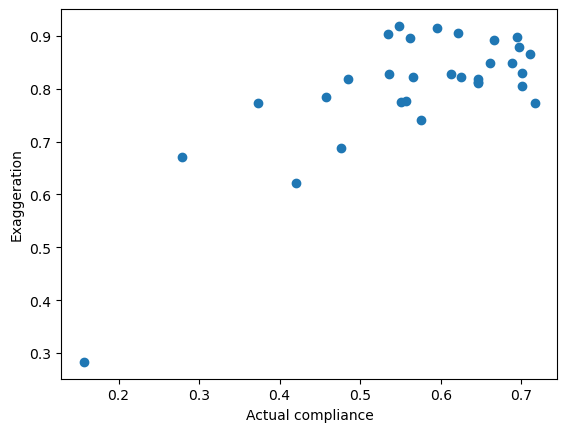

In [27]:
plt.scatter(df['A_score'], df['Exaggeration_Score'])
plt.xlabel("Actual compliance")
plt.ylabel("Exaggeration")
plt.show()

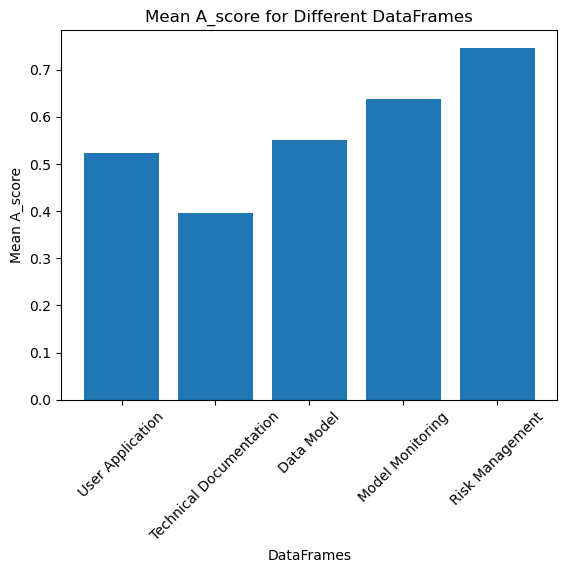

In [28]:
# Calculate the mean A_score values for each DataFrame
mean_A_score_user = df_UserApplication['A_score'].mean()
mean_A_score_tech = df_TechnicalDocumentation['A_score'].mean()
mean_A_score_datamodel = df_DataModel['A_score'].mean()
mean_A_score_modelmonitoring = df_ModelMonitoring['A_score'].mean()
mean_A_score_riskmanagement = df_RiskManagement['A_score'].mean()

# Data for the bar plot
categories = [
    'User Application',
    'Technical Documentation',
    'Data Model',
    'Model Monitoring',
    'Risk Management']

mean_scores = [
    mean_A_score_user,
    mean_A_score_tech,
    mean_A_score_datamodel,
    mean_A_score_modelmonitoring,
    mean_A_score_riskmanagement]

# Create a bar plot
plt.bar(categories, mean_scores)

# Adding labels and title
plt.xlabel('DataFrames')
plt.ylabel('Mean A_score')
plt.title('Mean A_score for Different DataFrames')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()

# ANALYSIS <a id='section-0'></a>

### Table of Contents
- [Section 1: The size of a company (Q6): ANOVA](#section-1)
- [Section 2: The role of the person filling in the survey (Q5): ANOVA](#section-2)
- [Section 3: Adoption date of AI technologies (Q10): ANOVA](#section-3)
- [Section 4: Company's familiarity with the EU AI Act (Q16_NPS_GROUP): ANOVA](#section-4)
- [Section 5: The degree to which a company offshores (employs others outside Europe) (Q22): Linear Regression](#section-5)
- [Section 6: The degree to which a company outsources (employs others outside Europe) (Q22): Linear Regression](#section-6)

In [29]:
#df = pd.read_csv('cleaned_AIsurvey.csv')

#df per category
#df_DataModel = pd.read_csv('Cleaned_DataModel.csv')
#df_ModelMonitoring = pd.read_csv('Cleaned_ModelMonitoring.csv')
#df_RiskManagement = pd.read_csv('Cleaned_RiskManagement.csv')
#df_TechnicalDocumentation = pd.read_csv('Cleaned_TechnicalDocumentation.csv')
#df_UserApplication = pd.read_csv('Cleaned_UserApplication.csv')

In [30]:
# Replace NaN-values for 1 in the DataFrame
df = df.fillna(value=1)
df_DataModel = df_DataModel.fillna(value=1)
df_ModelMonitoring = df_ModelMonitoring.fillna(value=1)
df_RiskManagement = df_RiskManagement.fillna(value=1)
df_TechnicalDocumentation = df_TechnicalDocumentation.fillna(value=1)
df_UserApplication = df_UserApplication.fillna(value=1)

# 1. The size of a company (Q6): ANOVA <a id='section-1'></a>


## Total

Actual compliance
- $H_0$: The size of a company doesn't have an impact on the company's actual compliance
- $H_a$: The size of a company has an impact on the company's actual compliance


In [31]:
#Fitting One-way ANOVA linear model for testing H0 using the 'ols' class in the smf (statsmodels.formula.api) package
ActualCompliance0 = smf.ols('A_score ~ Q6', data = df).fit()

#Creating the anova table using the stats.anova_lm method in the sm (statsmodels.api) package
Actual_anova_table0 = sm.stats.anova_lm(ActualCompliance0)
print(Actual_anova_table0)

#PR>F = the p-value

            df    sum_sq  mean_sq         F    PR(>F)
Q6         1.0  0.005880  0.00588  0.335988  0.566631
Residual  29.0  0.507487  0.01750       NaN       NaN


Perceived compliance (feeling)
- $H_0$: The size of a company doesn't have an impact on the company's perceived compliance
- $H_a$: The size of a company has an impact on the company's perceived compliance

In [32]:
FeelingCompliance0 = smf.ols('F_score ~ Q6', data = df).fit()
Feeling_anova_table0 = sm.stats.anova_lm(FeelingCompliance0)
print(Feeling_anova_table0)

            df    sum_sq   mean_sq         F   PR(>F)
Q6         1.0  0.026859  0.026859  2.110046  0.15707
Residual  29.0  0.369147  0.012729       NaN      NaN


Exaggerated compliance (exageration)
- $H_0$: The size of a company doesn't have an impact on the company's exaggerated compliance
- $H_a$: The size of a company has an impact on the company's exaggerated compliance

In [33]:
ExaggerationCompliance0 = smf.ols('Exaggeration_Score ~ Q6', data = df).fit()
Exaggeration_anova_table0 = sm.stats.anova_lm(ExaggerationCompliance0)
print(Exaggeration_anova_table0)

            df    sum_sq   mean_sq         F    PR(>F)
Q6         1.0  0.011319  0.011319  0.783195  0.383445
Residual  29.0  0.419124  0.014453       NaN       NaN


## Categorie 1: Data Model

Actual compliance
- $H_0$: The size of a company doesn't have an impact on the company's actual compliance in the category Data Model 
- $H_a$: The size of a company has an impact on the company's actual compliance in the category Data model

In [34]:
ActualCompliance1 = smf.ols('A_score ~ Q6', data = df_DataModel).fit()
Actual_anova_table1 = sm.stats.anova_lm(ActualCompliance1)
print(Actual_anova_table1)

            df    sum_sq   mean_sq         F    PR(>F)
Q6         1.0  0.012645  0.012645  1.342506  0.256045
Residual  29.0  0.273155  0.009419       NaN       NaN


Perceived compliance (feeling)
- $H_0$: The size of a company doesn't have an impact on the company's perceived compliance in the category Data Model
- $H_a$: The size of a company has an impact on the company's perceived compliance in the category Data Model

In [35]:
FeelingCompliance1 = smf.ols('F_score ~ Q6', data = df_DataModel).fit()
Feeling_anova_table1 = sm.stats.anova_lm(FeelingCompliance1)
print(Feeling_anova_table1)

            df    sum_sq   mean_sq        F    PR(>F)
Q6         1.0  0.001414  0.001414  0.20101  0.657239
Residual  29.0  0.203948  0.007033      NaN       NaN


Exaggerated compliance (exageration)
- $H_0$: The size of a company doesn't have an impact on the company's exaggerated compliance in the category Data Model
- $H_a$: The size of a company has an impact on the company's exaggerated compliance in the category Data Model

In [36]:
ExaggerationCompliance1 = smf.ols('Exaggeration_Score ~ Q6', data = df_DataModel).fit()
Exaggeration_anova_table1 = sm.stats.anova_lm(ExaggerationCompliance1)
print(Exaggeration_anova_table1)

            df    sum_sq   mean_sq         F    PR(>F)
Q6         1.0  0.010969  0.010969  1.092935  0.304458
Residual  29.0  0.291057  0.010036       NaN       NaN


## Categorie 2: Model Monitoring

Actual compliance
- $H_0$: The size of a company doesn't have an impact on the company's actual compliance in the category Model Monitoring
- $H_a$: The size of a company has an impact on the company's actual compliance in the category Model Monitoring

In [37]:
ActualCompliance2 = smf.ols('A_score ~ Q6', data = df_ModelMonitoring).fit()
Actual_anova_table2 = sm.stats.anova_lm(ActualCompliance2)
print(Actual_anova_table2)

            df    sum_sq   mean_sq         F   PR(>F)
Q6         1.0  0.000823  0.000823  0.030256  0.86312
Residual  29.0  0.789291  0.027217       NaN      NaN


Perceived compliance (feeling)
- $H_0$: The size of a company doesn't have an impact on the company's perceived compliance in the category Model Monitoring
- $H_a$: The size of a company has an impact on the company's perceived compliance in the category Model Monitoring

In [38]:
FeelingCompliance2 = smf.ols('F_score ~ Q6', data = df_ModelMonitoring).fit()
Feeling_anova_table2 = sm.stats.anova_lm(FeelingCompliance2)
print(Feeling_anova_table2)

            df    sum_sq   mean_sq         F    PR(>F)
Q6         1.0  0.007798  0.007798  0.261642  0.612867
Residual  29.0  0.864356  0.029805       NaN       NaN


Exaggerated compliance (exageration)
- $H_0$: The size of a company doesn't have an impact on the company's exaggerated compliance in the category Model Monitoring
- $H_a$: The size of a company has an impact on the company's exaggerated compliance in the category Model Monitoring

In [39]:
ExaggerationCompliance2 = smf.ols('Exaggeration_Score ~ Q6', data = df_ModelMonitoring).fit()
Exaggeration_anova_table2 = sm.stats.anova_lm(ExaggerationCompliance2)
print(Exaggeration_anova_table2)

            df    sum_sq   mean_sq         F    PR(>F)
Q6         1.0  0.045634  0.045634  0.664329  0.421679
Residual  29.0  1.992081  0.068692       NaN       NaN


## Categorie 3: Risk Management

Actual compliance
- $H_0$: The size of a company doesn't have an impact on the company's actual compliance in the category Risk Management
- $H_a$: The size of a company has an impact on the company's actual compliance in the category Risk Management

In [40]:
ActualCompliance3 = smf.ols('A_score ~ Q6', data = df_RiskManagement).fit()
Actual_anova_table3 = sm.stats.anova_lm(ActualCompliance3)
print(Actual_anova_table3)

            df    sum_sq   mean_sq         F    PR(>F)
Q6         1.0  0.028198  0.028198  0.307243  0.583627
Residual  29.0  2.661544  0.091777       NaN       NaN


Perceived compliance (feeling)
- $H_0$: The size of a company doesn't have an impact on the company's perceived compliance in the category Risk Management
- $H_a$: The size of a company has an impact on the company's perceived compliance in the category Risk Management

In [41]:
FeelingCompliance3 = smf.ols('F_score ~ Q6', data = df_RiskManagement).fit()
Feeling_anova_table3 = sm.stats.anova_lm(FeelingCompliance3)
print(Feeling_anova_table3)

            df    sum_sq   mean_sq         F    PR(>F)
Q6         1.0  0.097074  0.097074  1.348817  0.254955
Residual  29.0  2.087115  0.071969       NaN       NaN


Exaggerated compliance (exageration)
- $H_0$: The size of a company doesn't have an impact on the company's exaggerated compliance in the category Risk Management
- $H_a$: The size of a company has an impact on the company's exaggerated compliance in the category Risk Management

In [42]:
ExaggerationCompliance3 = smf.ols('Exaggeration_Score ~ Q6', data = df_RiskManagement).fit()
Exaggeration_anova_table3 = sm.stats.anova_lm(ExaggerationCompliance3)
print(Exaggeration_anova_table3)

            df    sum_sq   mean_sq         F    PR(>F)
Q6         1.0  0.005272  0.005272  0.064032  0.802019
Residual  29.0  2.387571  0.082330       NaN       NaN


## Categorie 4: Technical Documentation

Actual compliance
- $H_0$: The size of a company doesn't have an impact on the company's actual compliance in the category Technical Documenation
- $H_a$: The size of a company has an impact on the company's actual compliance in the category Technical Documentation

In [43]:
ActualCompliance4 = smf.ols('A_score ~ Q6', data = df_TechnicalDocumentation).fit()
Actual_anova_table4 = sm.stats.anova_lm(ActualCompliance4)
print(Actual_anova_table4)

            df    sum_sq   mean_sq         F    PR(>F)
Q6         1.0  0.013242  0.013242  0.810249  0.375461
Residual  29.0  0.473937  0.016343       NaN       NaN


Perceived compliance (feeling)
- $H_0$: The size of a company doesn't have an impact on the company's perceived compliance in the category Technical Documentation
- $H_a$: The size of a company has an impact on the company's perceived compliance in the category Technical Documentation

In [44]:
FeelingCompliance4 = smf.ols('F_score ~ Q6', data = df_TechnicalDocumentation).fit()
Feeling_anova_table4 = sm.stats.anova_lm(FeelingCompliance4)
print(Feeling_anova_table4)

            df    sum_sq   mean_sq         F    PR(>F)
Q6         1.0  0.008894  0.008894  0.582361  0.451552
Residual  29.0  0.442894  0.015272       NaN       NaN


Exaggerated compliance (exageration)
- $H_0$: The size of a company doesn't have an impact on the company's exaggerated compliance in the category Technical Documentation
- $H_a$: The size of a company has an impact on the company's exaggerated compliance in the category Technical Documentation

In [45]:
ExaggerationCompliance4 = smf.ols('Exaggeration_Score ~ Q6', data = df_TechnicalDocumentation).fit()
Exaggeration_anova_table4 = sm.stats.anova_lm(ExaggerationCompliance4)
print(Exaggeration_anova_table4)

            df    sum_sq  mean_sq         F    PR(>F)
Q6         1.0  0.291450  0.29145  6.811129  0.014183
Residual  29.0  1.240918  0.04279       NaN       NaN


## Categorie 5: User Application

Actual compliance
- $H_0$: The size of a company doesn't have an impact on the company's actual compliance in the category User Application 
- $H_a$: The size of a company has an impact on the company's actual compliance in the category User Application

In [46]:
ActualCompliance5 = smf.ols('A_score ~ Q6', data = df_UserApplication).fit()
Actual_anova_table5 = sm.stats.anova_lm(ActualCompliance5)
print(Actual_anova_table5)

            df    sum_sq   mean_sq         F    PR(>F)
Q6         1.0  0.060905  0.060905  3.129789  0.087391
Residual  29.0  0.564330  0.019460       NaN       NaN


Perceived compliance (feeling)
- $H_0$: The size of a company doesn't have an impact on the company's perceived compliance in the category User Application
- $H_a$: The size of a company has an impact on the company's perceived compliance in the category User Application

In [47]:
FeelingCompliance5 = smf.ols('F_score ~ Q6', data = df_UserApplication).fit()
Feeling_anova_table5 = sm.stats.anova_lm(FeelingCompliance5)
print(Feeling_anova_table5)

            df    sum_sq   mean_sq         F    PR(>F)
Q6         1.0  0.082747  0.082747  3.346988  0.077627
Residual  29.0  0.716966  0.024723       NaN       NaN


Exaggerated compliance (exageration)
- $H_0$: The size of a company doesn't have an impact on the company's exaggerated compliance in the category Technical Documentation
- $H_a$: The size of a company has an impact on the company's exaggerated compliance in the category Technical Documentation

In [48]:
ExaggerationCompliance5 = smf.ols('Exaggeration_Score ~ Q6', data = df_UserApplication).fit()
Exaggeration_anova_table5 = sm.stats.anova_lm(ExaggerationCompliance5)
print(Exaggeration_anova_table5)

            df    sum_sq   mean_sq         F    PR(>F)
Q6         1.0  0.001996  0.001996  0.086715  0.770493
Residual  29.0  0.667381  0.023013       NaN       NaN


## Conclusion: The size of a company (Q6)


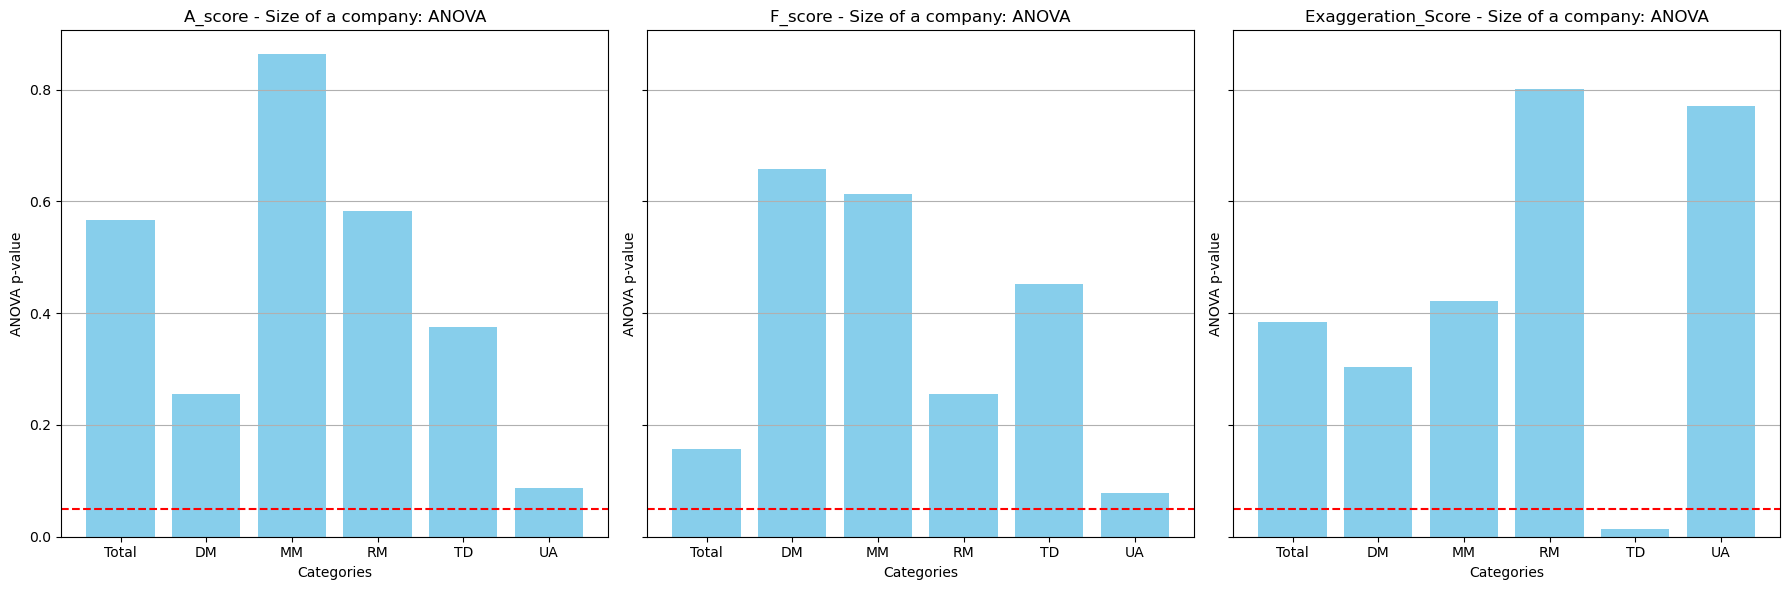

In [49]:
# Extracting p-values from the ANOVA tables for Category 'Total'
Ap0_values_Total = [Actual_anova_table0['PR(>F)']['Q6']]
Fp0_values_Total = [Feeling_anova_table0['PR(>F)']['Q6']]
Ep0_values_Total = [Exaggeration_anova_table0['PR(>F)']['Q6']]


Ap1_values_Total = [Actual_anova_table1['PR(>F)']['Q6']]
Fp1_values_Total = [Feeling_anova_table1['PR(>F)']['Q6']]
Ep1_values_Total = [Exaggeration_anova_table1['PR(>F)']['Q6']]

Ap2_values_Total = [Actual_anova_table2['PR(>F)']['Q6']]
Fp2_values_Total = [Feeling_anova_table2['PR(>F)']['Q6']]
Ep2_values_Total = [Exaggeration_anova_table2['PR(>F)']['Q6']]

Ap3_values_Total = [Actual_anova_table3['PR(>F)']['Q6']]
Fp3_values_Total = [Feeling_anova_table3['PR(>F)']['Q6']]
Ep3_values_Total = [Exaggeration_anova_table3['PR(>F)']['Q6']]

Ap4_values_Total = [Actual_anova_table4['PR(>F)']['Q6']]
Fp4_values_Total = [Feeling_anova_table4['PR(>F)']['Q6']]
Ep4_values_Total = [Exaggeration_anova_table4['PR(>F)']['Q6']]

Ap5_values_Total = [Actual_anova_table5['PR(>F)']['Q6']]
Fp5_values_Total = [Feeling_anova_table5['PR(>F)']['Q6']]
Ep5_values_Total = [Exaggeration_anova_table5['PR(>F)']['Q6']]

# Combine all P-values for the same category
combined_p_values = [
    Ap0_values_Total + Ap1_values_Total + Ap2_values_Total + Ap3_values_Total + Ap4_values_Total + Ap5_values_Total,
    Fp0_values_Total + Fp1_values_Total + Fp2_values_Total + Fp3_values_Total + Fp4_values_Total + Fp5_values_Total,
    Ep0_values_Total + Ep1_values_Total + Ep2_values_Total + Ep3_values_Total + Ep4_values_Total + Ep5_values_Total
]

# List of dataframes and their ANOVA p-values
dataframes = ['Total', 'DM', 'MM', 'RM', 'TD', 'UA']
custom_labels = ['A_score', 'F_score', 'Exaggeration_Score']

# Plotting the combined ANOVA p-values for each category in subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, values in enumerate(combined_p_values):
    axes[i].bar(dataframes, values, color='skyblue')
    axes[i].set_title(f'{custom_labels[i]} - Size of a company: ANOVA')
    axes[i].set_xlabel('Categories')
    axes[i].set_ylabel('ANOVA p-value')
    axes[i].axhline(y=0.05, color='red', linestyle='--', label='Significance Level (0.05)')
    axes[i].grid(axis='y')

plt.tight_layout()
plt.show()


**Bonferonni's correction**

In [150]:
# Create a DataFrame with 'Q6' and 'Exaggeration_Score'
data = pd.DataFrame({'Q6': df_TechnicalDocumentation['Q6'], 'Exaggeration_Score': df_TechnicalDocumentation['Exaggeration_Score']})

# Perform Tukey's HSD test for multiple comparisons
tukey_result = pairwise_tukeyhsd(data['Exaggeration_Score'], data['Q6'])

# Print the Tukey HSD results
print(tukey_result)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2  -0.1191 0.6598 -0.4015 0.1632  False
     1      3   -0.116 0.9535 -0.7259  0.494  False
     1      4  -0.2297 0.0701 -0.4735  0.014  False
     2      3   0.0032    1.0 -0.6211 0.6274  False
     2      4  -0.1106 0.6987 -0.3883 0.1671  False
     3      4  -0.1137 0.9555 -0.7216 0.4941  False
---------------------------------------------------


# 2. The role of the person filling in the survey (Q5): ANOVA <a id='section-2'></a>

## Total

Actual compliance
- $H_0$: The role of the person filling in the survey doesn't have an impact on the company's actual compliance
- $H_a$: The role of the person filling in the survey has an impact on the company's actual compliance

In [50]:
ActualCompliance0 = smf.ols('A_score ~ Q5', data = df).fit()
Actual_anova_table0 = sm.stats.anova_lm(ActualCompliance0)
print(Actual_anova_table0)

            df    sum_sq   mean_sq         F   PR(>F)
Q5         8.0  0.109204  0.013650  0.743044  0.65384
Residual  22.0  0.404163  0.018371       NaN      NaN


Perceived compliance (feeling)
- $H_0$: The role of the person filling in the survey doesn't have an impact on the company's perceived compliance
- $H_a$: The role of the person filling in the survey has an impact on the company's perceived compliance

In [51]:
FeelingCompliance0 = smf.ols('F_score ~ Q5', data = df).fit()
Feeling_anova_table0 = sm.stats.anova_lm(FeelingCompliance0)
print(Feeling_anova_table0)

            df    sum_sq   mean_sq         F    PR(>F)
Q5         8.0  0.074952  0.009369  0.642002  0.734542
Residual  22.0  0.321055  0.014593       NaN       NaN


Exaggerated compliance (exageration)
- $H_0$: The role of the person filling in the survey doesn't have an impact on the company's exaggerated compliance
- $H_a$: The role of the person filling in the survey has an impact on the company's exaggerated compliance

In [52]:
ExaggerationCompliance0 = smf.ols('Exaggeration_Score ~ Q5', data = df).fit()
Exaggeration_anova_table0 = sm.stats.anova_lm(ExaggerationCompliance0)
print(Exaggeration_anova_table0)

            df    sum_sq   mean_sq         F    PR(>F)
Q5         8.0  0.065754  0.008219  0.495826  0.846072
Residual  22.0  0.364690  0.016577       NaN       NaN


## Categorie 1: Data Model

Actual compliance
- $H_0$: The role of the person filling in the survey doesn't have an impact on the company's actual compliance in the category Data Model
- $H_a$: The role of the person filling in the survey has an impact on the company's actual compliance in the category Data Model

In [53]:
ActualCompliance1 = smf.ols('A_score ~ Q5', data = df_DataModel).fit()
Actual_anova_table1 = sm.stats.anova_lm(ActualCompliance1)
print(Actual_anova_table1)

            df    sum_sq   mean_sq         F    PR(>F)
Q5         8.0  0.076708  0.009588  1.008865  0.457547
Residual  22.0  0.209092  0.009504       NaN       NaN


Perceived compliance (feeling)
- $H_0$: The role of the person filling in the survey doesn't have an impact on the company's perceived compliance in the category Data Model
- $H_a$: The role of the person filling in the survey has an impact on the company's perceived compliance in category Data Model

In [54]:
FeelingCompliance1 = smf.ols('F_score ~ Q5', data = df_DataModel).fit()
Feeling_anova_table1 = sm.stats.anova_lm(FeelingCompliance1)
print(Feeling_anova_table1)

            df    sum_sq   mean_sq         F    PR(>F)
Q5         8.0  0.047280  0.005910  0.822487  0.591613
Residual  22.0  0.158082  0.007186       NaN       NaN


Exaggerated compliance (exageration)
- $H_0$: The role of the person filling in the survey doesn't have an impact on the company's exaggerated compliance in the category Data Model
- $H_a$: The role of the person filling in the survey has an impact on the company's exaggerated compliance in the category Data Model

In [55]:
ExaggerationCompliance1 = smf.ols('Exaggeration_Score ~ Q5', data = df_DataModel).fit()
Exaggeration_anova_table1 = sm.stats.anova_lm(ExaggerationCompliance1)
print(Exaggeration_anova_table1)

            df    sum_sq   mean_sq         F    PR(>F)
Q5         8.0  0.085036  0.010630  1.077698  0.413604
Residual  22.0  0.216990  0.009863       NaN       NaN


## Categorie 2: Model Monitoring

Actual compliance
- $H_0$: The role of the person filling in the survey doesn't have an impact on the company's actual compliance in the category Model Monotoring
- $H_a$: The role of the person filling in the survey has an impact on the company's actual compliance in the category Model Monotoring

In [56]:
ActualCompliance2 = smf.ols('A_score ~ Q5', data = df_ModelMonitoring).fit()
Actual_anova_table2 = sm.stats.anova_lm(ActualCompliance2)
print(Actual_anova_table2)

            df    sum_sq   mean_sq         F    PR(>F)
Q5         8.0  0.173637  0.021705  0.774566  0.628911
Residual  22.0  0.616477  0.028022       NaN       NaN


Perceived compliance (feeling)
- $H_0$: The role of the person filling in the survey doesn't have an impact on the company's perceived compliance in the category Model Monitoring
- $H_a$: The role of the person filling in the survey has an impact on the company's perceived compliance in the category Model Monitoring

In [57]:
FeelingCompliance2 = smf.ols('F_score ~ Q5', data = df_ModelMonitoring).fit()
Feeling_anova_table2 = sm.stats.anova_lm(FeelingCompliance2)
print(Feeling_anova_table2)

            df    sum_sq   mean_sq         F    PR(>F)
Q5         8.0  0.209877  0.026235  0.871478  0.554485
Residual  22.0  0.662278  0.030104       NaN       NaN


Exaggerated compliance (exageration)
- $H_0$: The role of the person filling in the survey doesn't have an impact on the company's exaggerated compliance in the category Model Monitoring
- $H_a$: The role of the person filling in the survey has an impact on the company's exaggerated compliance

In [58]:
ExaggerationCompliance2 = smf.ols('Exaggeration_Score ~ Q5', data = df_ModelMonitoring).fit()
Exaggeration_anova_table2 = sm.stats.anova_lm(ExaggerationCompliance2)
print(Exaggeration_anova_table2)

            df    sum_sq   mean_sq        F    PR(>F)
Q5         8.0  0.267905  0.033488  0.41628  0.898818
Residual  22.0  1.769811  0.080446      NaN       NaN


## Categorie 3: Risk Management

Actual compliance
- $H_0$: The role of the person filling in the survey doesn't have an impact on the company's actual compliance in the category Risk Management
- $H_a$: The role of the person filling in the survey has an impact on the company's actual compliance in the category Risk Management

In [59]:
ActualCompliance3 = smf.ols('A_score ~ Q5', data = df_RiskManagement).fit()
Actual_anova_table3 = sm.stats.anova_lm(ActualCompliance3)
print(Actual_anova_table3)

            df    sum_sq   mean_sq         F   PR(>F)
Q5         8.0  0.797131  0.099641  1.158247  0.36637
Residual  22.0  1.892611  0.086028       NaN      NaN


Perceived compliance (feeling)
- $H_0$: The role of the person filling in the survey doesn't have an impact on the company's perceived compliance in the category Risk Management
- $H_a$: The role of the person filling in the survey has an impact on the company's perceived compliance in the category Risk Management

In [60]:
FeelingCompliance3 = smf.ols('F_score ~ Q5', data = df_RiskManagement).fit()
Feeling_anova_table3 = sm.stats.anova_lm(FeelingCompliance3)
print(Feeling_anova_table3)

            df    sum_sq   mean_sq         F    PR(>F)
Q5         8.0  0.525694  0.065712  0.871668  0.554343
Residual  22.0  1.658495  0.075386       NaN       NaN


Exaggerated compliance (exageration)
- $H_0$: The role of the person filling in the survey doesn't have an impact on the company's exaggerated compliance in the category Risk Management
- $H_a$: The role of the person filling in the survey has an impact on the company's exaggerated compliance in the category Risk Management

In [61]:
ExaggerationCompliance3 = smf.ols('Exaggeration_Score ~ Q5', data = df_RiskManagement).fit()
Exaggeration_anova_table3 = sm.stats.anova_lm(ExaggerationCompliance3)
print(Exaggeration_anova_table3)

            df    sum_sq   mean_sq         F    PR(>F)
Q5         8.0  0.544180  0.068022  0.809501  0.601636
Residual  22.0  1.848663  0.084030       NaN       NaN


## Categorie 4: Technical Documentation

Actual compliance
- $H_0$: The role of the person filling in the survey doesn't have an impact on the company's actual compliance in the category Technical Documentation
- $H_a$: The role of the person filling in the survey has an impact on the company's actual compliance in the category Technical Documentation

In [62]:
ActualCompliance4 = smf.ols('A_score ~ Q5', data = df_TechnicalDocumentation).fit()
Actual_anova_table4 = sm.stats.anova_lm(ActualCompliance4)
print(Actual_anova_table4)

            df    sum_sq   mean_sq         F    PR(>F)
Q5         8.0  0.107649  0.013456  0.780008  0.624635
Residual  22.0  0.379529  0.017251       NaN       NaN


Perceived compliance (feeling)
- $H_0$: The role of the person filling in the survey doesn't have an impact on the company's perceived compliance in the category Technical Documentation
- $H_a$: The role of the person filling in the survey has an impact on the company's perceived compliance in the category Technical Documentation

In [63]:
FeelingCompliance4 = smf.ols('F_score ~ Q5', data = df_TechnicalDocumentation).fit()
Feeling_anova_table4 = sm.stats.anova_lm(FeelingCompliance4)
print(Feeling_anova_table4)

            df    sum_sq   mean_sq         F    PR(>F)
Q5         8.0  0.110745  0.013843  0.892988  0.538566
Residual  22.0  0.341043  0.015502       NaN       NaN


Exaggerated compliance (exageration)
- $H_0$: The role of the person filling in the survey doesn't have an impact on the company's exaggerated compliance in the category Technical Documentation
- $H_a$: The role of the person filling in the survey has an impact on the company's exaggerated compliance in the category Technical Documentation

In [64]:
ExaggerationCompliance4 = smf.ols('Exaggeration_Score ~ Q5', data = df_TechnicalDocumentation).fit()
Exaggeration_anova_table4 = sm.stats.anova_lm(ExaggerationCompliance4)
print(Exaggeration_anova_table4)

            df    sum_sq   mean_sq         F    PR(>F)
Q5         8.0  0.294092  0.036762  0.653129  0.725674
Residual  22.0  1.238276  0.056285       NaN       NaN


## Categorie 5: User Application

Actual compliance
- $H_0$: The role of the person filling in the survey doesn't have an impact on the company's actual compliance in the category User Application
- $H_a$: The role of the person filling in the survey has an impact on the company's actual compliance in the category User Application

In [65]:
ActualCompliance5 = smf.ols('A_score ~ Q5', data = df_UserApplication).fit()
Actual_anova_table5 = sm.stats.anova_lm(ActualCompliance5)
print(Actual_anova_table5)

            df    sum_sq   mean_sq         F    PR(>F)
Q5         8.0  0.081339  0.010167  0.411261  0.901859
Residual  22.0  0.543896  0.024723       NaN       NaN


Perceived compliance (feeling)
- $H_0$: The role of the person filling in the survey doesn't have an impact on the company's perceived compliance in the category User Application
- $H_a$: The role of the person filling in the survey has an impact on the company's perceived compliance in the category User Application

In [66]:
FeelingCompliance5 = smf.ols('F_score ~ Q5', data = df_UserApplication).fit()
Feeling_anova_table5 = sm.stats.anova_lm(FeelingCompliance5)
print(Feeling_anova_table5)

            df    sum_sq   mean_sq         F    PR(>F)
Q5         8.0  0.131212  0.016402  0.539766  0.813982
Residual  22.0  0.668501  0.030386       NaN       NaN


Exaggerated compliance (exageration)
- $H_0$: The role of the person filling in the survey doesn't have an impact on the company's exaggerated compliance in the category User Application
- $H_a$: The role of the person filling in the survey has an impact on the company's exaggerated compliance in the category User Application

In [67]:
ExaggerationCompliance5 = smf.ols('Exaggeration_Score ~ Q5', data = df_UserApplication).fit()
Exaggeration_anova_table5 = sm.stats.anova_lm(ExaggerationCompliance5)
print(Exaggeration_anova_table5)

            df    sum_sq   mean_sq         F    PR(>F)
Q5         8.0  0.064192  0.008024  0.291693  0.961372
Residual  22.0  0.605184  0.027508       NaN       NaN


## Conclusion: The role of the person filling in the survey (Q5)

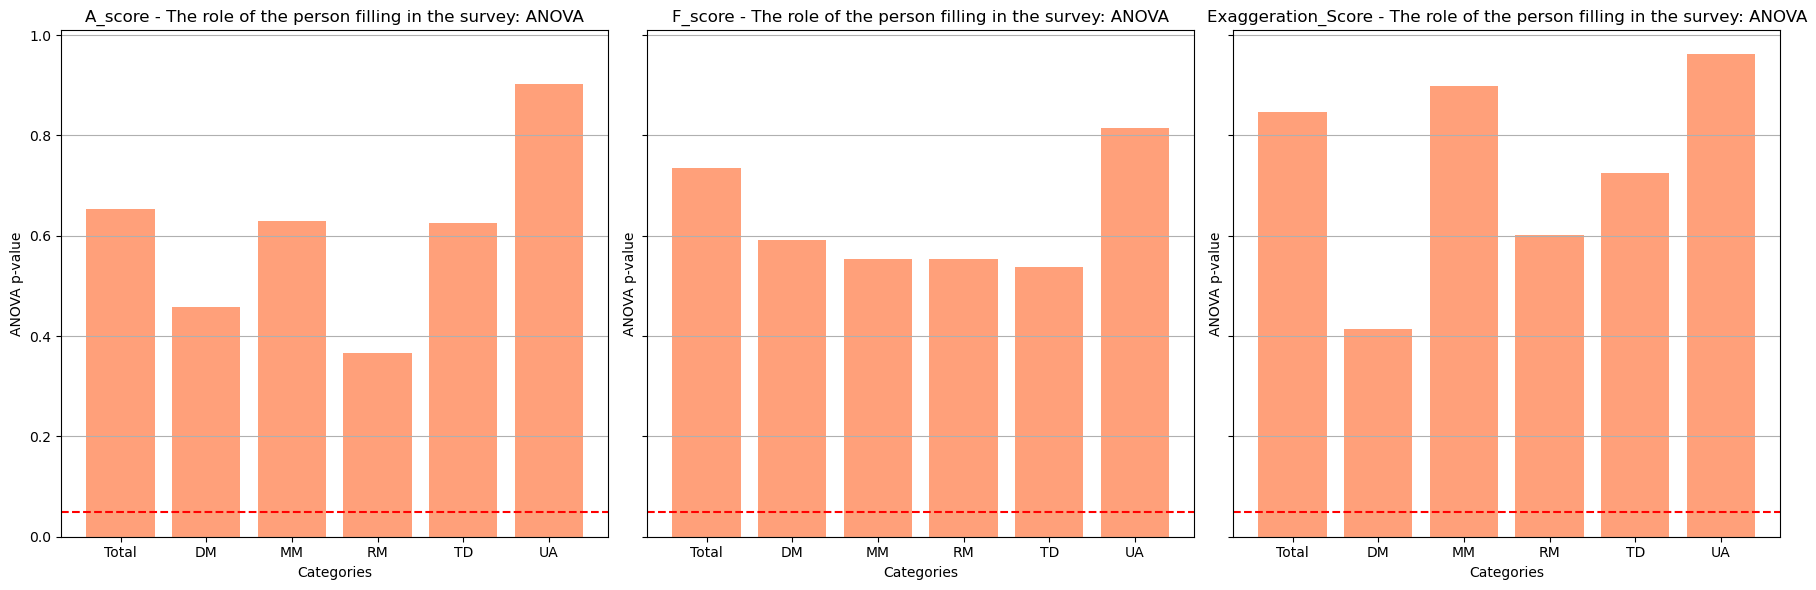

In [68]:
# Extracting p-values from the ANOVA tables for Category 'Total'
Ap0_values_Total = [Actual_anova_table0['PR(>F)']['Q5']]
Fp0_values_Total = [Feeling_anova_table0['PR(>F)']['Q5']]
Ep0_values_Total = [Exaggeration_anova_table0['PR(>F)']['Q5']]


Ap1_values_Total = [Actual_anova_table1['PR(>F)']['Q5']]
Fp1_values_Total = [Feeling_anova_table1['PR(>F)']['Q5']]
Ep1_values_Total = [Exaggeration_anova_table1['PR(>F)']['Q5']]

Ap2_values_Total = [Actual_anova_table2['PR(>F)']['Q5']]
Fp2_values_Total = [Feeling_anova_table2['PR(>F)']['Q5']]
Ep2_values_Total = [Exaggeration_anova_table2['PR(>F)']['Q5']]

Ap3_values_Total = [Actual_anova_table3['PR(>F)']['Q5']]
Fp3_values_Total = [Feeling_anova_table3['PR(>F)']['Q5']]
Ep3_values_Total = [Exaggeration_anova_table3['PR(>F)']['Q5']]

Ap4_values_Total = [Actual_anova_table4['PR(>F)']['Q5']]
Fp4_values_Total = [Feeling_anova_table4['PR(>F)']['Q5']]
Ep4_values_Total = [Exaggeration_anova_table4['PR(>F)']['Q5']]

Ap5_values_Total = [Actual_anova_table5['PR(>F)']['Q5']]
Fp5_values_Total = [Feeling_anova_table5['PR(>F)']['Q5']]
Ep5_values_Total = [Exaggeration_anova_table5['PR(>F)']['Q5']]

# Combine all P-values for the same category
combined_p_values = [
    Ap0_values_Total + Ap1_values_Total + Ap2_values_Total + Ap3_values_Total + Ap4_values_Total + Ap5_values_Total,
    Fp0_values_Total + Fp1_values_Total + Fp2_values_Total + Fp3_values_Total + Fp4_values_Total + Fp5_values_Total,
    Ep0_values_Total + Ep1_values_Total + Ep2_values_Total + Ep3_values_Total + Ep4_values_Total + Ep5_values_Total
]

# List of dataframes and their ANOVA p-values
dataframes = ['Total', 'DM', 'MM', 'RM', 'TD', 'UA']
custom_labels = ['A_score', 'F_score', 'Exaggeration_Score']

# Plotting the combined ANOVA p-values for each category in subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, values in enumerate(combined_p_values):
    axes[i].bar(dataframes, values, color='lightsalmon')
    axes[i].set_title(f'{custom_labels[i]} - The role of the person filling in the survey: ANOVA')
    axes[i].set_xlabel('Categories')
    axes[i].set_ylabel('ANOVA p-value')
    axes[i].axhline(y=0.05, color='red', linestyle='--', label='Significance Level (0.05)')
    axes[i].grid(axis='y')

plt.tight_layout()
plt.show()

# 3. Adoption date of AI technologies (Q10): ANOVA <a id='section-3'></a>

## Total

Actual compliance
- $H_0$: The adoption date of AI technologies doesn't have an impact on the company's actual compliance
- $H_a$: The adoption date of AI technologies has an impact on the company's actual compliance

In [69]:
ActualCompliance0 = smf.ols('A_score ~ Q10', data = df).fit()
Actual_anova_table0 = sm.stats.anova_lm(ActualCompliance0)
print(Actual_anova_table0)

            df    sum_sq   mean_sq         F    PR(>F)
Q10        1.0  0.000172  0.000172  0.009711  0.922177
Residual  29.0  0.513195  0.017696       NaN       NaN


Perceived compliance (feeling)
- $H_0$: The adoption date of AI technologies doesn't have an impact on the company's perceived compliance
- $H_a$: The adoption date of AI technologies  has an impact on the company's perceived compliance

In [70]:
FeelingCompliance0 = smf.ols('F_score ~ Q10', data = df).fit()
Feeling_anova_table0 = sm.stats.anova_lm(FeelingCompliance0)
print(Feeling_anova_table0)

            df    sum_sq   mean_sq         F    PR(>F)
Q10        1.0  0.007197  0.007197  0.536764  0.469657
Residual  29.0  0.388810  0.013407       NaN       NaN


Exaggerated compliance
- $H_0$: The adoption date of AI technologies doesn't have an impact on the company's exaggerated compliance
- $H_a$: The adoption date of AI technologies has an impact on the company's exaggerated compliance

In [71]:
ExaggerationCompliance0 = smf.ols('Exaggeration_Score ~ Q10', data = df).fit()
Exaggeration_anova_table0 = sm.stats.anova_lm(ExaggerationCompliance0)
print(Exaggeration_anova_table0)

            df    sum_sq   mean_sq         F    PR(>F)
Q10        1.0  0.019007  0.019007  1.339712  0.256529
Residual  29.0  0.411436  0.014187       NaN       NaN


## Categorie 1: Data Model

Actual compliance
- $H_0$: The adoption date of AI technologies doesn't have an impact on the company's actual compliance in the category Data Model
- $H_a$: The adoption date of AI technologies has an impact on the company's actual compliance in the category Data model

In [72]:
ActualCompliance1 = smf.ols('A_score ~ Q10', data = df_DataModel).fit()
Actual_anova_table1 = sm.stats.anova_lm(ActualCompliance1)
print(Actual_anova_table1)

            df    sum_sq   mean_sq         F    PR(>F)
Q10        1.0  0.000129  0.000129  0.013101  0.909662
Residual  29.0  0.285671  0.009851       NaN       NaN


Perceived compliance (feeling)
- $H_0$: The adoption date of AI technologies doesn't have an impact on the company's perceived compliance in the category Data Model
- $H_a$: The adoption date of AI technologies  has an impact on the company's perceived compliance in the category Data Model

In [73]:
FeelingCompliance1 = smf.ols('F_score ~ Q10', data = df_DataModel).fit()
Feeling_anova_table1 = sm.stats.anova_lm(FeelingCompliance1)
print(Feeling_anova_table1)

            df    sum_sq   mean_sq         F    PR(>F)
Q10        1.0  0.000314  0.000314  0.044469  0.834457
Residual  29.0  0.205047  0.007071       NaN       NaN


Exaggerated compliance
- $H_0$: The adoption date of AI technologies doesn't have an impact on the company's exaggerated compliance in the category Data Model
- $H_a$: The adoption date of AI technologies has an impact on the company's exaggerated compliance in the category Data Model

In [74]:
ExaggerationCompliance1 = smf.ols('Exaggeration_Score ~ Q10', data = df_DataModel).fit()
Exaggeration_anova_table1 = sm.stats.anova_lm(ExaggerationCompliance1)
print(Exaggeration_anova_table1)

            df    sum_sq   mean_sq         F    PR(>F)
Q10        1.0  0.000240  0.000240  0.023025  0.880442
Residual  29.0  0.301787  0.010406       NaN       NaN


## Categorie 2: Model Monitoring

Actual compliance
- $H_0$: The adoption date of AI technologies doesn't have an impact on the company's actual compliance in the category Model Monotoring
- $H_a$: The adoption date of AI technologies has an impact on the company's actual compliance in the category Model Monotoring

In [75]:
ActualCompliance2 = smf.ols('A_score ~ Q10', data = df_ModelMonitoring).fit()
Actual_anova_table2 = sm.stats.anova_lm(ActualCompliance2)
print(Actual_anova_table2)

            df    sum_sq   mean_sq        F    PR(>F)
Q10        1.0  0.000002  0.000002  0.00006  0.993892
Residual  29.0  0.790112  0.027245      NaN       NaN


Perceived compliance (feeling)
- $H_0$: The adoption date of AI technologies doesn't have an impact on the company's perceived compliance in the category Model Monitoring
- $H_a$: The adoption date of AI technologies  has an impact on the company's perceived compliance in the category Model Monitoring

In [76]:
FeelingCompliance2 = smf.ols('F_score ~ Q10', data = df_ModelMonitoring).fit()
Feeling_anova_table2 = sm.stats.anova_lm(FeelingCompliance2) 
print(Feeling_anova_table2)

            df    sum_sq   mean_sq         F    PR(>F)
Q10        1.0  0.000255  0.000255  0.008467  0.927317
Residual  29.0  0.871900  0.030066       NaN       NaN


Exaggerated compliance
- $H_0$: The adoption date of AI technologies doesn't have an impact on the company's exaggerated compliance in the category Model Monitoring
- $H_a$: The adoption date of AI technologies has an impact on the company's exaggerated compliance in the category Model Monitoring

In [77]:
ExaggerationCompliance2 = smf.ols('Exaggeration_Score ~ Q10', data = df_ModelMonitoring).fit()
Exaggeration_anova_table2 = sm.stats.anova_lm(ExaggerationCompliance2)
print(Exaggeration_anova_table2)

            df    sum_sq   mean_sq         F    PR(>F)
Q10        1.0  0.005963  0.005963  0.085113  0.772561
Residual  29.0  2.031752  0.070060       NaN       NaN


## Categorie 3: Risk Management

Actual compliance
- $H_0$: The adoption date of AI technologies doesn't have an impact on the company's actual compliance in the category Risk Management
- $H_a$: The adoption date of AI technologies has an impact on the company's actual compliance in the category Risk Management

In [78]:
ActualCompliance3 = smf.ols('A_score ~ Q10', data = df_RiskManagement).fit()
Actual_anova_table3 = sm.stats.anova_lm(ActualCompliance3)
print(Actual_anova_table3)

            df    sum_sq   mean_sq         F    PR(>F)
Q10        1.0  0.017550  0.017550  0.190458  0.665768
Residual  29.0  2.672192  0.092145       NaN       NaN


Perceived compliance (feeling)
- $H_0$: The adoption date of AI technologies doesn't have an impact on the company's perceived compliance in the category Risk Management
- $H_a$: The adoption date of AI technologies  has an impact on the company's perceived compliance in the category Risk management

In [79]:
FeelingCompliance3 = smf.ols('F_score ~ Q10', data = df_RiskManagement).fit()
Feeling_anova_table3 = sm.stats.anova_lm(FeelingCompliance3)
print(Feeling_anova_table3)

            df    sum_sq   mean_sq         F    PR(>F)
Q10        1.0  0.177485  0.177485  2.564942  0.120095
Residual  29.0  2.006703  0.069197       NaN       NaN


Exaggerated compliance
- $H_0$: The adoption date of AI technologies doesn't have an impact on the company's exaggerated compliance in the category Risk Management
- $H_a$: The adoption date of AI technologies has an impact on the company's exaggerated compliance in the category Risk Management

In [80]:
ExaggerationCompliance3 = smf.ols('Exaggeration_Score ~ Q10', data = df_RiskManagement).fit()
Exaggeration_anova_table3 = sm.stats.anova_lm(ExaggerationCompliance3)
print(Exaggeration_anova_table3)

            df    sum_sq   mean_sq         F    PR(>F)
Q10        1.0  0.049133  0.049133  0.607955  0.441876
Residual  29.0  2.343709  0.080818       NaN       NaN


## Categorie 4: Technical Documentation

Actual compliance
- $H_0$: The adoption date of AI technologies doesn't have an impact on the company's actual compliance in the category Technical Documentation
- $H_a$: The adoption date of AI technologies has an impact on the company's actual compliance in the category Technical Documentation

In [81]:
ActualCompliance4 = smf.ols('A_score ~ Q10', data = df_TechnicalDocumentation).fit()
Actual_anova_table4 = sm.stats.anova_lm(ActualCompliance4)
print(Actual_anova_table4)

            df    sum_sq   mean_sq        F    PR(>F)
Q10        1.0  0.031720  0.031720  2.01967  0.165938
Residual  29.0  0.455459  0.015705      NaN       NaN


Perceived compliance (feeling)
- $H_0$: The adoption date of AI technologies doesn't have an impact on the company's perceived compliance in the category Technical Documentation
- $H_a$: The adoption date of AI technologies  has an impact on the company's perceived compliance in the category Technical Documentation

In [82]:
FeelingCompliance4 = smf.ols('F_score ~ Q10', data = df_TechnicalDocumentation).fit()
Feeling_anova_table4 = sm.stats.anova_lm(FeelingCompliance4)
print(Feeling_anova_table4)

            df    sum_sq   mean_sq         F    PR(>F)
Q10        1.0  0.001955  0.001955  0.126006  0.725178
Residual  29.0  0.449834  0.015512       NaN       NaN


Exaggerated compliance
- $H_0$: The adoption date of AI technologies doesn't have an impact on the company's exaggerated compliance in the category Technical Documentation
- $H_a$: The adoption date of AI technologies has an impact on the company's exaggerated compliance in the category Technical Documentation

In [83]:
ExaggerationCompliance4 = smf.ols('Exaggeration_Score ~ Q10', data = df_TechnicalDocumentation).fit()
Exaggeration_anova_table4 = sm.stats.anova_lm(ExaggerationCompliance4)
print(Exaggeration_anova_table4)

            df    sum_sq   mean_sq         F    PR(>F)
Q10        1.0  0.137651  0.137651  2.862132  0.101407
Residual  29.0  1.394717  0.048094       NaN       NaN


## Categorie 5: User Application

Actual compliance
- $H_0$: The adoption date of AI technologies doesn't have an impact on the company's actual compliance in the category User Application
- $H_a$: The adoption date of AI technologies has an impact on the company's actual compliance in the User Application

In [84]:
ActualCompliance5 = smf.ols('A_score ~ Q10', data = df_UserApplication).fit()
Actual_anova_table5 = sm.stats.anova_lm(ActualCompliance5)
print(Actual_anova_table5)

            df    sum_sq   mean_sq         F    PR(>F)
Q10        1.0  0.000900  0.000900  0.041822  0.839387
Residual  29.0  0.624335  0.021529       NaN       NaN


Perceived compliance (feeling)
- $H_0$: The adoption date of AI technologies doesn't have an impact on the company's perceived compliance in the category User Application
- $H_a$: The adoption date of AI technologies  has an impact on the company's perceived compliance in the category User Application

In [85]:
FeelingCompliance5 = smf.ols('F_score ~ Q10', data = df_UserApplication).fit()
Feeling_anova_table5 = sm.stats.anova_lm(FeelingCompliance5)
print(Feeling_anova_table5)

            df    sum_sq   mean_sq         F    PR(>F)
Q10        1.0  0.002387  0.002387  0.086825  0.770353
Residual  29.0  0.797326  0.027494       NaN       NaN


Exaggerated compliance
- $H_0$: The adoption date of AI technologies doesn't have an impact on the company's exaggerated compliance in the category User Application
- $H_a$: The adoption date of AI technologies has an impact on the company's exaggerated compliance in the category User Application

In [86]:
ExaggerationCompliance5 = smf.ols('Exaggeration_Score ~ Q10', data = df_UserApplication).fit()
Exaggeration_anova_table5 = sm.stats.anova_lm(ExaggerationCompliance5)
print(Exaggeration_anova_table5)

            df    sum_sq   mean_sq         F   PR(>F)
Q10        1.0  0.027375  0.027375  1.236552  0.27527
Residual  29.0  0.642002  0.022138       NaN      NaN


## Conclusion: Adoption date of AI technologies (Q10)

In [87]:
# Extracting p-values from the ANOVA tables for Category 'Total'
Ap0_values_Total = [Actual_anova_table0['PR(>F)']['Q10']]
Fp0_values_Total = [Feeling_anova_table0['PR(>F)']['Q10']]
Ep0_values_Total = [Exaggeration_anova_table0['PR(>F)']['Q10']]


Ap1_values_Total = [Actual_anova_table1['PR(>F)']['Q10']]
Fp1_values_Total = [Feeling_anova_table1['PR(>F)']['Q10']]
Ep1_values_Total = [Exaggeration_anova_table1['PR(>F)']['Q10']]

Ap2_values_Total = [Actual_anova_table2['PR(>F)']['Q10']]
Fp2_values_Total = [Feeling_anova_table2['PR(>F)']['Q10']]
Ep2_values_Total = [Exaggeration_anova_table2['PR(>F)']['Q10']]

Ap3_values_Total = [Actual_anova_table3['PR(>F)']['Q10']]
Fp3_values_Total = [Feeling_anova_table3['PR(>F)']['Q10']]
Ep3_values_Total = [Exaggeration_anova_table3['PR(>F)']['Q10']]

Ap4_values_Total = [Actual_anova_table4['PR(>F)']['Q10']]
Fp4_values_Total = [Feeling_anova_table4['PR(>F)']['Q10']]
Ep4_values_Total = [Exaggeration_anova_table4['PR(>F)']['Q10']]

Ap5_values_Total = [Actual_anova_table5['PR(>F)']['Q10']]
Fp5_values_Total = [Feeling_anova_table5['PR(>F)']['Q10']]
Ep5_values_Total = [Exaggeration_anova_table5['PR(>F)']['Q10']]

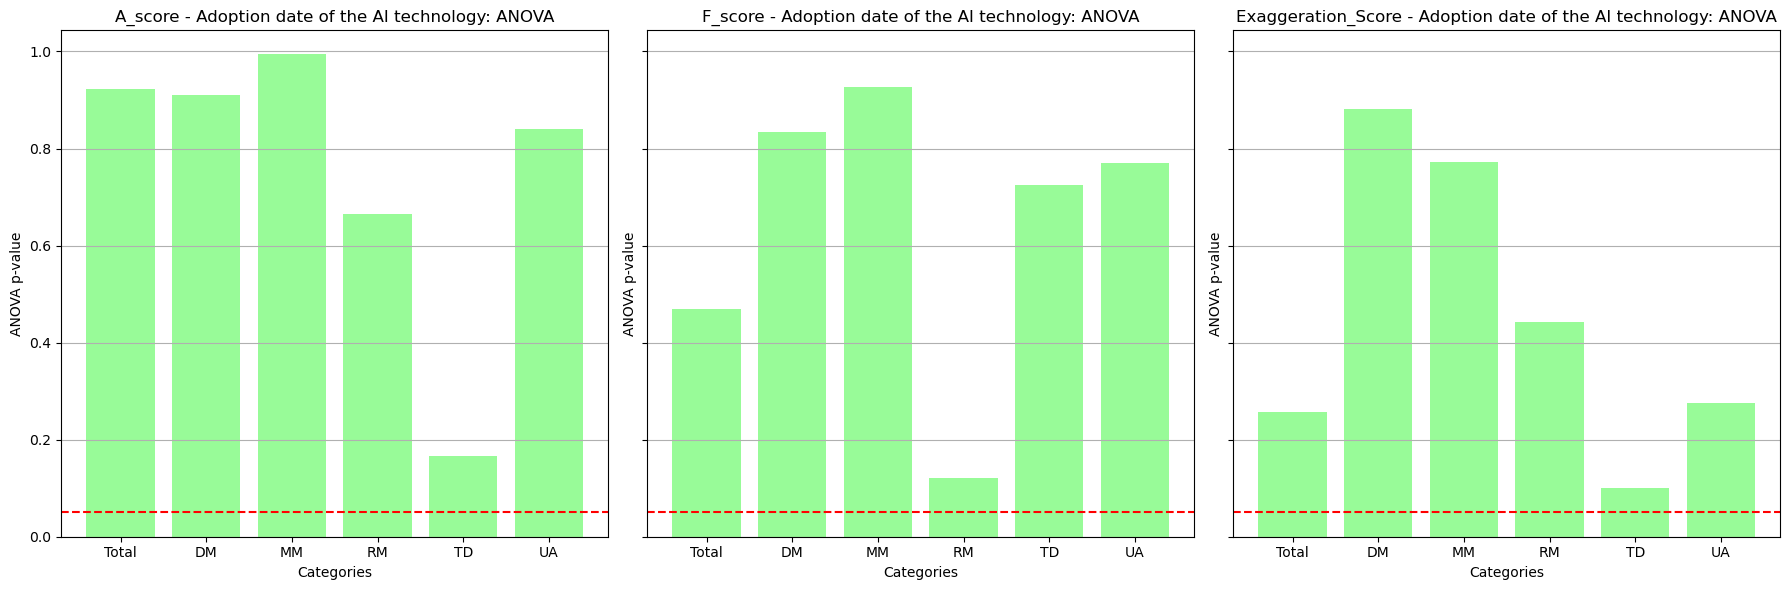

In [88]:
# Combine all P-values for the same category
combined_p_values = [
    Ap0_values_Total + Ap1_values_Total + Ap2_values_Total + Ap3_values_Total + Ap4_values_Total + Ap5_values_Total,
    Fp0_values_Total + Fp1_values_Total + Fp2_values_Total + Fp3_values_Total + Fp4_values_Total + Fp5_values_Total,
    Ep0_values_Total + Ep1_values_Total + Ep2_values_Total + Ep3_values_Total + Ep4_values_Total + Ep5_values_Total
]

# List of dataframes and their ANOVA p-values
dataframes = ['Total', 'DM', 'MM', 'RM', 'TD', 'UA']
custom_labels = ['A_score', 'F_score', 'Exaggeration_Score']

# Plotting the combined ANOVA p-values for each category in subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, values in enumerate(combined_p_values):
    axes[i].bar(dataframes, values, color='palegreen')
    axes[i].set_title(f'{custom_labels[i]} - Adoption date of the AI technology: ANOVA')
    axes[i].set_xlabel('Categories')
    axes[i].set_ylabel('ANOVA p-value')
    axes[i].axhline(y=0.05, color='red', linestyle='--', label='Significance Level (0.05)')
    axes[i].grid(axis='y')

plt.tight_layout()
plt.show()

# 4. Company's familiarity with the EU AI Act (Q16_NPS_GROUP): ANOVA <a id='section-4'></a>

## Total

Actual compliance
- $H_0$: The company's familiarity with the EU AI Act doesn't have an impact on the company's actual compliance 
- $H_a$: The company's familiarity with the EU AI Act has an impact on the company's actual compliance

In [89]:
ActualCompliance0 = smf.ols('A_score ~ Q16_NPS_GROUP', data = df).fit()
Actual_anova_table0 = sm.stats.anova_lm(ActualCompliance0)
print(Actual_anova_table0)

                 df    sum_sq   mean_sq         F    PR(>F)
Q16_NPS_GROUP   1.0  0.015035  0.015035  0.874952  0.357312
Residual       29.0  0.498331  0.017184       NaN       NaN


Perceived compliance (feeling)
- $H_0$: The company's familiarity with the EU AI Act doesn't have an impact on the company's perceived compliance
- $H_a$: The company's familiarity with the EU AI Act has an impact on the company's perceived compliance

In [90]:
FeelingCompliance0 = smf.ols('F_score ~ Q16_NPS_GROUP', data = df).fit()
Feeling_anova_table0 = sm.stats.anova_lm(FeelingCompliance0)
print(Feeling_anova_table0)

                 df    sum_sq   mean_sq         F    PR(>F)
Q16_NPS_GROUP   1.0  0.009179  0.009179  0.688107  0.413585
Residual       29.0  0.386828  0.013339       NaN       NaN


Exaggerated compliance
- $H_0$: The company's familiarity with the EU AI Act doesn't have an impact on the company's exaggerated compliance
- $H_a$: The company's familiarity with the EU AI Act has an impact on the company's exaggerated compliance

In [91]:
ExaggerationCompliance0 = smf.ols('Exaggeration_Score ~ Q16_NPS_GROUP', data = df).fit()
Exaggeration_anova_table0 = sm.stats.anova_lm(ExaggerationCompliance0)
print(Exaggeration_anova_table0)

                 df    sum_sq   mean_sq         F    PR(>F)
Q16_NPS_GROUP   1.0  0.008053  0.008053  0.552905  0.463115
Residual       29.0  0.422390  0.014565       NaN       NaN


## Categorie 1: Data Model

Actual compliance
- $H_0$: The company's familiarity with the EU AI Act doesn't have an impact on the company's actual compliance in the category Data Model
- $H_a$: The company's familiarity with the EU AI Act has an impact on the company's actual compliance in the category Data Model

In [92]:
ActualCompliance1 = smf.ols('A_score ~ Q16_NPS_GROUP', data = df_DataModel).fit()
Actual_anova_table1 = sm.stats.anova_lm(ActualCompliance1)
print(Actual_anova_table1)

                 df    sum_sq   mean_sq         F    PR(>F)
Q16_NPS_GROUP   1.0  0.020023  0.020023  2.184826  0.150157
Residual       29.0  0.265776  0.009165       NaN       NaN


Perceived compliance (feeling)
- $H_0$: The company's familiarity with the EU AI Act doesn't have an impact on the company's perceived compliance in the category Data Model
- $H_a$: The company's familiarity with the EU AI Act has an impact on the company's perceived compliance in the category Data Model

In [93]:
FeelingCompliance1 = smf.ols('F_score ~ Q16_NPS_GROUP', data = df_DataModel).fit()
Feeling_anova_table1 = sm.stats.anova_lm(FeelingCompliance1)
print(Feeling_anova_table1)

                 df    sum_sq   mean_sq         F    PR(>F)
Q16_NPS_GROUP   1.0  0.016085  0.016085  2.464518  0.127292
Residual       29.0  0.189276  0.006527       NaN       NaN


Exaggerated compliance
- $H_0$: The company's familiarity with the EU AI Act doesn't have an impact on the company's exaggerated compliance in the category Data Model
- $H_a$: The company's familiarity with the EU AI Act has an impact on the company's exaggerated compliance in the category Data Model

In [94]:
ExaggerationCompliance1 = smf.ols('Exaggeration_Score ~ Q16_NPS_GROUP', data = df_DataModel).fit()
Exaggeration_anova_table1 = sm.stats.anova_lm(ExaggerationCompliance1)
print(Exaggeration_anova_table1)

                 df    sum_sq   mean_sq         F    PR(>F)
Q16_NPS_GROUP   1.0  0.005158  0.005158  0.503897  0.483462
Residual       29.0  0.296868  0.010237       NaN       NaN


## Categorie 2: Model Monitoring

Actual compliance
- $H_0$: The company's familiarity with the EU AI Act doesn't have an impact on the company's actual compliance in Model Monotoring
- $H_a$: The company's familiarity with the EU AI Act has an impact on the company's actual compliance in Model Monotoring

In [95]:
ActualCompliance2 = smf.ols('A_score ~ Q16_NPS_GROUP', data = df_ModelMonitoring).fit()
Actual_anova_table2 = sm.stats.anova_lm(ActualCompliance2)
print(Actual_anova_table2)

                 df    sum_sq   mean_sq         F    PR(>F)
Q16_NPS_GROUP   1.0  0.020526  0.020526  0.773464  0.386377
Residual       29.0  0.769588  0.026538       NaN       NaN


Perceived compliance (feeling)
- $H_0$: The company's familiarity with the EU AI Act doesn't have an impact on the company's perceived compliance in the category Model Monitoring
- $H_a$: The company's familiarity with the EU AI Act has an impact on the company's perceived compliance in the category Data Model Monitoring

In [96]:
FeelingCompliance2 = smf.ols('F_score ~ Q16_NPS_GROUP', data = df_ModelMonitoring).fit()
Feeling_anova_table2 = sm.stats.anova_lm(FeelingCompliance2)
print(Feeling_anova_table2)

                 df    sum_sq   mean_sq         F    PR(>F)
Q16_NPS_GROUP   1.0  0.019463  0.019463  0.661945  0.422504
Residual       29.0  0.852691  0.029403       NaN       NaN


Exaggerated compliance
- $H_0$: The company's familiarity with the EU AI Act doesn't have an impact on the company's exaggerated compliance in the category Model Monitoring
- $H_a$: The company's familiarity with the EU AI Act has an impact on the company's exaggerated compliance in the category Model Monitoring

In [97]:
ExaggerationCompliance2 = smf.ols('Exaggeration_Score ~ Q16_NPS_GROUP', data = df_ModelMonitoring).fit()
Exaggeration_anova_table2 = sm.stats.anova_lm(ExaggerationCompliance2)
print(Exaggeration_anova_table2)

                 df    sum_sq   mean_sq         F    PR(>F)
Q16_NPS_GROUP   1.0  0.000991  0.000991  0.014112  0.906256
Residual       29.0  2.036724  0.070232       NaN       NaN


## Categorie 3: Risk Management

Actual compliance
- $H_0$: The company's familiarity with the EU AI Act doesn't have an impact on the company's actual compliance in Risk Management
- $H_a$: The company's familiarity with the EU AI Act has an impact on the company's actual compliance in Risk Management

In [98]:
ActualCompliance3 = smf.ols('A_score ~ Q16_NPS_GROUP', data = df_RiskManagement).fit()
Actual_anova_table3 = sm.stats.anova_lm(ActualCompliance3)
print(Actual_anova_table3)

                 df    sum_sq   mean_sq        F    PR(>F)
Q16_NPS_GROUP   1.0  0.126553  0.126553  1.43182  0.241159
Residual       29.0  2.563189  0.088386      NaN       NaN


Perceived compliance (feeling)
- $H_0$: The company's familiarity with the EU AI Act doesn't have an impact on the company's perceived compliance in the category Risk Management
- $H_a$: The company's familiarity with the EU AI Act has an impact on the company's perceived compliance Risk Management

In [99]:
FeelingCompliance3 = smf.ols('F_score ~ Q16_NPS_GROUP', data = df_RiskManagement).fit()
Feeling_anova_table3 = sm.stats.anova_lm(FeelingCompliance3)
print(Feeling_anova_table3)

                 df    sum_sq   mean_sq         F    PR(>F)
Q16_NPS_GROUP   1.0  0.005682  0.005682  0.075637  0.785249
Residual       29.0  2.178507  0.075121       NaN       NaN


Exaggerated compliance
- $H_0$: The company's familiarity with the EU AI Act doesn't have an impact on the company's exaggerated compliance in the category Risk Management
- $H_a$: The company's familiarity with the EU AI Act has an impact on the company's exaggerated compliance in the category Risk Management

In [100]:
ExaggerationCompliance3 = smf.ols('Exaggeration_Score ~ Q16_NPS_GROUP', data = df_RiskManagement).fit()
Exaggeration_anova_table3 = sm.stats.anova_lm(ExaggerationCompliance3)
print(Exaggeration_anova_table3)

                 df    sum_sq   mean_sq         F    PR(>F)
Q16_NPS_GROUP   1.0  0.241378  0.241378  3.253587  0.081666
Residual       29.0  2.151464  0.074188       NaN       NaN


## Categorie 4: Technical Documentation

Actual compliance
- $H_0$: The company's familiarity with the EU AI Act doesn't have an impact on the company's actual compliance in Technical Documentation
- $H_a$: The company's familiarity with the EU AI Act has an impact on the company's actual compliance in Technical Documentation

In [101]:
ActualCompliance4 = smf.ols('A_score ~ Q16_NPS_GROUP', data = df_TechnicalDocumentation).fit()
Actual_anova_table4 = sm.stats.anova_lm(ActualCompliance4)
print(Actual_anova_table4)

                 df    sum_sq   mean_sq         F    PR(>F)
Q16_NPS_GROUP   1.0  0.016828  0.016828  1.037535  0.316819
Residual       29.0  0.470351  0.016219       NaN       NaN


Perceived compliance (feeling)
- $H_0$: The company's familiarity with the EU AI Act doesn't have an impact on the company's perceived compliance in the category Technical Documentation
- $H_a$: The company's familiarity with the EU AI Act has an impact on the company's perceived compliance in the category Technical Documentation

In [102]:
FeelingCompliance4 = smf.ols('F_score ~ Q16_NPS_GROUP', data = df_TechnicalDocumentation).fit()
Feeling_anova_table4 = sm.stats.anova_lm(FeelingCompliance4)
print(Feeling_anova_table4)

                 df    sum_sq   mean_sq         F    PR(>F)
Q16_NPS_GROUP   1.0  0.019085  0.019085  1.279084  0.267336
Residual       29.0  0.432703  0.014921       NaN       NaN


Exaggerated compliance
- $H_0$: The company's familiarity with the EU AI Act doesn't have an impact on the company's exaggerated compliance in the category Technical Documentation
- $H_a$: The company's familiarity with the EU AI Act has an impact on the company's exaggerated compliance in the category Technical Documentation

In [103]:
ExaggerationCompliance4 = smf.ols('Exaggeration_Score ~ Q16_NPS_GROUP', data = df_TechnicalDocumentation).fit()
Exaggeration_anova_table4 = sm.stats.anova_lm(ExaggerationCompliance4)
print(Exaggeration_anova_table4)

                 df    sum_sq   mean_sq         F    PR(>F)
Q16_NPS_GROUP   1.0  0.000161  0.000161  0.003045  0.956371
Residual       29.0  1.532207  0.052835       NaN       NaN


## Categorie 5: User Application

Actual compliance
- $H_0$: The company's familiarity with the EU AI Act doesn't have an impact on the company's actual compliance in User Application 
- $H_a$: The company's familiarity with the EU AI Act has an impact on the company's actual compliance in User Application

In [104]:
ActualCompliance5 = smf.ols('A_score ~ Q16_NPS_GROUP', data = df_UserApplication).fit()
Actual_anova_table5 = sm.stats.anova_lm(ActualCompliance5)
print(Actual_anova_table5)

                 df    sum_sq   mean_sq         F    PR(>F)
Q16_NPS_GROUP   1.0  0.016741  0.016741  0.797859  0.379087
Residual       29.0  0.608494  0.020983       NaN       NaN


Perceived compliance (feeling)
- $H_0$: The company's familiarity with the EU AI Act doesn't have an impact on the company's perceived compliance in the category User Application
- $H_a$: The company's familiarity with the EU AI Act has an impact on the company's perceived compliance in the category User Application 

In [105]:
FeelingCompliance5 = smf.ols('F_score ~ Q16_NPS_GROUP', data = df_UserApplication).fit()
Feeling_anova_table5 = sm.stats.anova_lm(FeelingCompliance5)
print(Feeling_anova_table5)

                 df    sum_sq   mean_sq         F    PR(>F)
Q16_NPS_GROUP   1.0  0.077384  0.077384  3.106827  0.088502
Residual       29.0  0.722329  0.024908       NaN       NaN


Exaggerated compliance
- $H_0$: The company's familiarity with the EU AI Act doesn't have an impact on the company's exaggerated compliance in the category User Application
- $H_a$: The company's familiarity with the EU AI Act has an impact on the company's exaggerated compliance in the category User Application

In [106]:
ExaggerationCompliance5 = smf.ols('Exaggeration_Score ~ Q16_NPS_GROUP', data = df_UserApplication).fit()
Exaggeration_anova_table5 = sm.stats.anova_lm(ExaggerationCompliance5)
print(Exaggeration_anova_table5)

                 df    sum_sq   mean_sq         F    PR(>F)
Q16_NPS_GROUP   1.0  0.006745  0.006745  0.295191  0.591065
Residual       29.0  0.662632  0.022849       NaN       NaN


## Conclusion: Company's familiarity with the EU AI Act (Q16_NPS_GROUP)

In [107]:
# Extracting p-values from the ANOVA tables for Category 'Total'
Ap0_values_Total = [Actual_anova_table0['PR(>F)']['Q16_NPS_GROUP']]
Fp0_values_Total = [Feeling_anova_table0['PR(>F)']['Q16_NPS_GROUP']]
Ep0_values_Total = [Exaggeration_anova_table0['PR(>F)']['Q16_NPS_GROUP']]


Ap1_values_Total = [Actual_anova_table1['PR(>F)']['Q16_NPS_GROUP']]
Fp1_values_Total = [Feeling_anova_table1['PR(>F)']['Q16_NPS_GROUP']]
Ep1_values_Total = [Exaggeration_anova_table1['PR(>F)']['Q16_NPS_GROUP']]

Ap2_values_Total = [Actual_anova_table2['PR(>F)']['Q16_NPS_GROUP']]
Fp2_values_Total = [Feeling_anova_table2['PR(>F)']['Q16_NPS_GROUP']]
Ep2_values_Total = [Exaggeration_anova_table2['PR(>F)']['Q16_NPS_GROUP']]

Ap3_values_Total = [Actual_anova_table3['PR(>F)']['Q16_NPS_GROUP']]
Fp3_values_Total = [Feeling_anova_table3['PR(>F)']['Q16_NPS_GROUP']]
Ep3_values_Total = [Exaggeration_anova_table3['PR(>F)']['Q16_NPS_GROUP']]

Ap4_values_Total = [Actual_anova_table4['PR(>F)']['Q16_NPS_GROUP']]
Fp4_values_Total = [Feeling_anova_table4['PR(>F)']['Q16_NPS_GROUP']]
Ep4_values_Total = [Exaggeration_anova_table4['PR(>F)']['Q16_NPS_GROUP']]

Ap5_values_Total = [Actual_anova_table5['PR(>F)']['Q16_NPS_GROUP']]
Fp5_values_Total = [Feeling_anova_table5['PR(>F)']['Q16_NPS_GROUP']]
Ep5_values_Total = [Exaggeration_anova_table5['PR(>F)']['Q16_NPS_GROUP']]

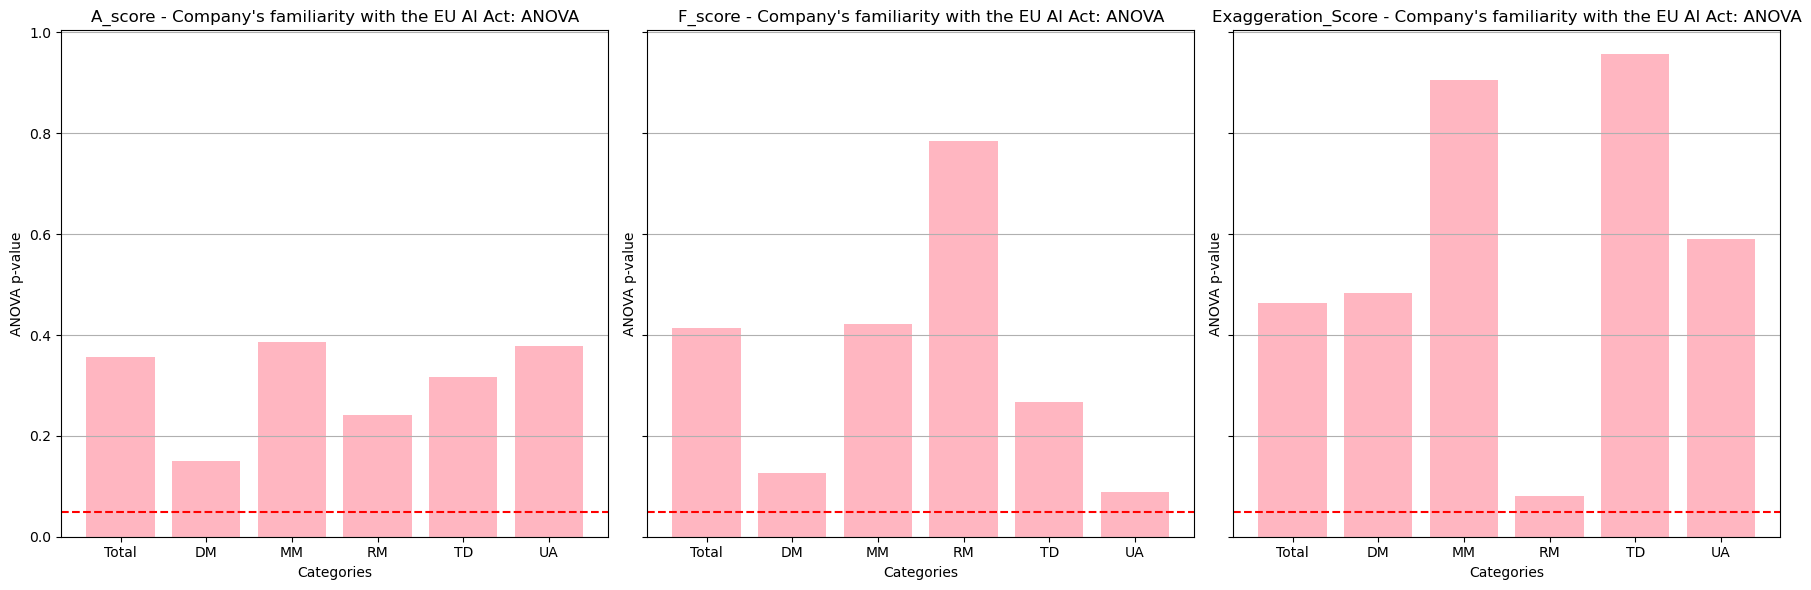

In [108]:
# Combine all P-values for the same category
combined_p_values = [
    Ap0_values_Total + Ap1_values_Total + Ap2_values_Total + Ap3_values_Total + Ap4_values_Total + Ap5_values_Total,
    Fp0_values_Total + Fp1_values_Total + Fp2_values_Total + Fp3_values_Total + Fp4_values_Total + Fp5_values_Total,
    Ep0_values_Total + Ep1_values_Total + Ep2_values_Total + Ep3_values_Total + Ep4_values_Total + Ep5_values_Total
]

# List of dataframes and their ANOVA p-values
dataframes = ['Total', 'DM', 'MM', 'RM', 'TD', 'UA']
custom_labels = ['A_score', 'F_score', 'Exaggeration_Score']

# Plotting the combined ANOVA p-values for each category in subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, values in enumerate(combined_p_values):
    axes[i].bar(dataframes, values, color='lightpink')
    axes[i].set_title(f'{custom_labels[i]} - Company\'s familiarity with the EU AI Act: ANOVA')
    axes[i].set_xlabel('Categories')
    axes[i].set_ylabel('ANOVA p-value')
    axes[i].axhline(y=0.05, color='red', linestyle='--', label='Significance Level (0.05)')
    axes[i].grid(axis='y')

plt.tight_layout()
plt.show()

# 5. The degree to which a company offshores (operates outside Europe)(Q23): Linear Regression <a id='section-5'></a>

## Total

Actual compliance
- $H_0$: The degree to which a company offshores doesn't have an impact on the company's actual compliance 
- $H_a$: The degree to which a company offshores has an impact on the company's actual compliance

In [109]:
# Moving columns to separate lists
x1 = df.Q23.to_list()
y = df.A_score.to_list()

#Calculate b0, b1, b2 and r-square
x1_data = np.array(x1).reshape((-1,1))
y_data = np.array(y)
model1 = LinearRegression().fit(x1_data, y_data)
b0 = model1.intercept_
b1 = model1.coef_
print("b0 = ", b0)
print("b1 = ", b1)
r_sq = model1.score(x1_data, y_data)
print("Coefficent of Determination = ",r_sq)

#Calculate the predicted values of y
y_pred = b0 + b1 * x1
print(y_pred)

#Calculate SSE and MSE
MSE = mean_squared_error(y, y_pred)
print("SSE = ", MSE*len(y))
MSE = MSE*len(y)/(len(y)-2)
print("MSE = ", MSE)

#Calculate MSR
SSR = 0
y_avg = np.mean(y)
print ("y_avg =", y_avg)
for i in y_pred:
    SSR = SSR + ((i-y_avg)*(i-y_avg))
MSR = SSR/1
print ("MSR = ", MSR)

#Devide MSR by MSE to calculate F-score
Q23_F0_A = MSR/MSE
print("F-score =", Q23_F0_A)

#Calculate critical value
df1 = 1  # Numerator degrees of freedom; independent variables
df2 = 16  # Denominator degrees of freedom
alpha = 0.05  # Significance level
critical_value = stats.f.ppf(1 - alpha, dfn=df1, dfd=df2)
print("Critical Value =", critical_value)

#Final answer
# To interpret this value, you need to compare it to the critial value with an appropriate degrees of freedom and significance level (alpha)
if Q23_F0_A > critical_value :   
    print("The null hypthesis is rejected")
else :
    print("The null hypthesis is not rejected")

b0 =  0.5685649492862265
b1 =  [0.00093165]
Coefficent of Determination =  0.0005671115093568435
[0.56856495 0.56856495 0.57042825 0.57229156 0.57601817 0.57415486
 0.56856495 0.56856495 0.56856495 0.57508652 0.57042825 0.56856495
 0.56856495 0.56856495 0.57322321 0.57601817 0.57135991 0.57694982
 0.56856495 0.56856495 0.56856495 0.57135991 0.5694966  0.57322321
 0.57694982 0.56856495 0.56856495 0.56856495 0.56856495 0.57322321
 0.57694982]
SSE =  0.5130752899171759
MSE =  0.01769225137645434
y_avg = 0.5711495333348393
MSR =  0.00029113600865993605
F-score = 0.016455565912170636
Critical Value = 4.493998477666352
The null hypthesis is not rejected


Perceived compliance (feeling)
- $H_0$: The degree to which a company offshores doesn't have an impact on the company's perceived compliance
- $H_a$: The degree to which a company offshores has an impact on the company's perceived compliance

In [110]:
# Moving columns to separate lists
x1 = df.Q23.to_list()
y = df.F_score.to_list()

#Calculate b0, b1, b2 and r-square
x1_data = np.array(x1).reshape((-1,1))
y_data = np.array(y)
model1 = LinearRegression().fit(x1_data, y_data)
b0 = model1.intercept_
b1 = model1.coef_
print("b0 = ", b0)
print("b1 = ", b1)
r_sq = model1.score(x1_data, y_data)
print("Coefficent of Determination = ",r_sq)

#Calculate the predicted values of y
y_pred = b0 + b1 * x1
print(y_pred)

#Calculate SSE and MSE
MSE = mean_squared_error(y, y_pred)
print("SSE = ", MSE*len(y))
MSE = MSE*len(y)/(len(y)-2)
print("MSE = ", MSE)

#Calculate MSR
SSR = 0
y_avg = np.mean(y)
print ("y_avg =", y_avg)
for i in y_pred:
    SSR = SSR + ((i-y_avg)*(i-y_avg))
MSR = SSR/1
print ("MSR = ", MSR)

#Devide MSR by MSE to calculate F-score
Q23_F0_F = MSR/MSE
print("F-score =", Q23_F0_F)

#Calculate critical value
df1 = 1  # Numerator degrees of freedom; independent variables
df2 = 16  # Denominator degrees of freedom
alpha = 0.05  # Significance level
critical_value = stats.f.ppf(1 - alpha, dfn=df1, dfd=df2)
print("Critical Value =", critical_value)

#Final answer
# To interpret this value, you need to compare it to the critial value with an appropriate degrees of freedom and significance level (alpha)
if Q23_F0_F > critical_value :   
    print("The null hypthesis is rejected")
else :
    print("The null hypthesis is not rejected")

b0 =  0.6956128995280756
b1 =  [0.00425805]
Coefficent of Determination =  0.01535700496379322
[0.6956129  0.6956129  0.70412899 0.71264509 0.72967727 0.72116118
 0.6956129  0.6956129  0.6956129  0.72541923 0.70412899 0.6956129
 0.6956129  0.6956129  0.71690313 0.72967727 0.70838704 0.73393532
 0.6956129  0.6956129  0.6956129  0.70838704 0.69987095 0.71690313
 0.73393532 0.6956129  0.6956129  0.6956129  0.6956129  0.71690313
 0.73393532]
SSE =  0.3899251720740589
MSE =  0.013445695588760652
y_avg = 0.7074255457803845
MSR =  0.006081476061106805
F-score = 0.45229910352799835
Critical Value = 4.493998477666352
The null hypthesis is not rejected


Exaggerated compliance
- $H_0$: The degree to which a company offshores doesn't have an impact on the company's exaggerated compliance
- $H_a$: The degree to which a company offshores has an impact on the company's exaggerated compliance

In [111]:
# Moving columns to separate lists
x1 = df.Q23.to_list()
y = df.Exaggeration_Score.to_list()

#Calculate b0, b1, b2 and r-square
x1_data = np.array(x1).reshape((-1,1))
y_data = np.array(y)
model1 = LinearRegression().fit(x1_data, y_data)
b0 = model1.intercept_
b1 = model1.coef_
print("b0 = ", b0)
print("b1 = ", b1)
r_sq = model1.score(x1_data, y_data)
print("Coefficent of Determination = ",r_sq)

#Calculate the predicted values of y
y_pred = b0 + b1 * x1
print(y_pred)

#Calculate SSE and MSE
MSE = mean_squared_error(y, y_pred)
print("SSE = ", MSE*len(y))
MSE = MSE*len(y)/(len(y)-2)
print("MSE = ", MSE)

#Calculate MSR
SSR = 0
y_avg = np.mean(y)
print ("y_avg =", y_avg)
for i in y_pred:
    SSR = SSR + ((i-y_avg)*(i-y_avg))
MSR = SSR/1
print ("MSR = ", MSR)

#Devide MSR by MSE to calculate F-score
Q23_F0_E = MSR/MSE
print("F-score =", Q23_F0_E)

#Calculate critical value
df1 = 1  # Numerator degrees of freedom; independent variables
df2 = 16  # Denominator degrees of freedom
alpha = 0.05  # Significance level
critical_value = stats.f.ppf(1 - alpha, dfn=df1, dfd=df2)
print("Critical Value =", critical_value)

#Final answer
# To interpret this value, you need to compare it to the critial value with an appropriate degrees of freedom and significance level (alpha)
if Q23_F0_E > critical_value :   
    print("The null hypthesis is rejected")
else :
    print("The null hypthesis is not rejected")

b0 =  0.8123025417960814
b1 =  [-0.00374111]
Coefficent of Determination =  0.010906204097632766
[0.81230254 0.81230254 0.80482032 0.79733809 0.78237364 0.78985587
 0.81230254 0.81230254 0.81230254 0.78611476 0.80482032 0.81230254
 0.81230254 0.81230254 0.79359698 0.78237364 0.80107921 0.77863253
 0.81230254 0.81230254 0.81230254 0.80107921 0.80856143 0.79359698
 0.77863253 0.81230254 0.81230254 0.81230254 0.81230254 0.79359698
 0.77863253]
SSE =  0.42574880532741727
MSE =  0.014680993287152319
y_avg = 0.8019239725264758
MSR =  0.004694502568371658
F-score = 0.3197673669996108
Critical Value = 4.493998477666352
The null hypthesis is not rejected


## Categorie 1: Data Model

Actual compliance
- $H_0$: The degree to which a company offshores doesn't have an impact on the company's actual compliance in the category Data Model
- $H_a$: The degree to which a company offshores has an impact on the company's actual compliance in the category Data Model

In [112]:
# Moving columns to separate lists
x1 = df_DataModel.Q23.to_list()
y = df_DataModel.A_score.to_list()

#Calculate b0, b1, b2 and r-square
x1_data = np.array(x1).reshape((-1,1))
y_data = np.array(y)
model1 = LinearRegression().fit(x1_data, y_data)
b0 = model1.intercept_
b1 = model1.coef_
print("b0 = ", b0)
print("b1 = ", b1)
r_sq = model1.score(x1_data, y_data)
print("Coefficent of Determination = ",r_sq)

#Calculate the predicted values of y
y_pred = b0 + b1 * x1
print(y_pred)

#Calculate SSE and MSE
MSE = mean_squared_error(y, y_pred)
print("SSE = ", MSE*len(y))
MSE = MSE*len(y)/(len(y)-2)
print("MSE = ", MSE)

#Calculate MSR
SSR = 0
y_avg = np.mean(y)
print ("y_avg =", y_avg)
for i in y_pred:
    SSR = SSR + ((i-y_avg)*(i-y_avg))
MSR = SSR/1
print ("MSR = ", MSR)

#Devide MSR by MSE to calculate F-score
Q23_F1_A = MSR/MSE
print("F-score =", Q23_F1_A)

#Calculate critical value
df1 = 1  # Numerator degrees of freedom; independent variables
df2 = 16  # Denominator degrees of freedom
alpha = 0.05  # Significance level
critical_value = stats.f.ppf(1 - alpha, dfn=df1, dfd=df2)
print("Critical Value =", critical_value)

#Final answer
# To interpret this value, you need to compare it to the critial value with an appropriate degrees of freedom and significance level (alpha)
if Q23_F1_A > critical_value :   
    print("The null hypthesis is rejected")
else :
    print("The null hypthesis is not rejected")

b0 =  0.5630854349818404
b1 =  [-0.00428137]
Coefficent of Determination =  0.021512506367015405
[0.56308543 0.56308543 0.5545227  0.54595997 0.5288345  0.53739724
 0.56308543 0.56308543 0.56308543 0.53311587 0.5545227  0.56308543
 0.56308543 0.56308543 0.5416786  0.5288345  0.55024134 0.52455314
 0.56308543 0.56308543 0.56308543 0.55024134 0.55880407 0.5416786
 0.52455314 0.56308543 0.56308543 0.56308543 0.56308543 0.5416786
 0.52455314]
SSE =  0.27965150724354093
MSE =  0.009643155422191067
y_avg = 0.5512080961416824
MSR =  0.006148269517258221
F-score = 0.6375785982988174
Critical Value = 4.493998477666352
The null hypthesis is not rejected


Perceived compliance (feeling)
- $H_0$: The degree to which a company offshores doesn't have an impact on the company's perceived compliance in the category Data Model
- $H_a$: The degree to which a company offshores has an impact on the company's perceived compliance in the category Data Model

In [114]:
# Moving columns to separate lists
x1 = df_DataModel.Q23.to_list()
y = df_DataModel.F_score.to_list()

#Calculate b0, b1, b2 and r-square
x1_data = np.array(x1).reshape((-1,1))
y_data = np.array(y)
model1 = LinearRegression().fit(x1_data, y_data)
b0 = model1.intercept_
b1 = model1.coef_
print("b0 = ", b0)
print("b1 = ", b1)
r_sq = model1.score(x1_data, y_data)
print("Coefficent of Determination = ",r_sq)

#Calculate the predicted values of y
y_pred = b0 + b1 * x1
print(y_pred)

#Calculate SSE and MSE
MSE = mean_squared_error(y, y_pred)
print("SSE = ", MSE*len(y))
MSE = MSE*len(y)/(len(y)-2)
print("MSE = ", MSE)

#Calculate MSR
SSR = 0
y_avg = np.mean(y)
print ("y_avg =", y_avg)
for i in y_pred:
    SSR = SSR + ((i-y_avg)*(i-y_avg))
MSR = SSR/1
print ("MSR = ", MSR)

#Devide MSR by MSE to calculate F-score
Q23_F1_F = MSR/MSE
print("F-score =", Q23_F1_F)

#Calculate critical value
df1 = 1  # Numerator degrees of freedom; independent variables
df2 = 16  # Denominator degrees of freedom
alpha = 0.05  # Significance level
critical_value = stats.f.ppf(1 - alpha, dfn=df1, dfd=df2)
print("Critical Value =", critical_value)

#Final answer
# To interpret this value, you need to compare it to the critial value with an appropriate degrees of freedom and significance level (alpha)
if Q23_F1_F > critical_value :   
    print("The null hypthesis is rejected")
else :
    print("The null hypthesis is not rejected")

b0 =  0.7813787033637006
b1 =  [0.00227258]
Coefficent of Determination =  0.008435444588107521
[0.7813787  0.7813787  0.78592387 0.79046903 0.79955936 0.79501419
 0.7813787  0.7813787  0.7813787  0.79728677 0.78592387 0.7813787
 0.7813787  0.7813787  0.79274161 0.79955936 0.78819645 0.80183194
 0.7813787  0.7813787  0.7813787  0.78819645 0.78365128 0.79274161
 0.80183194 0.7813787  0.7813787  0.7813787  0.7813787  0.79274161
 0.80183194]
SSE =  0.20362921738675813
MSE =  0.007021697151267521
y_avg = 0.7876832844574782
MSR =  0.0017323158340125811
F-score = 0.24670899309576064
Critical Value = 4.493998477666352
The null hypthesis is not rejected


Exaggerated compliance
- $H_0$: The degree to which a company offshores doesn't have an impact on the company's exaggerated compliance in the category Data Model
- $H_a$: The degree to which a company offshores has an impact on the company's exaggerated compliance in the category Data Model

In [115]:
# Moving columns to separate lists
x1 = df_DataModel.Q23.to_list()
y = df_DataModel.Exaggeration_Score.to_list()

#Calculate b0, b1, b2 and r-square
x1_data = np.array(x1).reshape((-1,1))
y_data = np.array(y)
model1 = LinearRegression().fit(x1_data, y_data)
b0 = model1.intercept_
b1 = model1.coef_
print("b0 = ", b0)
print("b1 = ", b1)
r_sq = model1.score(x1_data, y_data)
print("Coefficent of Determination = ",r_sq)

#Calculate the predicted values of y
y_pred = b0 + b1 * x1
print(y_pred)

#Calculate SSE and MSE
MSE = mean_squared_error(y, y_pred)
print("SSE = ", MSE*len(y))
MSE = MSE*len(y)/(len(y)-2)
print("MSE = ", MSE)

#Calculate MSR
SSR = 0
y_avg = np.mean(y)
print ("y_avg =", y_avg)
for i in y_pred:
    SSR = SSR + ((i-y_avg)*(i-y_avg))
MSR = SSR/1
print ("MSR = ", MSR)

#Devide MSR by MSE to calculate F-score
Q23_F1_E = MSR/MSE
print("F-score =", Q23_F1_E)

#Calculate critical value
df1 = 1  # Numerator degrees of freedom; independent variables
df2 = 16  # Denominator degrees of freedom
alpha = 0.05  # Significance level
critical_value = stats.f.ppf(1 - alpha, dfn=df1, dfd=df2)
print("Critical Value =", critical_value)

#Final answer
# To interpret this value, you need to compare it to the critial value with an appropriate degrees of freedom and significance level (alpha)
if Q23_F1_E > critical_value :   
    print("The null hypthesis is rejected")
else :
    print("The null hypthesis is not rejected")

b0 =  0.7200529210934851
b1 =  [-0.00745858]
Coefficent of Determination =  0.06178106673073902
[0.72005292 0.72005292 0.70513576 0.6902186  0.66038429 0.67530145
 0.72005292 0.72005292 0.72005292 0.66784287 0.70513576 0.72005292
 0.72005292 0.72005292 0.68276002 0.66038429 0.69767718 0.65292571
 0.72005292 0.72005292 0.72005292 0.69767718 0.71259434 0.68276002
 0.65292571 0.72005292 0.72005292 0.72005292 0.72005292 0.68276002
 0.65292571]
SSE =  0.2833669086642643
MSE =  0.009771272712560838
y_avg = 0.6993613785205147
MSR =  0.018659514610803313
F-score = 1.909629907966519
Critical Value = 4.493998477666352
The null hypthesis is not rejected


## Categorie 2: Model Monitoring

Actual compliance
- $H_0$: The degree to which a company offshores doesn't have an impact on the company's actual compliance in the category Model Monotoring
- $H_a$: The degree to which a company offshores has an impact on the company's actual compliance in the category Model Monotoring

In [116]:
# Moving columns to separate lists
x1 = df_ModelMonitoring.Q23.to_list()
y = df_ModelMonitoring.A_score.to_list()

#Calculate b0, b1, b2 and r-square
x1_data = np.array(x1).reshape((-1,1))
y_data = np.array(y)
model1 = LinearRegression().fit(x1_data, y_data)
b0 = model1.intercept_
b1 = model1.coef_
print("b0 = ", b0)
print("b1 = ", b1)
r_sq = model1.score(x1_data, y_data)
print("Coefficent of Determination = ",r_sq)

#Calculate the predicted values of y
y_pred = b0 + b1 * x1
print(y_pred)

#Calculate SSE and MSE
MSE = mean_squared_error(y, y_pred)
print("SSE = ", MSE*len(y))
MSE = MSE*len(y)/(len(y)-2)
print("MSE = ", MSE)

#Calculate MSR
SSR = 0
y_avg = np.mean(y)
print ("y_avg =", y_avg)
for i in y_pred:
    SSR = SSR + ((i-y_avg)*(i-y_avg))
MSR = SSR/1
print ("MSR = ", MSR)

#Devide MSR by MSE to calculate F-score
Q23_F2_A = MSR/MSE
print("F-score =", Q23_F2_A)

#Calculate critical value
df1 = 1  # Numerator degrees of freedom; independent variables
df2 = 16  # Denominator degrees of freedom
alpha = 0.05  # Significance level
critical_value = stats.f.ppf(1 - alpha, dfn=df1, dfd=df2)
print("Critical Value =", critical_value)

#Final answer
# To interpret this value, you need to compare it to the critial value with an appropriate degrees of freedom and significance level (alpha)
if Q23_F2_A > critical_value :   
    print("The null hypthesis is rejected")
else :
    print("The null hypthesis is not rejected")

b0 =  0.6634426950237684
b1 =  [-0.00904482]
Coefficent of Determination =  0.03472947326304321
[0.6634427  0.6634427  0.64535306 0.62726342 0.59108414 0.60917378
 0.6634427  0.6634427  0.6634427  0.60012896 0.64535306 0.6634427
 0.6634427  0.6634427  0.6182186  0.59108414 0.63630824 0.58203932
 0.6634427  0.6634427  0.6634427  0.63630824 0.65439788 0.6182186
 0.58203932 0.6634427  0.6634427  0.6634427  0.6634427  0.6182186
 0.58203932]
SSE =  0.7626737536348813
MSE =  0.02629909495292694
y_avg = 0.6383506144393242
MSR =  0.027440242918041216
F-score = 1.0433911496633945
Critical Value = 4.493998477666352
The null hypthesis is not rejected


Perceived compliance (feeling)
- $H_0$: The degree to which a company offshores doesn't have an impact on the company's perceived compliance in the category Model Monitoring
- $H_a$: The degree to which a company offshores has an impact on the company's perceived compliance in the category Model Monitoring

In [117]:
# Moving columns to separate lists
x1 = df_ModelMonitoring.Q23.to_list()
y = df_ModelMonitoring.F_score.to_list()

#Calculate b0, b1, b2 and r-square
x1_data = np.array(x1).reshape((-1,1))
y_data = np.array(y)
model1 = LinearRegression().fit(x1_data, y_data)
b0 = model1.intercept_
b1 = model1.coef_
print("b0 = ", b0)
print("b1 = ", b1)
r_sq = model1.score(x1_data, y_data)
print("Coefficent of Determination = ",r_sq)

#Calculate the predicted values of y
y_pred = b0 + b1 * x1
print(y_pred)

#Calculate SSE and MSE
MSE = mean_squared_error(y, y_pred)
print("SSE = ", MSE*len(y))
MSE = MSE*len(y)/(len(y)-2)
print("MSE = ", MSE)

#Calculate MSR
SSR = 0
y_avg = np.mean(y)
print ("y_avg =", y_avg)
for i in y_pred:
    SSR = SSR + ((i-y_avg)*(i-y_avg))
MSR = SSR/1
print ("MSR = ", MSR)

#Devide MSR by MSE to calculate F-score
Q23_F2_F = MSR/MSE
print("F-score =", Q23_F2_F)

#Calculate critical value
df1 = 1  # Numerator degrees of freedom; independent variables
df2 = 16  # Denominator degrees of freedom
alpha = 0.05  # Significance level
critical_value = stats.f.ppf(1 - alpha, dfn=df1, dfd=df2)
print("Critical Value =", critical_value)

#Final answer
# To interpret this value, you need to compare it to the critial value with an appropriate degrees of freedom and significance level (alpha)
if Q23_F2_F > critical_value :   
    print("The null hypthesis is rejected")
else :
    print("The null hypthesis is not rejected")

b0 =  0.7236641661858051
b1 =  [-0.00845259]
Coefficent of Determination =  0.027477308157700553
[0.72366417 0.72366417 0.70675899 0.68985382 0.65604347 0.67294864
 0.72366417 0.72366417 0.72366417 0.66449606 0.70675899 0.72366417
 0.72366417 0.72366417 0.68140123 0.65604347 0.69830641 0.64759088
 0.72366417 0.72366417 0.72366417 0.69830641 0.71521158 0.68140123
 0.64759088 0.72366417 0.72366417 0.72366417 0.72366417 0.68140123
 0.64759088]
SSE =  0.8481896742963391
MSE =  0.029247919803322038
y_avg = 0.700215053763441
MSR =  0.02396444756746026
F-score = 0.8193556235318428
Critical Value = 4.493998477666352
The null hypthesis is not rejected


Exaggerated compliance
- $H_0$: The degree to which a company offshores doesn't have an impact on the company's exaggerated compliance in the category Model Monitoring
- $H_a$: The degree to which a company offshores has an impact on the company's exaggerated compliance in the category Model Monitoring

In [118]:
# Moving columns to separate lists
x1 = df_ModelMonitoring.Q23.to_list()
y = df_ModelMonitoring.Exaggeration_Score.to_list()

#Calculate b0, b1, b2 and r-square
x1_data = np.array(x1).reshape((-1,1))
y_data = np.array(y)
model1 = LinearRegression().fit(x1_data, y_data)
b0 = model1.intercept_
b1 = model1.coef_
print("b0 = ", b0)
print("b1 = ", b1)
r_sq = model1.score(x1_data, y_data)
print("Coefficent of Determination = ",r_sq)

#Calculate the predicted values of y
y_pred = b0 + b1 * x1
print(y_pred)

#Calculate SSE and MSE
MSE = mean_squared_error(y, y_pred)
print("SSE = ", MSE*len(y))
MSE = MSE*len(y)/(len(y)-2)
print("MSE = ", MSE)

#Calculate MSR
SSR = 0
y_avg = np.mean(y)
print ("y_avg =", y_avg)
for i in y_pred:
    SSR = SSR + ((i-y_avg)*(i-y_avg))
MSR = SSR/1
print ("MSR = ", MSR)

#Devide MSR by MSE to calculate F-score
Q23_F2_E = MSR/MSE
print("F-score =", Q23_F2_E)

#Calculate critical value
df1 = 1  # Numerator degrees of freedom; independent variables
df2 = 16  # Denominator degrees of freedom
alpha = 0.05  # Significance level
critical_value = stats.f.ppf(1 - alpha, dfn=df1, dfd=df2)
print("Critical Value =", critical_value)

#Final answer
# To interpret this value, you need to compare it to the critial value with an appropriate degrees of freedom and significance level (alpha)
if Q23_F2_E > critical_value :   
    print("The null hypthesis is rejected")
else :
    print("The null hypthesis is not rejected")

b0 =  0.9413263854306911
b1 =  [-0.00248524]
Coefficent of Determination =  0.0010166718263477925
[0.94132639 0.94132639 0.93635591 0.93138543 0.92144448 0.92641495
 0.94132639 0.94132639 0.94132639 0.92392972 0.93635591 0.94132639
 0.94132639 0.94132639 0.92890019 0.92144448 0.93387067 0.91895924
 0.94132639 0.94132639 0.94132639 0.93387067 0.93884115 0.92890019
 0.91895924 0.94132639 0.94132639 0.94132639 0.94132639 0.92890019
 0.91895924]
SSE =  2.0356435011394134
MSE =  0.07019460348756598
y_avg = 0.9344318527673403
MSR =  0.002071687622535686
F-score = 0.029513488496343703
Critical Value = 4.493998477666352
The null hypthesis is not rejected


## Categorie 3: Risk Management

Actual compliance
- $H_0$: The degree to which a company offshores doesn't have an impact on the company's actual compliance in the category Risk Management
- $H_a$: The degree to which a company offshores has an impact on the company's actual compliance in the category Risk Management

In [119]:
# Moving columns to separate lists
x1 = df_RiskManagement.Q23.to_list()
y = df_RiskManagement.A_score.to_list()

#Calculate b0, b1, b2 and r-square
x1_data = np.array(x1).reshape((-1,1))
y_data = np.array(y)
model1 = LinearRegression().fit(x1_data, y_data)
b0 = model1.intercept_
b1 = model1.coef_
print("b0 = ", b0)
print("b1 = ", b1)
r_sq = model1.score(x1_data, y_data)
print("Coefficent of Determination = ",r_sq)

#Calculate the predicted values of y
y_pred = b0 + b1 * x1
print(y_pred)

#Calculate SSE and MSE
MSE = mean_squared_error(y, y_pred)
print("SSE = ", MSE*len(y))
MSE = MSE*len(y)/(len(y)-2)
print("MSE = ", MSE)

#Calculate MSR
SSR = 0
y_avg = np.mean(y)
print ("y_avg =", y_avg)
for i in y_pred:
    SSR = SSR + ((i-y_avg)*(i-y_avg))
MSR = SSR/1
print ("MSR = ", MSR)

#Devide MSR by MSE to calculate F-score
Q23_F3_A = MSR/MSE
print("F-score =", Q23_F3_A)

#Calculate critical value
df1 = 1  # Numerator degrees of freedom; independent variables
df2 = 16  # Denominator degrees of freedom
alpha = 0.05  # Significance level
critical_value = stats.f.ppf(1 - alpha, dfn=df1, dfd=df2)
print("Critical Value =", critical_value)

#Final answer
# To interpret this value, you need to compare it to the critial value with an appropriate degrees of freedom and significance level (alpha)
if Q23_F3_A > critical_value :   
    print("The null hypthesis is rejected")
else :
    print("The null hypthesis is not rejected")

b0 =  0.7409401447393732
b1 =  [0.00196307]
Coefficent of Determination =  0.00048056297826559735
[0.74094014 0.74094014 0.74486629 0.74879244 0.75664473 0.75271858
 0.74094014 0.74094014 0.74094014 0.75468165 0.74486629 0.74094014
 0.74094014 0.74094014 0.75075551 0.75664473 0.74682936 0.7586078
 0.74094014 0.74094014 0.74094014 0.74682936 0.74290322 0.75075551
 0.7586078  0.74094014 0.74094014 0.74094014 0.74094014 0.75075551
 0.7586078 ]
SSE =  2.6884494542430977
MSE =  0.09270515359458957
y_avg = 0.7463860887096776
MSR =  0.0012925904477628337
F-score = 0.013943026872222037
Critical Value = 4.493998477666352
The null hypthesis is not rejected


Perceived compliance (feeling)
- $H_0$: The degree to which a company offshores doesn't have an impact on the company's perceived compliance in the category Risk Management
- $H_a$: The degree to which a company offshores has an impact on the company's perceived compliance in the category Risk Management

In [120]:
# Moving columns to separate lists
x1 = df_RiskManagement.Q23.to_list()
y = df_RiskManagement.F_score.to_list()

#Calculate b0, b1, b2 and r-square
x1_data = np.array(x1).reshape((-1,1))
y_data = np.array(y)
model1 = LinearRegression().fit(x1_data, y_data)
b0 = model1.intercept_
b1 = model1.coef_
print("b0 = ", b0)
print("b1 = ", b1)
r_sq = model1.score(x1_data, y_data)
print("Coefficent of Determination = ",r_sq)

#Calculate the predicted values of y
y_pred = b0 + b1 * x1
print(y_pred)

#Calculate SSE and MSE
MSE = mean_squared_error(y, y_pred)
print("SSE = ", MSE*len(y))
MSE = MSE*len(y)/(len(y)-2)
print("MSE = ", MSE)

#Calculate MSR
SSR = 0
y_avg = np.mean(y)
print ("y_avg =", y_avg)
for i in y_pred:
    SSR = SSR + ((i-y_avg)*(i-y_avg))
MSR = SSR/1
print ("MSR = ", MSR)

#Devide MSR by MSE to calculate F-score
Q23_F3_F = MSR/MSE
print("F-score =", Q23_F3_F)

#Calculate critical value
df1 = 1  # Numerator degrees of freedom; independent variables
df2 = 16  # Denominator degrees of freedom
alpha = 0.05  # Significance level
critical_value = stats.f.ppf(1 - alpha, dfn=df1, dfd=df2)
print("Critical Value =", critical_value)

#Final answer
# To interpret this value, you need to compare it to the critial value with an appropriate degrees of freedom and significance level (alpha)
if Q23_F3_F > critical_value :   
    print("The null hypthesis is rejected")
else :
    print("The null hypthesis is not rejected")

b0 =  0.8268798486888503
b1 =  [0.01358595]
Coefficent of Determination =  0.028345082836381374
[0.82687985 0.82687985 0.85405174 0.88122363 0.93556742 0.90839552
 0.82687985 0.82687985 0.82687985 0.92198147 0.85405174 0.82687985
 0.82687985 0.82687985 0.89480958 0.93556742 0.86763769 0.94915336
 0.82687985 0.82687985 0.82687985 0.86763769 0.84046579 0.89480958
 0.94915336 0.82687985 0.82687985 0.82687985 0.82687985 0.89480958
 0.94915336]
SSE =  2.1222776997713235
MSE =  0.07318198964728702
y_avg = 0.8645698924731182
MSR =  0.061911009906095826
F-score = 0.8459869730856788
Critical Value = 4.493998477666352
The null hypthesis is not rejected


Exaggerated compliance
- $H_0$: The degree to which a company offshores doesn't have an impact on the company's exaggerated compliance in the category Risk Management
- $H_a$: The degree to which a company offshores has an impact on the company's exaggerated compliance in the category Risk Management

In [121]:
# Moving columns to separate lists
x1 = df_RiskManagement.Q23.to_list()
y = df_RiskManagement.Exaggeration_Score.to_list()

#Calculate b0, b1, b2 and r-square
x1_data = np.array(x1).reshape((-1,1))
y_data = np.array(y)
model1 = LinearRegression().fit(x1_data, y_data)
b0 = model1.intercept_
b1 = model1.coef_
print("b0 = ", b0)
print("b1 = ", b1)
r_sq = model1.score(x1_data, y_data)
print("Coefficent of Determination = ",r_sq)

#Calculate the predicted values of y
y_pred = b0 + b1 * x1
print(y_pred)

#Calculate SSE and MSE
MSE = mean_squared_error(y, y_pred)
print("SSE = ", MSE*len(y))
MSE = MSE*len(y)/(len(y)-2)
print("MSE = ", MSE)

#Calculate MSR
SSR = 0
y_avg = np.mean(y)
print ("y_avg =", y_avg)
for i in y_pred:
    SSR = SSR + ((i-y_avg)*(i-y_avg))
MSR = SSR/1
print ("MSR = ", MSR)

#Devide MSR by MSE to calculate F-score
Q23_F3_E = MSR/MSE
print("F-score =", Q23_F3_E)

#Calculate critical value
df1 = 1  # Numerator degrees of freedom; independent variables
df2 = 16  # Denominator degrees of freedom
alpha = 0.05  # Significance level
critical_value = stats.f.ppf(1 - alpha, dfn=df1, dfd=df2)
print("Critical Value =", critical_value)

#Final answer
# To interpret this value, you need to compare it to the critial value with an appropriate degrees of freedom and significance level (alpha)
if Q23_F3_E > critical_value :   
    print("The null hypthesis is rejected")
else :
    print("The null hypthesis is not rejected")

b0 =  0.816957535553743
b1 =  [0.00157272]
Coefficent of Determination =  0.000346717856706813
[0.81695754 0.81695754 0.82010297 0.82324841 0.82953929 0.82639385
 0.81695754 0.81695754 0.81695754 0.82796657 0.82010297 0.81695754
 0.81695754 0.81695754 0.82482113 0.82953929 0.82167569 0.83111201
 0.81695754 0.81695754 0.81695754 0.82167569 0.81853025 0.82482113
 0.83111201 0.81695754 0.81695754 0.81695754 0.81695754 0.82482113
 0.83111201]
SSE =  2.3920128113649977
MSE =  0.08248320039189647
y_avg = 0.8213205620959405
MSR =  0.0008296412065921979
F-score = 0.010058305238525949
Critical Value = 4.493998477666352
The null hypthesis is not rejected


## Categorie 4: Technical Documentation

Actual compliance
- $H_0$: The degree to which a company offshores doesn't have an impact on the company's actual compliance in the category Technical Documentation
- $H_a$: The degree to which a company offshores has an impact on the company's actual compliance in the category Technical Documentation

In [122]:
# Moving columns to separate lists
x1 = df_TechnicalDocumentation.Q23.to_list()
y = df_TechnicalDocumentation.A_score.to_list()

#Calculate b0, b1, b2 and r-square
x1_data = np.array(x1).reshape((-1,1))
y_data = np.array(y)
model1 = LinearRegression().fit(x1_data, y_data)
b0 = model1.intercept_
b1 = model1.coef_
print("b0 = ", b0)
print("b1 = ", b1)
r_sq = model1.score(x1_data, y_data)
print("Coefficent of Determination = ",r_sq)

#Calculate the predicted values of y
y_pred = b0 + b1 * x1
print(y_pred)

#Calculate SSE and MSE
MSE = mean_squared_error(y, y_pred)
print("SSE = ", MSE*len(y))
MSE = MSE*len(y)/(len(y)-2)
print("MSE = ", MSE)

#Calculate MSR
SSR = 0
y_avg = np.mean(y)
print ("y_avg =", y_avg)
for i in y_pred:
    SSR = SSR + ((i-y_avg)*(i-y_avg))
MSR = SSR/1
print ("MSR = ", MSR)

#Devide MSR by MSE to calculate F-score
Q23_F4_A = MSR/MSE
print("F-score =", Q23_F4_A)

#Calculate critical value
df1 = 1  # Numerator degrees of freedom; independent variables
df2 = 16  # Denominator degrees of freedom
alpha = 0.05  # Significance level
critical_value = stats.f.ppf(1 - alpha, dfn=df1, dfd=df2)
print("Critical Value =", critical_value)

#Final answer
# To interpret this value, you need to compare it to the critial value with an appropriate degrees of freedom and significance level (alpha)
if Q23_F4_A > critical_value :   
    print("The null hypthesis is rejected")
else :
    print("The null hypthesis is not rejected")

b0 =  0.38415535038789506
b1 =  [0.00445175]
Coefficent of Determination =  0.013644640832668808
[0.38415535 0.38415535 0.39305886 0.40196236 0.41976938 0.41086587
 0.38415535 0.38415535 0.38415535 0.41531763 0.39305886 0.38415535
 0.38415535 0.38415535 0.40641412 0.41976938 0.39751061 0.42422113
 0.38415535 0.38415535 0.38415535 0.39751061 0.3886071  0.40641412
 0.42422113 0.38415535 0.38415535 0.38415535 0.38415535 0.40641412
 0.42422113]
SSE =  0.4805312604560706
MSE =  0.016570043464002433
y_avg = 0.39650537634408595
MSR =  0.0066473775367609225
F-score = 0.4011683826419652
Critical Value = 4.493998477666352
The null hypthesis is not rejected


Perceived compliance (feeling)
- $H_0$: The degree to which a company offshores doesn't have an impact on the company's perceived compliance in the category Technical Documentation
- $H_a$: The degree to which a company offshores has an impact on the company's perceived compliance in the category Technical Documentation

In [123]:
# Moving columns to separate lists
x1 = df_TechnicalDocumentation.Q23.to_list()
y = df_TechnicalDocumentation.F_score.to_list()

#Calculate b0, b1, b2 and r-square
x1_data = np.array(x1).reshape((-1,1))
y_data = np.array(y)
model1 = LinearRegression().fit(x1_data, y_data)
b0 = model1.intercept_
b1 = model1.coef_
print("b0 = ", b0)
print("b1 = ", b1)
r_sq = model1.score(x1_data, y_data)
print("Coefficent of Determination = ",r_sq)

#Calculate the predicted values of y
y_pred = b0 + b1 * x1
print(y_pred)

#Calculate SSE and MSE
MSE = mean_squared_error(y, y_pred)
print("SSE = ", MSE*len(y))
MSE = MSE*len(y)/(len(y)-2)
print("MSE = ", MSE)

#Calculate MSR
SSR = 0
y_avg = np.mean(y)
print ("y_avg =", y_avg)
for i in y_pred:
    SSR = SSR + ((i-y_avg)*(i-y_avg))
MSR = SSR/1
print ("MSR = ", MSR)

#Devide MSR by MSE to calculate F-score
Q23_F4_F = MSR/MSE
print("F-score =", Q23_F4_F)

#Calculate critical value
df1 = 1  # Numerator degrees of freedom; independent variables
df2 = 16  # Denominator degrees of freedom
alpha = 0.05  # Significance level
critical_value = stats.f.ppf(1 - alpha, dfn=df1, dfd=df2)
print("Critical Value =", critical_value)

#Final answer
# To interpret this value, you need to compare it to the critial value with an appropriate degrees of freedom and significance level (alpha)
if Q23_F4_F > critical_value :   
    print("The null hypthesis is rejected")
else :
    print("The null hypthesis is not rejected")

b0 =  0.44941805047979316
b1 =  [0.00688936]
Coefficent of Determination =  0.03523798036980308
[0.44941805 0.44941805 0.46319677 0.47697549 0.50453292 0.4907542
 0.44941805 0.44941805 0.44941805 0.49764356 0.46319677 0.44941805
 0.44941805 0.44941805 0.48386485 0.50453292 0.47008613 0.51142228
 0.44941805 0.44941805 0.44941805 0.47008613 0.45630741 0.48386485
 0.51142228 0.44941805 0.44941805 0.44941805 0.44941805 0.48386485
 0.51142228]
SSE =  0.43586796257906507
MSE =  0.015029929744105693
y_avg = 0.46853046594982084
MSR =  0.015920098839581683
F-score = 1.05922643090365
Critical Value = 4.493998477666352
The null hypthesis is not rejected


Exaggerated compliance
- $H_0$: The degree to which a company offshores doesn't have an impact on the company's exaggerated compliance in the category Technical Documentation
- $H_a$: The degree to which a company offshores has an impact on the company's exaggerated compliance in the category Technical Documentation

In [124]:
# Moving columns to separate lists
x1 = df_TechnicalDocumentation.Q23.to_list()
y = df_TechnicalDocumentation.Exaggeration_Score.to_list()

#Calculate b0, b1, b2 and r-square
x1_data = np.array(x1).reshape((-1,1))
y_data = np.array(y)
model1 = LinearRegression().fit(x1_data, y_data)
b0 = model1.intercept_
b1 = model1.coef_
print("b0 = ", b0)
print("b1 = ", b1)
r_sq = model1.score(x1_data, y_data)
print("Coefficent of Determination = ",r_sq)

#Calculate the predicted values of y
y_pred = b0 + b1 * x1
print(y_pred)

#Calculate SSE and MSE
MSE = mean_squared_error(y, y_pred)
print("SSE = ", MSE*len(y))
MSE = MSE*len(y)/(len(y)-2)
print("MSE = ", MSE)

#Calculate MSR
SSR = 0
y_avg = np.mean(y)
print ("y_avg =", y_avg)
for i in y_pred:
    SSR = SSR + ((i-y_avg)*(i-y_avg))
MSR = SSR/1
print ("MSR = ", MSR)

#Devide MSR by MSE to calculate F-score
Q23_F4_E = MSR/MSE
print("F-score =", Q23_F4_E)

#Calculate critical value
df1 = 1  # Numerator degrees of freedom; independent variables
df2 = 16  # Denominator degrees of freedom
alpha = 0.05  # Significance level
critical_value = stats.f.ppf(1 - alpha, dfn=df1, dfd=df2)
print("Critical Value =", critical_value)

#Final answer
# To interpret this value, you need to compare it to the critial value with an appropriate degrees of freedom and significance level (alpha)
if Q23_F4_E > critical_value :   
    print("The null hypthesis is rejected")
else :
    print("The null hypthesis is not rejected")

b0 =  0.8685013648697839
b1 =  [-0.00660056]
Coefficent of Determination =  0.009536462562543702
[0.86850136 0.86850136 0.85530024 0.84209911 0.81569685 0.82889798
 0.86850136 0.86850136 0.86850136 0.82229741 0.85530024 0.86850136
 0.86850136 0.86850136 0.83549854 0.81569685 0.84869967 0.80909628
 0.86850136 0.86850136 0.86850136 0.84869967 0.8619008  0.83549854
 0.80909628 0.86850136 0.86850136 0.86850136 0.86850136 0.83549854
 0.80909628]
SSE =  1.5177544163061887
MSE =  0.052336359182972025
y_avg = 0.8501901205036264
MSR =  0.014613368007152187
F-score = 0.2792201871754721
Critical Value = 4.493998477666352
The null hypthesis is not rejected


## Categorie 5: User Application

Actual compliance
- $H_0$: The degree to which a company offshores doesn't have an impact on the company's actual compliance in the category User Application 
- $H_a$: The degree to which a company offshores has an impact on the company's actual compliance in the category User Application

In [125]:
# Moving columns to separate lists
x1 = df_UserApplication.Q23.to_list()
y = df_UserApplication.A_score.to_list()

#Calculate b0, b1, b2 and r-square
x1_data = np.array(x1).reshape((-1,1))
y_data = np.array(y)
model1 = LinearRegression().fit(x1_data, y_data)
b0 = model1.intercept_
b1 = model1.coef_
print("b0 = ", b0)
print("b1 = ", b1)
r_sq = model1.score(x1_data, y_data)
print("Coefficent of Determination = ",r_sq)

#Calculate the predicted values of y
y_pred = b0 + b1 * x1
print(y_pred)

#Calculate SSE and MSE
MSE = mean_squared_error(y, y_pred)
print("SSE = ", MSE*len(y))
MSE = MSE*len(y)/(len(y)-2)
print("MSE = ", MSE)

#Calculate MSR
SSR = 0
y_avg = np.mean(y)
print ("y_avg =", y_avg)
for i in y_pred:
    SSR = SSR + ((i-y_avg)*(i-y_avg))
MSR = SSR/1
print ("MSR = ", MSR)

#Devide MSR by MSE to calculate F-score
Q23_F5_A = MSR/MSE
print("F-score =", Q23_F5_A)

#Calculate critical value
df1 = 1  # Numerator degrees of freedom; independent variables
df2 = 16  # Denominator degrees of freedom
alpha = 0.05  # Significance level
critical_value = stats.f.ppf(1 - alpha, dfn=df1, dfd=df2)
print("Critical Value =", critical_value)

#Final answer
# To interpret this value, you need to compare it to the critial value with an appropriate degrees of freedom and significance level (alpha)
if Q23_F5_A > critical_value :   
    print("The null hypthesis is rejected")
else :
    print("The null hypthesis is not rejected")



b0 =  0.4912011212982552
b1 =  [0.01156962]
Coefficent of Determination =  0.07180969768576162
[0.49120112 0.49120112 0.51434036 0.53747961 0.58375809 0.56061885
 0.49120112 0.49120112 0.49120112 0.57218847 0.51434036 0.49120112
 0.49120112 0.49120112 0.54904923 0.58375809 0.52590999 0.59532772
 0.49120112 0.49120112 0.49120112 0.52590999 0.50277074 0.54904923
 0.59532772 0.49120112 0.49120112 0.49120112 0.49120112 0.54904923
 0.59532772]
SSE =  0.5803371349276834
MSE =  0.02001162534233391
y_avg = 0.5232974910394264
MSR =  0.044897941845625115
F-score = 2.2435929654671805
Critical Value = 4.493998477666352
The null hypthesis is not rejected


Perceived compliance (feeling)
- $H_0$: The degree to which a company offshores doesn't have an impact on the company's perceived compliance in the category User Application
- $H_a$: The degree to which a company offshores has an impact on the company's perceived compliance in the category User Application

In [126]:
# Moving columns to separate lists
x1 = df_UserApplication.Q23.to_list()
y = df_UserApplication.F_score.to_list()

#Calculate b0, b1, b2 and r-square
x1_data = np.array(x1).reshape((-1,1))
y_data = np.array(y)
model1 = LinearRegression().fit(x1_data, y_data)
b0 = model1.intercept_
b1 = model1.coef_
print("b0 = ", b0)
print("b1 = ", b1)
r_sq = model1.score(x1_data, y_data)
print("Coefficent of Determination = ",r_sq)

#Calculate the predicted values of y
y_pred = b0 + b1 * x1
print(y_pred)

#Calculate SSE and MSE
MSE = mean_squared_error(y, y_pred)
print("SSE = ", MSE*len(y))
MSE = MSE*len(y)/(len(y)-2)
print("MSE = ", MSE)

#Calculate MSR
SSR = 0
y_avg = np.mean(y)
print ("y_avg =", y_avg)
for i in y_pred:
    SSR = SSR + ((i-y_avg)*(i-y_avg))
MSR = SSR/1
print ("MSR = ", MSR)

#Devide MSR by MSE to calculate F-score
Q23_F5_F = MSR/MSE
print("F-score =", Q23_F5_F)

#Calculate critical value
df1 = 1  # Numerator degrees of freedom; independent variables
df2 = 16  # Denominator degrees of freedom
alpha = 0.05  # Significance level
critical_value = stats.f.ppf(1 - alpha, dfn=df1, dfd=df2)
print("Critical Value =", critical_value)

#Final answer
# To interpret this value, you need to compare it to the critial value with an appropriate degrees of freedom and significance level (alpha)
if Q23_F5_F > critical_value :   
    print("The null hypthesis is rejected")
else :
    print("The null hypthesis is not rejected")

b0 =  0.6967237289222288
b1 =  [0.00699493]
Coefficent of Determination =  0.020522070638429146
[0.69672373 0.69672373 0.7107136  0.72470347 0.75268321 0.73869334
 0.69672373 0.69672373 0.69672373 0.74568827 0.7107136  0.69672373
 0.69672373 0.69672373 0.7316984  0.75268321 0.71770853 0.75967814
 0.69672373 0.69672373 0.69672373 0.71770853 0.70371866 0.7316984
 0.75967814 0.69672373 0.69672373 0.69672373 0.69672373 0.7316984
 0.75967814]
SSE =  0.7833014896027012
MSE =  0.027010396193196593
y_avg = 0.7161290322580647
MSR =  0.016411772046044146
F-score = 0.6076094526217265
Critical Value = 4.493998477666352
The null hypthesis is not rejected


Exaggerated compliance
- $H_0$: The degree to which a company offshores doesn't have an impact on the company's exaggerated compliance in the category User Application
- $H_a$: The degree to which a company offshores has an impact on the company's exaggerated compliance in the category User Application

In [127]:
# Moving columns to separate lists
x1 = df_UserApplication.Q23.to_list()
y = df_UserApplication.Exaggeration_Score.to_list()

#Calculate b0, b1, b2 and r-square
x1_data = np.array(x1).reshape((-1,1))
y_data = np.array(y)
model1 = LinearRegression().fit(x1_data, y_data)
b0 = model1.intercept_
b1 = model1.coef_
print("b0 = ", b0)
print("b1 = ", b1)
r_sq = model1.score(x1_data, y_data)
print("Coefficent of Determination = ",r_sq)

#Calculate the predicted values of y
y_pred = b0 + b1 * x1
print(y_pred)

#Calculate SSE and MSE
MSE = mean_squared_error(y, y_pred)
print("SSE = ", MSE*len(y))
MSE = MSE*len(y)/(len(y)-2)
print("MSE = ", MSE)

#Calculate MSR
SSR = 0
y_avg = np.mean(y)
print ("y_avg =", y_avg)
for i in y_pred:
    SSR = SSR + ((i-y_avg)*(i-y_avg))
MSR = SSR/1
print ("MSR = ", MSR)

#Devide MSR by MSE to calculate F-score
Q23_F5_E = MSR/MSE
print("F-score =", Q23_F5_E)

#Calculate critical value
df1 = 1  # Numerator degrees of freedom; independent variables
df2 = 16  # Denominator degrees of freedom
alpha = 0.05  # Significance level
critical_value = stats.f.ppf(1 - alpha, dfn=df1, dfd=df2)
print("Critical Value =", critical_value)

#Final answer
# To interpret this value, you need to compare it to the critial value with an appropriate degrees of freedom and significance level (alpha)
if Q23_F5_E > critical_value :   
    print("The null hypthesis is rejected")
else :
    print("The null hypthesis is not rejected")

b0 =  0.707204815117194
b1 =  [0.00975085]
Coefficent of Determination =  0.047643380412399905
[0.70720482 0.70720482 0.72670651 0.74620821 0.78521161 0.76570991
 0.70720482 0.70720482 0.70720482 0.77546076 0.72670651 0.70720482
 0.70720482 0.70720482 0.75595906 0.78521161 0.73645736 0.79496246
 0.70720482 0.70720482 0.70720482 0.73645736 0.71695566 0.75595906
 0.79496246 0.70720482 0.70720482 0.70720482 0.70720482 0.75595906
 0.79496246]
SSE =  0.6374850941046848
MSE =  0.021982244624299475
y_avg = 0.7342555580122784
MSR =  0.031891356894033995
F-score = 1.4507780001129116
Critical Value = 4.493998477666352
The null hypthesis is not rejected


## Conclusion: The degree to which a company offshores (operates outside Europe)(Q23)

In [128]:
Af0_values_Total = [Q23_F0_A] 
Ff0_values_Total = [Q23_F0_F]
Ef0_values_Total = [Q23_F0_E]

Af1_values_Total = [Q23_F1_A]
Ff1_values_Total = [Q23_F1_F]
Ef1_values_Total = [Q23_F1_E]

Af2_values_Total = [Q23_F2_A]
Ff2_values_Total = [Q23_F2_F]
Ef2_values_Total = [Q23_F2_E]

Af3_values_Total = [Q23_F3_A]
Ff3_values_Total = [Q23_F3_F]
Ef3_values_Total = [Q23_F3_E]

Af4_values_Total = [Q23_F4_A]
Ff4_values_Total = [Q23_F4_F]
Ef4_values_Total = [Q23_F4_E]

Af5_values_Total = [Q23_F5_A]
Ff5_values_Total = [Q23_F5_F]
Ef5_values_Total = [Q23_F5_E]

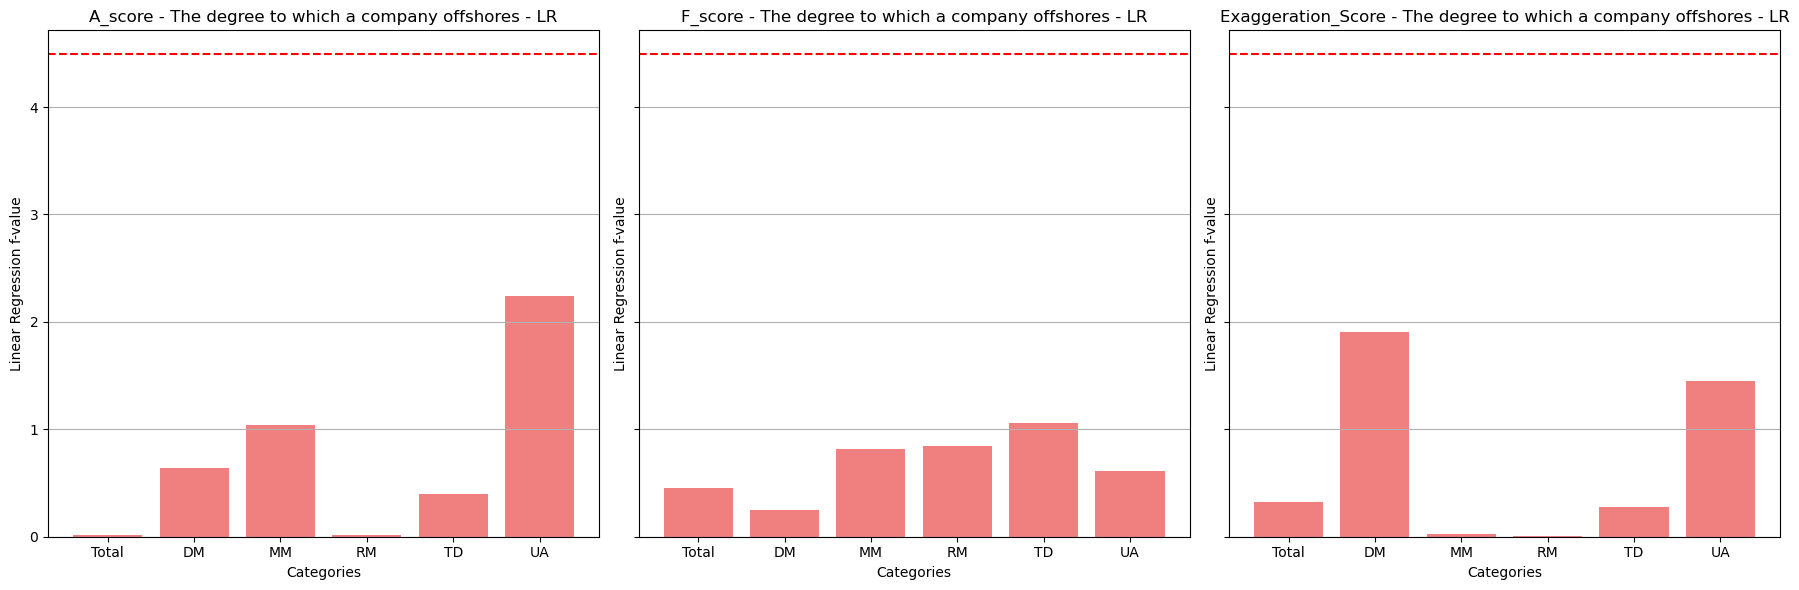

In [129]:
# Combine all F-values for the same category
combined_f_values = [
    Af0_values_Total + Af1_values_Total + Af2_values_Total + Af3_values_Total + Af4_values_Total + Af5_values_Total,
    Ff0_values_Total + Ff1_values_Total + Ff2_values_Total + Ff3_values_Total + Ff4_values_Total + Ff5_values_Total,
    Ef0_values_Total + Ef1_values_Total + Ef2_values_Total + Ef3_values_Total + Ef4_values_Total + Ef5_values_Total
]

# List of dataframes and their ANOVA p-values
dataframes = ['Total', 'DM', 'MM', 'RM', 'TD', 'UA']
custom_labels = ['A_score', 'F_score', 'Exaggeration_Score']

# Plotting the combined ANOVA p-values for each category in subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, values in enumerate(combined_f_values):
    axes[i].bar(dataframes, values, color='lightcoral')
    axes[i].set_title(f'{custom_labels[i]} - The degree to which a company offshores - LR')
    axes[i].set_xlabel('Categories')
    axes[i].set_ylabel('Linear Regression f-value')
    axes[i].axhline(y=4.49, color='red', linestyle='--', label='Critical Value (4.49)')
    axes[i].grid(axis='y')

plt.tight_layout()
plt.show()

# 6. The degree to which a company outsources (employs others outside Europe) (Q22): Linear Regression <a id='section-6'></a>

## Total

Actual compliance
- $H_0$: The degree to which a company outsources doesn't have an impact on the company's actual compliance
- $H_a$: The degree to which a company outsources has an impact on the company's actual compliance

In [130]:
# Moving columns to separate lists
x1 = df.Q22.to_list()
y = df.A_score.to_list()

#Calculate b0, b1, b2 and r-square
x1_data = np.array(x1).reshape((-1,1))
y_data = np.array(y)
model1 = LinearRegression().fit(x1_data, y_data)
b0 = model1.intercept_
b1 = model1.coef_
print("b0 = ", b0)
print("b1 = ", b1)
r_sq = model1.score(x1_data, y_data)
print("Coefficent of Determination = ",r_sq)

#Calculate the predicted values of y
y_pred = b0 + b1 * x1
print(y_pred)

#Calculate SSE and MSE
MSE = mean_squared_error(y, y_pred)
print("SSE = ", MSE*len(y))
MSE = MSE*len(y)/(len(y)-2)
print("MSE = ", MSE)

#Calculate MSR
SSR = 0
y_avg = np.mean(y)
print ("y_avg =", y_avg)
for i in y_pred:
    SSR = SSR + ((i-y_avg)*(i-y_avg))
MSR = SSR/1
print ("MSR = ", MSR)

#Devide MSR by MSE to calculate F-score
Q22_F0_A = MSR/MSE
print("F-score =", Q22_F0_A)

#Calculate critical value
df1 = 1  # Numerator degrees of freedom; independent variables
df2 = 16  # Denominator degrees of freedom
alpha = 0.05  # Significance level
critical_value = stats.f.ppf(1 - alpha, dfn=df1, dfd=df2)
print("Critical Value =", critical_value)

#Final answer
# To interpret this value, you need to compare it to the critial value with an appropriate degrees of freedom and significance level (alpha)
if Q22_F0_A > critical_value :   
    print("The null hypthesis is rejected")
else :
    print("The null hypthesis is not rejected")

b0 =  0.5636297188709792
b1 =  [0.0032377]
Coefficent of Determination =  0.005406557635250553
[0.57010511 0.56362972 0.57334281 0.56686742 0.57981821 0.58305591
 0.57010511 0.56686742 0.56362972 0.5960067  0.56362972 0.56362972
 0.57981821 0.58305591 0.56362972 0.56362972 0.56362972 0.57010511
 0.56362972 0.56362972 0.56362972 0.57334281 0.57010511 0.56362972
 0.592769   0.56362972 0.56362972 0.57010511 0.56362972 0.57981821
 0.5895313 ]
SSE =  0.5105908807560652
MSE =  0.01760658209503673
y_avg = 0.5711495333348393
MSR =  0.0027755451697706883
F-score = 0.15764247454667027
Critical Value = 4.493998477666352
The null hypthesis is not rejected


Perceived compliance (feeling)
- $H_0$: The degree to which a company outsources doesn't have an impact on the company's perceived compliance
- $H_a$: The degree to which a company outsources has an impact on the company's perceived compliance

In [131]:
# Moving columns to separate lists
x1 = df.Q22.to_list()
y = df.F_score.to_list()

#Calculate b0, b1, b2 and r-square
x1_data = np.array(x1).reshape((-1,1))
y_data = np.array(y)
model1 = LinearRegression().fit(x1_data, y_data)
b0 = model1.intercept_
b1 = model1.coef_
print("b0 = ", b0)
print("b1 = ", b1)
r_sq = model1.score(x1_data, y_data)
print("Coefficent of Determination = ",r_sq)

#Calculate the predicted values of y
y_pred = b0 + b1 * x1
print(y_pred)

#Calculate SSE and MSE
MSE = mean_squared_error(y, y_pred)
print("SSE = ", MSE*len(y))
MSE = MSE*len(y)/(len(y)-2)
print("MSE = ", MSE)

#Calculate MSR
SSR = 0
y_avg = np.mean(y)
print ("y_avg =", y_avg)
for i in y_pred:
    SSR = SSR + ((i-y_avg)*(i-y_avg))
MSR = SSR/1
print ("MSR = ", MSR)

#Devide MSR by MSE to calculate F-score
Q22_F0_F = MSR/MSE
print("F-score =", Q22_F0_F)

#Calculate critical value
df1 = 1  # Numerator degrees of freedom; independent variables
df2 = 16  # Denominator degrees of freedom
alpha = 0.05  # Significance level
critical_value = stats.f.ppf(1 - alpha, dfn=df1, dfd=df2)
print("Critical Value =", critical_value)

#Final answer
# To interpret this value, you need to compare it to the critial value with an appropriate degrees of freedom and significance level (alpha)
if Q22_F0_F > critical_value :   
    print("The null hypthesis is rejected")
else :
    print("The null hypthesis is not rejected")

b0 =  0.7048112410656271
b1 =  [0.0011256]
Coefficent of Determination =  0.0008471181446407794
[0.70706245 0.70481124 0.70818805 0.70593684 0.71043926 0.71156486
 0.70706245 0.70593684 0.70481124 0.71606728 0.70481124 0.70481124
 0.71043926 0.71156486 0.70481124 0.70481124 0.70481124 0.70706245
 0.70481124 0.70481124 0.70481124 0.70818805 0.70706245 0.70481124
 0.71494167 0.70481124 0.70481124 0.70706245 0.70481124 0.71043926
 0.71381607]
SSE =  0.3956711837181321
MSE =  0.0136438339213149
y_avg = 0.7074255457803845
MSR =  0.000335464417033686
F-score = 0.024587254504000604
Critical Value = 4.493998477666352
The null hypthesis is not rejected


Exaggerated compliance
- $H_0$: The degree to which a company outsources doesn't have an impact on the company's exaggerated compliance
- $H_a$: The degree to which a company outsources has an impact on the company's exaggerated compliance

In [132]:
# Moving columns to separate lists
x1 = df.Q22.to_list()
y = df.Exaggeration_Score.to_list()

#Calculate b0, b1, b2 and r-square
x1_data = np.array(x1).reshape((-1,1))
y_data = np.array(y)
model1 = LinearRegression().fit(x1_data, y_data)
b0 = model1.intercept_
b1 = model1.coef_
print("b0 = ", b0)
print("b1 = ", b1)
r_sq = model1.score(x1_data, y_data)
print("Coefficent of Determination = ",r_sq)

#Calculate the predicted values of y
y_pred = b0 + b1 * x1
print(y_pred)

#Calculate SSE and MSE
MSE = mean_squared_error(y, y_pred)
print("SSE = ", MSE*len(y))
MSE = MSE*len(y)/(len(y)-2)
print("MSE = ", MSE)

#Calculate MSR
SSR = 0
y_avg = np.mean(y)
print ("y_avg =", y_avg)
for i in y_pred:
    SSR = SSR + ((i-y_avg)*(i-y_avg))
MSR = SSR/1
print ("MSR = ", MSR)

#Devide MSR by MSE to calculate F-score
Q22_F0_E = MSR/MSE
print("F-score =", Q22_F0_E)

#Calculate critical value
df1 = 1  # Numerator degrees of freedom; independent variables
df2 = 16  # Denominator degrees of freedom
alpha = 0.05  # Significance level
critical_value = stats.f.ppf(1 - alpha, dfn=df1, dfd=df2)
print("Critical Value =", critical_value)

#Final answer
# To interpret this value, you need to compare it to the critial value with an appropriate degrees of freedom and significance level (alpha)
if Q22_F0_E > critical_value :   
    print("The null hypthesis is rejected")
else :
    print("The null hypthesis is not rejected")

b0 =  0.7904465142123185
b1 =  [0.00494168]
Coefficent of Determination =  0.015021369761084702
[0.80032988 0.79044651 0.80527156 0.7953882  0.81515493 0.82009661
 0.80032988 0.7953882  0.79044651 0.83986335 0.79044651 0.79044651
 0.81515493 0.82009661 0.79044651 0.79044651 0.79044651 0.80032988
 0.79044651 0.79044651 0.79044651 0.80527156 0.80032988 0.79044651
 0.83492167 0.79044651 0.79044651 0.80032988 0.79044651 0.81515493
 0.82997998]
SSE =  0.4239774598067019
MSE =  0.014619912407127652
y_avg = 0.8019239725264758
MSR =  0.006465848089087189
F-score = 0.4422631209428376
Critical Value = 4.493998477666352
The null hypthesis is not rejected


## Categorie 1: Data Model

Actual compliance
- $H_0$: The degree to which a company outsources doesn't have an impact on the company's actual compliance in the category Data Model
- $H_a$: The degree to which a company outsources has an impact on the company's actual compliance in the category Data Model

In [133]:
# Moving columns to separate lists
x1 = df_DataModel.Q22.to_list()
y = df_DataModel.A_score.to_list()

#Calculate b0, b1, b2 and r-square
x1_data = np.array(x1).reshape((-1,1))
y_data = np.array(y)
model1 = LinearRegression().fit(x1_data, y_data)
b0 = model1.intercept_
b1 = model1.coef_
print("b0 = ", b0)
print("b1 = ", b1)
r_sq = model1.score(x1_data, y_data)
print("Coefficent of Determination = ",r_sq)

#Calculate the predicted values of y
y_pred = b0 + b1 * x1
print(y_pred)

#Calculate SSE and MSE
MSE = mean_squared_error(y, y_pred)
print("SSE = ", MSE*len(y))
MSE = MSE*len(y)/(len(y)-2)
print("MSE = ", MSE)

#Calculate MSR
SSR = 0
y_avg = np.mean(y)
print ("y_avg =", y_avg)
for i in y_pred:
    SSR = SSR + ((i-y_avg)*(i-y_avg))
MSR = SSR/1
print ("MSR = ", MSR)

#Devide MSR by MSE to calculate F-score
Q22_F1_A = MSR/MSE
print("F-score =", Q22_F1_A)

#Calculate critical value
df1 = 1  # Numerator degrees of freedom; independent variables
df2 = 16  # Denominator degrees of freedom
alpha = 0.05  # Significance level
critical_value = stats.f.ppf(1 - alpha, dfn=df1, dfd=df2)
print("Critical Value =", critical_value)

#Final answer
# To interpret this value, you need to compare it to the critial value with an appropriate degrees of freedom and significance level (alpha)
if Q22_F1_A > critical_value :   
    print("The null hypthesis is rejected")
else :
    print("The null hypthesis is not rejected")

b0 =  0.5471396628826969
b1 =  [0.00175169]
Coefficent of Determination =  0.0028426707149017405
[0.55064304 0.54713966 0.55239472 0.54889135 0.5558981  0.55764978
 0.55064304 0.54889135 0.54713966 0.56465653 0.54713966 0.54713966
 0.5558981  0.55764978 0.54713966 0.54713966 0.54713966 0.55064304
 0.54713966 0.54713966 0.54713966 0.55239472 0.55064304 0.54713966
 0.56290484 0.54713966 0.54713966 0.55064304 0.54713966 0.5558981
 0.56115316]
SSE =  0.2849873421050758
MSE =  0.009827149727761235
y_avg = 0.5512080961416824
MSR =  0.0008124346557233957
F-score = 0.08267246131686648
Critical Value = 4.493998477666352
The null hypthesis is not rejected


Perceived compliance (feeling)
- $H_0$: The degree to which a company outsources doesn't have an impact on the company's perceived compliance in the category Data Model
- $H_a$: The degree to which a company outsources has an impact on the company's perceived compliance in the category Data Model

In [134]:
# Moving columns to separate lists
x1 = df_DataModel.Q22.to_list()
y = df_DataModel.F_score.to_list()

#Calculate b0, b1, b2 and r-square
x1_data = np.array(x1).reshape((-1,1))
y_data = np.array(y)
model1 = LinearRegression().fit(x1_data, y_data)
b0 = model1.intercept_
b1 = model1.coef_
print("b0 = ", b0)
print("b1 = ", b1)
r_sq = model1.score(x1_data, y_data)
print("Coefficent of Determination = ",r_sq)

#Calculate the predicted values of y
y_pred = b0 + b1 * x1
print(y_pred)

#Calculate SSE and MSE
MSE = mean_squared_error(y, y_pred)
print("SSE = ", MSE*len(y))
MSE = MSE*len(y)/(len(y)-2)
print("MSE = ", MSE)

#Calculate MSR
SSR = 0
y_avg = np.mean(y)
print ("y_avg =", y_avg)
for i in y_pred:
    SSR = SSR + ((i-y_avg)*(i-y_avg))
MSR = SSR/1
print ("MSR = ", MSR)

#Devide MSR by MSE to calculate F-score
Q22_F1_F = MSR/MSE
print("F-score =", Q22_F1_F)

#Calculate critical value
df1 = 1  # Numerator degrees of freedom; independent variables
df2 = 16  # Denominator degrees of freedom
alpha = 0.05  # Significance level
critical_value = stats.f.ppf(1 - alpha, dfn=df1, dfd=df2)
print("Critical Value =", critical_value)

#Final answer
# To interpret this value, you need to compare it to the critial value with an appropriate degrees of freedom and significance level (alpha)
if Q22_F1_F > critical_value :   
    print("The null hypthesis is rejected")
else :
    print("The null hypthesis is not rejected")

b0 =  0.7713450292397662
b1 =  [0.00703453]
Coefficent of Determination =  0.06380082613754856
[0.78541408 0.77134503 0.79244861 0.77837956 0.80651766 0.81355219
 0.78541408 0.77837956 0.77134503 0.84169029 0.77134503 0.77134503
 0.80651766 0.81355219 0.77134503 0.77134503 0.77134503 0.78541408
 0.77134503 0.77134503 0.77134503 0.79244861 0.78541408 0.77134503
 0.83465577 0.77134503 0.77134503 0.78541408 0.77134503 0.80651766
 0.82762124]
SSE =  0.19225929774441194
MSE =  0.00662963095670386
y_avg = 0.7876832844574782
MSR =  0.01310223547635872
F-score = 1.9763144527841001
Critical Value = 4.493998477666352
The null hypthesis is not rejected


Exaggerated compliance
- $H_0$: The degree to which a company outsources doesn't have an impact on the company's exaggerated compliance in the category Data Model
- $H_a$: The degree to which a company outsources has an impact on the company's exaggerated compliance in the category Data Model

In [135]:
# Moving columns to separate lists
x1 = df_DataModel.Q22.to_list()
y = df_DataModel.Exaggeration_Score.to_list()

#Calculate b0, b1, b2 and r-square
x1_data = np.array(x1).reshape((-1,1))
y_data = np.array(y)
model1 = LinearRegression().fit(x1_data, y_data)
b0 = model1.intercept_
b1 = model1.coef_
print("b0 = ", b0)
print("b1 = ", b1)
r_sq = model1.score(x1_data, y_data)
print("Coefficent of Determination = ",r_sq)

#Calculate the predicted values of y
y_pred = b0 + b1 * x1
print(y_pred)

#Calculate SSE and MSE
MSE = mean_squared_error(y, y_pred)
print("SSE = ", MSE*len(y))
MSE = MSE*len(y)/(len(y)-2)
print("MSE = ", MSE)

#Calculate MSR
SSR = 0
y_avg = np.mean(y)
print ("y_avg =", y_avg)
for i in y_pred:
    SSR = SSR + ((i-y_avg)*(i-y_avg))
MSR = SSR/1
print ("MSR = ", MSR)

#Devide MSR by MSE to calculate F-score
Q22_F1_E = MSR/MSE
print("F-score =", Q22_F1_E)

#Calculate critical value
df1 = 1  # Numerator degrees of freedom; independent variables
df2 = 16  # Denominator degrees of freedom
alpha = 0.05  # Significance level
critical_value = stats.f.ppf(1 - alpha, dfn=df1, dfd=df2)
print("Critical Value =", critical_value)

#Final answer
# To interpret this value, you need to compare it to the critial value with an appropriate degrees of freedom and significance level (alpha)
if Q22_F1_E > critical_value :   
    print("The null hypthesis is rejected")
else :
    print("The null hypthesis is not rejected")

b0 =  0.7083379458605307
b1 =  [-0.00386491]
Coefficent of Determination =  0.013095126423583792
[0.70060812 0.70833795 0.69674321 0.70447303 0.68901339 0.68514848
 0.70060812 0.70447303 0.70833795 0.66968884 0.70833795 0.70833795
 0.68901339 0.68514848 0.70833795 0.70833795 0.70833795 0.70060812
 0.70833795 0.70833795 0.70833795 0.69674321 0.70060812 0.70833795
 0.67355375 0.70833795 0.70833795 0.70060812 0.70833795 0.68901339
 0.67741866]
SSE =  0.29807134907901783
MSE =  0.010278322382035097
y_avg = 0.6993613785205147
MSR =  0.0039550741960497115
F-score = 0.38479764002757527
Critical Value = 4.493998477666352
The null hypthesis is not rejected


## Categorie 2: Model Monitoring

Actual compliance
- $H_0$: The degree to which a company outsources doesn't have an impact on the company's actual compliance in the category Model Monotoring
- $H_a$: The degree to which a company outsources has an impact on the company's actual compliance in the category Model Monotoring

In [136]:
# Moving columns to separate lists
x1 = df_ModelMonitoring.Q22.to_list()
y = df_ModelMonitoring.A_score.to_list()

#Calculate b0, b1, b2 and r-square
x1_data = np.array(x1).reshape((-1,1))
y_data = np.array(y)
model1 = LinearRegression().fit(x1_data, y_data)
b0 = model1.intercept_
b1 = model1.coef_
print("b0 = ", b0)
print("b1 = ", b1)
r_sq = model1.score(x1_data, y_data)
print("Coefficent of Determination = ",r_sq)

#Calculate the predicted values of y
y_pred = b0 + b1 * x1
print(y_pred)

#Calculate SSE and MSE
MSE = mean_squared_error(y, y_pred)
print("SSE = ", MSE*len(y))
MSE = MSE*len(y)/(len(y)-2)
print("MSE = ", MSE)

#Calculate MSR
SSR = 0
y_avg = np.mean(y)
print ("y_avg =", y_avg)
for i in y_pred:
    SSR = SSR + ((i-y_avg)*(i-y_avg))
MSR = SSR/1
print ("MSR = ", MSR)

#Devide MSR by MSE to calculate F-score
Q22_F2_A = MSR/MSE
print("F-score =", Q22_F2_A)

#Calculate critical value
df1 = 1  # Numerator degrees of freedom; independent variables
df2 = 16  # Denominator degrees of freedom
alpha = 0.05  # Significance level
critical_value = stats.f.ppf(1 - alpha, dfn=df1, dfd=df2)
print("Critical Value =", critical_value)

#Final answer
# To interpret this value, you need to compare it to the critial value with an appropriate degrees of freedom and significance level (alpha)
if Q22_F2_A > critical_value :   
    print("The null hypthesis is rejected")
else :
    print("The null hypthesis is not rejected")




b0 =  0.6540956558061822
b1 =  [-0.00677912]
Coefficent of Determination =  0.015400396611479628
[0.64053743 0.65409566 0.63375831 0.64731654 0.62020008 0.61342097
 0.64053743 0.64731654 0.65409566 0.58630451 0.65409566 0.65409566
 0.62020008 0.61342097 0.65409566 0.65409566 0.65409566 0.64053743
 0.65409566 0.65409566 0.65409566 0.63375831 0.64053743 0.65409566
 0.59308362 0.65409566 0.65409566 0.64053743 0.65409566 0.62020008
 0.59986274]
SSE =  0.777945927637726
MSE =  0.026825721642680204
y_avg = 0.6383506144393242
MSR =  0.01216806891519644
F-score = 0.4535970766145886
Critical Value = 4.493998477666352
The null hypthesis is not rejected


Perceived compliance (feeling)
- $H_0$: The degree to which a company outsources doesn't have an impact on the company's perceived compliance in the category Model Monitoring
- $H_a$: The degree to which a company outsources has an impact on the company's perceived compliance in the category Model Monitoring

In [137]:
# Moving columns to separate lists
x1 = df_ModelMonitoring.Q22.to_list()
y = df_ModelMonitoring.F_score.to_list()

#Calculate b0, b1, b2 and r-square
x1_data = np.array(x1).reshape((-1,1))
y_data = np.array(y)
model1 = LinearRegression().fit(x1_data, y_data)
b0 = model1.intercept_
b1 = model1.coef_
print("b0 = ", b0)
print("b1 = ", b1)
r_sq = model1.score(x1_data, y_data)
print("Coefficent of Determination = ",r_sq)

#Calculate the predicted values of y
y_pred = b0 + b1 * x1
print(y_pred)

#Calculate SSE and MSE
MSE = mean_squared_error(y, y_pred)
print("SSE = ", MSE*len(y))
MSE = MSE*len(y)/(len(y)-2)
print("MSE = ", MSE)

#Calculate MSR
SSR = 0
y_avg = np.mean(y)
print ("y_avg =", y_avg)
for i in y_pred:
    SSR = SSR + ((i-y_avg)*(i-y_avg))
MSR = SSR/1
print ("MSR = ", MSR)

#Devide MSR by MSE to calculate F-score
Q22_F2_F = MSR/MSE
print("F-score =", Q22_F2_F)

#Calculate critical value
df1 = 1  # Numerator degrees of freedom; independent variables
df2 = 16  # Denominator degrees of freedom
alpha = 0.05  # Significance level
critical_value = stats.f.ppf(1 - alpha, dfn=df1, dfd=df2)
print("Critical Value =", critical_value)

#Final answer
# To interpret this value, you need to compare it to the critial value with an appropriate degrees of freedom and significance level (alpha)
if Q22_F2_F > critical_value :   
    print("The null hypthesis is rejected")
else :
    print("The null hypthesis is not rejected")


b0 =  0.722076023391813
b1 =  [-0.00941236]
Coefficent of Determination =  0.026895501883888118
[0.7032513  0.72207602 0.69383894 0.71266366 0.67501421 0.66560185
 0.7032513  0.71266366 0.72207602 0.6279524  0.72207602 0.72207602
 0.67501421 0.66560185 0.72207602 0.72207602 0.72207602 0.7032513
 0.72207602 0.72207602 0.72207602 0.69383894 0.7032513  0.72207602
 0.63736477 0.72207602 0.72207602 0.7032513  0.72207602 0.67501421
 0.64677713]
SSE =  0.8486970990361707
MSE =  0.02926541720814382
y_avg = 0.700215053763441
MSR =  0.023457022827628626
F-score = 0.8015270262780034
Critical Value = 4.493998477666352
The null hypthesis is not rejected


Exaggerated compliance
- $H_0$: The degree to which a company outsources doesn't have an impact on the company's exaggerated compliance in the category Model Monitoring
- $H_a$: The degree to which a company outsources has an impact on the company's exaggerated compliance in the category Model Monitoring

In [138]:
# Moving columns to separate lists
x1 = df_ModelMonitoring.Q22.to_list()
y = df_ModelMonitoring.Exaggeration_Score.to_list()

#Calculate b0, b1, b2 and r-square
x1_data = np.array(x1).reshape((-1,1))
y_data = np.array(y)
model1 = LinearRegression().fit(x1_data, y_data)
b0 = model1.intercept_
b1 = model1.coef_
print("b0 = ", b0)
print("b1 = ", b1)
r_sq = model1.score(x1_data, y_data)
print("Coefficent of Determination = ",r_sq)

#Calculate the predicted values of y
y_pred = b0 + b1 * x1
print(y_pred)

#Calculate SSE and MSE
MSE = mean_squared_error(y, y_pred)
print("SSE = ", MSE*len(y))
MSE = MSE*len(y)/(len(y)-2)
print("MSE = ", MSE)

#Calculate MSR
SSR = 0
y_avg = np.mean(y)
print ("y_avg =", y_avg)
for i in y_pred:
    SSR = SSR + ((i-y_avg)*(i-y_avg))
MSR = SSR/1
print ("MSR = ", MSR)

#Devide MSR by MSE to calculate F-score
Q22_F2_E = MSR/MSE
print("F-score =", Q22_F2_E)

#Calculate critical value
df1 = 1  # Numerator degrees of freedom; independent variables
df2 = 16  # Denominator degrees of freedom
alpha = 0.05  # Significance level
critical_value = stats.f.ppf(1 - alpha, dfn=df1, dfd=df2)
print("Critical Value =", critical_value)

#Final answer
# To interpret this value, you need to compare it to the critial value with an appropriate degrees of freedom and significance level (alpha)
if Q22_F2_E > critical_value :   
    print("The null hypthesis is rejected")
else :
    print("The null hypthesis is not rejected")

b0 =  0.9180699130998993
b1 =  [0.00704472]
Coefficent of Determination =  0.006448521319029177
[0.93215936 0.91806991 0.93920409 0.92511464 0.95329353 0.96033826
 0.93215936 0.92511464 0.91806991 0.98851715 0.91806991 0.91806991
 0.95329353 0.96033826 0.91806991 0.91806991 0.91806991 0.93215936
 0.91806991 0.91806991 0.91806991 0.93920409 0.93215936 0.91806991
 0.98147243 0.91806991 0.91806991 0.93215936 0.91806991 0.95329353
 0.97442771]
SSE =  2.0245749389251078
MSE =  0.06981292892845199
y_avg = 0.9344318527673403
MSR =  0.013140249836841474
F-score = 0.1882208645093275
Critical Value = 4.493998477666352
The null hypthesis is not rejected


## Categorie 3: Risk Management

Actual compliance
- $H_0$: The degree to which a company outsources doesn't have an impact on the company's actual compliance in the category Risk Management
- $H_a$: The degree to which a company outsources has an impact on the company's actual compliance in the category Risk Management

In [139]:
# Moving columns to separate lists
x1 = df_RiskManagement.Q22.to_list()
y = df_RiskManagement.A_score.to_list()

#Calculate b0, b1, b2 and r-square
x1_data = np.array(x1).reshape((-1,1))
y_data = np.array(y)
model1 = LinearRegression().fit(x1_data, y_data)
b0 = model1.intercept_
b1 = model1.coef_
print("b0 = ", b0)
print("b1 = ", b1)
r_sq = model1.score(x1_data, y_data)
print("Coefficent of Determination = ",r_sq)

#Calculate the predicted values of y
y_pred = b0 + b1 * x1
print(y_pred)

#Calculate SSE and MSE
MSE = mean_squared_error(y, y_pred)
print("SSE = ", MSE*len(y))
MSE = MSE*len(y)/(len(y)-2)
print("MSE = ", MSE)

#Calculate MSR
SSR = 0
y_avg = np.mean(y)
print ("y_avg =", y_avg)
for i in y_pred:
    SSR = SSR + ((i-y_avg)*(i-y_avg))
MSR = SSR/1
print ("MSR = ", MSR)

#Devide MSR by MSE to calculate F-score
Q22_F3_A = MSR/MSE
print("F-score =", Q22_F3_A)

#Calculate critical value
df1 = 1  # Numerator degrees of freedom; independent variables
df2 = 16  # Denominator degrees of freedom
alpha = 0.05  # Significance level
critical_value = stats.f.ppf(1 - alpha, dfn=df1, dfd=df2)
print("Critical Value =", critical_value)

#Final answer
# To interpret this value, you need to compare it to the critial value with an appropriate degrees of freedom and significance level (alpha)
if Q22_F3_A > critical_value :   
    print("The null hypthesis is rejected")
else :
    print("The null hypthesis is not rejected")



b0 =  0.7481770833333335
b1 =  [-0.00077112]
Coefficent of Determination =  5.8534509215113495e-05
[0.74663484 0.74817708 0.74586372 0.74740596 0.74432147 0.74355035
 0.74663484 0.74740596 0.74817708 0.74046586 0.74817708 0.74817708
 0.74432147 0.74355035 0.74817708 0.74817708 0.74817708 0.74663484
 0.74817708 0.74817708 0.74817708 0.74586372 0.74663484 0.74817708
 0.74123698 0.74817708 0.74817708 0.74663484 0.74817708 0.74432147
 0.7420081 ]
SSE =  2.6895846019603593
MSE =  0.09274429661932274
y_avg = 0.7463860887096776
MSR =  0.00015744273050142453
F-score = 0.0016976001354311015
Critical Value = 4.493998477666352
The null hypthesis is not rejected


Perceived compliance (feeling)
- $H_0$: The degree to which a company outsources doesn't have an impact on the company's perceived compliance in the category Risk Management
- $H_a$: The degree to which a company outsources has an impact on the company's perceived compliance in the category Risk Management

In [140]:
# Moving columns to separate lists
x1 = df_RiskManagement.Q22.to_list()
y = df_RiskManagement.F_score.to_list()

#Calculate b0, b1, b2 and r-square
x1_data = np.array(x1).reshape((-1,1))
y_data = np.array(y)
model1 = LinearRegression().fit(x1_data, y_data)
b0 = model1.intercept_
b1 = model1.coef_
print("b0 = ", b0)
print("b1 = ", b1)
r_sq = model1.score(x1_data, y_data)
print("Coefficent of Determination = ",r_sq)

#Calculate the predicted values of y
y_pred = b0 + b1 * x1
print(y_pred)

#Calculate SSE and MSE
MSE = mean_squared_error(y, y_pred)
print("SSE = ", MSE*len(y))
MSE = MSE*len(y)/(len(y)-2)
print("MSE = ", MSE)

#Calculate MSR
SSR = 0
y_avg = np.mean(y)
print ("y_avg =", y_avg)
for i in y_pred:
    SSR = SSR + ((i-y_avg)*(i-y_avg))
MSR = SSR/1
print ("MSR = ", MSR)

#Devide MSR by MSE to calculate F-score
Q22_F3_F = MSR/MSE
print("F-score =", Q22_F3_F)

#Calculate critical value
df1 = 1  # Numerator degrees of freedom; independent variables
df2 = 16  # Denominator degrees of freedom
alpha = 0.05  # Significance level
critical_value = stats.f.ppf(1 - alpha, dfn=df1, dfd=df2)
print("Critical Value =", critical_value)

#Final answer
# To interpret this value, you need to compare it to the critial value with an appropriate degrees of freedom and significance level (alpha)
if Q22_F3_F > critical_value :   
    print("The null hypthesis is rejected")
else :
    print("The null hypthesis is not rejected")

b0 =  0.8710380116959064
b1 =  [-0.00278488]
Coefficent of Determination =  0.0009401560035333656
[0.86546824 0.87103801 0.86268336 0.86825313 0.85711359 0.8543287
 0.86546824 0.86825313 0.87103801 0.84318917 0.87103801 0.87103801
 0.85711359 0.8543287  0.87103801 0.87103801 0.87103801 0.86546824
 0.87103801 0.87103801 0.87103801 0.86268336 0.86546824 0.87103801
 0.84597405 0.87103801 0.87103801 0.86546824 0.87103801 0.85711359
 0.84875893]
SSE =  2.1821352315491658
MSE =  0.07524604246721261
y_avg = 0.8645698924731182
MSR =  0.0020534781282532414
F-score = 0.02729018113009751
Critical Value = 4.493998477666352
The null hypthesis is not rejected


Exaggerated compliance
- $H_0$: The degree to which a company outsources doesn't have an impact on the company's exaggerated compliance in the category Risk Management
- $H_a$: The degree to which a company outsources has an impact on the company's exaggerated compliance in the category Risk Management

In [141]:
# Moving columns to separate lists
x1 = df_RiskManagement.Q22.to_list()
y = df_RiskManagement.Exaggeration_Score.to_list()

#Calculate b0, b1, b2 and r-square
x1_data = np.array(x1).reshape((-1,1))
y_data = np.array(y)
model1 = LinearRegression().fit(x1_data, y_data)
b0 = model1.intercept_
b1 = model1.coef_
print("b0 = ", b0)
print("b1 = ", b1)
r_sq = model1.score(x1_data, y_data)
print("Coefficent of Determination = ",r_sq)

#Calculate the predicted values of y
y_pred = b0 + b1 * x1
print(y_pred)

#Calculate SSE and MSE
MSE = mean_squared_error(y, y_pred)
print("SSE = ", MSE*len(y))
MSE = MSE*len(y)/(len(y)-2)
print("MSE = ", MSE)

#Calculate MSR
SSR = 0
y_avg = np.mean(y)
print ("y_avg =", y_avg)
for i in y_pred:
    SSR = SSR + ((i-y_avg)*(i-y_avg))
MSR = SSR/1
print ("MSR = ", MSR)

#Devide MSR by MSE to calculate F-score
Q22_F3_E = MSR/MSE
print("F-score =", Q22_F3_E)

#Calculate critical value
df1 = 1  # Numerator degrees of freedom; independent variables
df2 = 16  # Denominator degrees of freedom
alpha = 0.05  # Significance level
critical_value = stats.f.ppf(1 - alpha, dfn=df1, dfd=df2)
print("Critical Value =", critical_value)

#Final answer
# To interpret this value, you need to compare it to the critial value with an appropriate degrees of freedom and significance level (alpha)
if Q22_F3_E > critical_value :   
    print("The null hypthesis is rejected")
else :
    print("The null hypthesis is not rejected")

b0 =  0.7942700230936808
b1 =  [0.01164676]
Coefficent of Determination =  0.015009692324326251
[0.81756354 0.79427002 0.8292103  0.80591678 0.85250382 0.86415058
 0.81756354 0.80591678 0.79427002 0.91073762 0.79427002 0.79427002
 0.85250382 0.86415058 0.79427002 0.79427002 0.79427002 0.81756354
 0.79427002 0.79427002 0.79427002 0.8292103  0.81756354 0.79427002
 0.89909086 0.79427002 0.79427002 0.81756354 0.79427002 0.85250382
 0.8874441 ]
SSE =  2.3569266235779045
MSE =  0.08127333184751395
y_avg = 0.8213205620959405
MSR =  0.035915828993685533
F-score = 0.44191407165478663
Critical Value = 4.493998477666352
The null hypthesis is not rejected


## Categorie 4: Technical Documentation

Actual compliance
- $H_0$: The degree to which a company outsources doesn't have an impact on the company's actual compliance in the category Technical Documentation
- $H_a$: The degree to which a company outsources has an impact on the company's actual compliance in the category Technical Documentation

In [142]:
# Moving columns to separate lists
x1 = df_TechnicalDocumentation.Q22.to_list()
y = df_TechnicalDocumentation.A_score.to_list()

#Calculate b0, b1, b2 and r-square
x1_data = np.array(x1).reshape((-1,1))
y_data = np.array(y)
model1 = LinearRegression().fit(x1_data, y_data)
b0 = model1.intercept_
b1 = model1.coef_
print("b0 = ", b0)
print("b1 = ", b1)
r_sq = model1.score(x1_data, y_data)
print("Coefficent of Determination = ",r_sq)

#Calculate the predicted values of y
y_pred = b0 + b1 * x1
print(y_pred)

#Calculate SSE and MSE
MSE = mean_squared_error(y, y_pred)
print("SSE = ", MSE*len(y))
MSE = MSE*len(y)/(len(y)-2)
print("MSE = ", MSE)

#Calculate MSR
SSR = 0
y_avg = np.mean(y)
print ("y_avg =", y_avg)
for i in y_pred:
    SSR = SSR + ((i-y_avg)*(i-y_avg))
MSR = SSR/1
print ("MSR = ", MSR)

#Devide MSR by MSE to calculate F-score
Q22_F4_A = MSR/MSE
print("F-score =", Q22_F4_A)

#Calculate critical value
df1 = 1  # Numerator degrees of freedom; independent variables
df2 = 16  # Denominator degrees of freedom
alpha = 0.05  # Significance level
critical_value = stats.f.ppf(1 - alpha, dfn=df1, dfd=df2)
print("Critical Value =", critical_value)

#Final answer
# To interpret this value, you need to compare it to the critial value with an appropriate degrees of freedom and significance level (alpha)
if Q22_F4_A > critical_value :   
    print("The null hypthesis is rejected")
else :
    print("The null hypthesis is not rejected")

b0 =  0.3664619883040935
b1 =  [0.01293535]
Coefficent of Determination =  0.09093762887625867
[0.39233268 0.36646199 0.40526803 0.37939734 0.43113873 0.44407407
 0.39233268 0.37939734 0.36646199 0.49581546 0.36646199 0.36646199
 0.43113873 0.44407407 0.36646199 0.36646199 0.36646199 0.39233268
 0.36646199 0.36646199 0.36646199 0.40526803 0.39233268 0.36646199
 0.48288012 0.36646199 0.36646199 0.39233268 0.36646199 0.43113873
 0.46994477]
SSE =  0.44287576781459825
MSE =  0.015271578200503387
y_avg = 0.39650537634408595
MSR =  0.044302870178233346
F-score = 2.901001428704534
Critical Value = 4.493998477666352
The null hypthesis is not rejected


Perceived compliance (feeling)
- $H_0$: The degree to which a company outsources doesn't have an impact on the company's perceived compliance in the category Technical Documentation
- $H_a$: The degree to which a company outsources has an impact on the company's perceived compliance in the category Technical Documentation

In [143]:
# Moving columns to separate lists
x1 = df_TechnicalDocumentation.Q22.to_list()
y = df_TechnicalDocumentation.F_score.to_list()

#Calculate b0, b1, b2 and r-square
x1_data = np.array(x1).reshape((-1,1))
y_data = np.array(y)
model1 = LinearRegression().fit(x1_data, y_data)
b0 = model1.intercept_
b1 = model1.coef_
print("b0 = ", b0)
print("b1 = ", b1)
r_sq = model1.score(x1_data, y_data)
print("Coefficent of Determination = ",r_sq)

#Calculate the predicted values of y
y_pred = b0 + b1 * x1
print(y_pred)

#Calculate SSE and MSE
MSE = mean_squared_error(y, y_pred)
print("SSE = ", MSE*len(y))
MSE = MSE*len(y)/(len(y)-2)
print("MSE = ", MSE)

#Calculate MSR
SSR = 0
y_avg = np.mean(y)
print ("y_avg =", y_avg)
for i in y_pred:
    SSR = SSR + ((i-y_avg)*(i-y_avg))
MSR = SSR/1
print ("MSR = ", MSR)

#Devide MSR by MSE to calculate F-score
Q22_F4_F = MSR/MSE
print("F-score =", Q22_F4_F)

#Calculate critical value
df1 = 1  # Numerator degrees of freedom; independent variables
df2 = 16  # Denominator degrees of freedom
alpha = 0.05  # Significance level
critical_value = stats.f.ppf(1 - alpha, dfn=df1, dfd=df2)
print("Critical Value =", critical_value)

#Final answer
# To interpret this value, you need to compare it to the critial value with an appropriate degrees of freedom and significance level (alpha)
if Q22_F4_F > critical_value :   
    print("The null hypthesis is rejected")
else :
    print("The null hypthesis is not rejected")

b0 =  0.442053281351527
b1 =  [0.0113999]
Coefficent of Determination =  0.07616280055961178
[0.46485308 0.44205328 0.47625298 0.45345318 0.49905278 0.51045267
 0.46485308 0.45345318 0.44205328 0.55605227 0.44205328 0.44205328
 0.49905278 0.51045267 0.44205328 0.44205328 0.44205328 0.46485308
 0.44205328 0.44205328 0.44205328 0.47625298 0.46485308 0.44205328
 0.54465237 0.44205328 0.44205328 0.46485308 0.44205328 0.49905278
 0.53325247]
SSE =  0.4173786174016047
MSE =  0.014392366117296714
y_avg = 0.46853046594982084
MSR =  0.034409444017041935
F-score = 2.3908121664365347
Critical Value = 4.493998477666352
The null hypthesis is not rejected


Exaggerated compliance
- $H_0$: The degree to which a company outsources doesn't have an impact on the company's exaggerated compliance in the category Technical Documentation
- $H_a$: The degree to which a company outsources has an impact on the company's exaggerated compliance in the category Technical Documentation

In [144]:
# Moving columns to separate lists
x1 = df_TechnicalDocumentation.Q22.to_list()
y = df_TechnicalDocumentation.Exaggeration_Score.to_list()

#Calculate b0, b1, b2 and r-square
x1_data = np.array(x1).reshape((-1,1))
y_data = np.array(y)
model1 = LinearRegression().fit(x1_data, y_data)
b0 = model1.intercept_
b1 = model1.coef_
print("b0 = ", b0)
print("b1 = ", b1)
r_sq = model1.score(x1_data, y_data)
print("Coefficent of Determination = ",r_sq)

#Calculate the predicted values of y
y_pred = b0 + b1 * x1
print(y_pred)

#Calculate SSE and MSE
MSE = mean_squared_error(y, y_pred)
print("SSE = ", MSE*len(y))
MSE = MSE*len(y)/(len(y)-2)
print("MSE = ", MSE)

#Calculate MSR
SSR = 0
y_avg = np.mean(y)
print ("y_avg =", y_avg)
for i in y_pred:
    SSR = SSR + ((i-y_avg)*(i-y_avg))
MSR = SSR/1
print ("MSR = ", MSR)

#Devide MSR by MSE to calculate F-score
Q22_F4_E = MSR/MSE
print("F-score =", Q22_F4_E)

#Calculate critical value
df1 = 1  # Numerator degrees of freedom; independent variables
df2 = 16  # Denominator degrees of freedom
alpha = 0.05  # Significance level
critical_value = stats.f.ppf(1 - alpha, dfn=df1, dfd=df2)
print("Critical Value =", critical_value)

#Final answer
# To interpret this value, you need to compare it to the critial value with an appropriate degrees of freedom and significance level (alpha)
if Q22_F4_E > critical_value :   
    print("The null hypthesis is rejected")
else :
    print("The null hypthesis is not rejected")

b0 =  0.8277389761303781
b1 =  [0.00966646]
Coefficent of Determination =  0.016145369958391664
[0.84707191 0.82773898 0.85673837 0.83740544 0.8760713  0.88573777
 0.84707191 0.83740544 0.82773898 0.92440363 0.82773898 0.82773898
 0.8760713  0.88573777 0.82773898 0.82773898 0.82773898 0.84707191
 0.82773898 0.82773898 0.82773898 0.85673837 0.84707191 0.82773898
 0.91473716 0.82773898 0.82773898 0.84707191 0.82773898 0.8760713
 0.9050707 ]
SSE =  1.5076271395232812
MSE =  0.05198714274218211
y_avg = 0.8501901205036264
MSR =  0.024740644790059354
F-score = 0.475899299039278
Critical Value = 4.493998477666352
The null hypthesis is not rejected


## Categorie 5: User Application

Actual compliance
- $H_0$: The degree to which a company outsources doesn't have an impact on the company's actual compliance in the category User Application
- $H_a$: The degree to which a company outsources has an impact on the company's actual compliance in the category User Application

In [145]:
# Moving columns to separate lists
x1 = df_UserApplication.Q22.to_list()
y = df_UserApplication.A_score.to_list()

#Calculate b0, b1, b2 and r-square
x1_data = np.array(x1).reshape((-1,1))
y_data = np.array(y)
model1 = LinearRegression().fit(x1_data, y_data)
b0 = model1.intercept_
b1 = model1.coef_
print("b0 = ", b0)
print("b1 = ", b1)
r_sq = model1.score(x1_data, y_data)
print("Coefficent of Determination = ",r_sq)

#Calculate the predicted values of y
y_pred = b0 + b1 * x1
print(y_pred)

#Calculate SSE and MSE
MSE = mean_squared_error(y, y_pred)
print("SSE = ", MSE*len(y))
MSE = MSE*len(y)/(len(y)-2)
print("MSE = ", MSE)

#Calculate MSR
SSR = 0
y_avg = np.mean(y)
print ("y_avg =", y_avg)
for i in y_pred:
    SSR = SSR + ((i-y_avg)*(i-y_avg))
MSR = SSR/1
print ("MSR = ", MSR)

#Devide MSR by MSE to calculate F-score
Q22_F5_A = MSR/MSE
print("F-score =", Q22_F5_A)

#Calculate critical value
df1 = 1  # Numerator degrees of freedom; independent variables
df2 = 16  # Denominator degrees of freedom
alpha = 0.05  # Significance level
critical_value = stats.f.ppf(1 - alpha, dfn=df1, dfd=df2)
print("Critical Value =", critical_value)

#Final answer
# To interpret this value, you need to compare it to the critial value with an appropriate degrees of freedom and significance level (alpha)
if Q22_F5_A > critical_value :   
    print("The null hypthesis is rejected")
else :
    print("The null hypthesis is not rejected")

b0 =  0.5022742040285898
b1 =  [0.00905169]
Coefficent of Determination =  0.03469700212909588
[0.52037759 0.5022742  0.52942928 0.5113259  0.54753267 0.55658436
 0.52037759 0.5113259  0.5022742  0.59279113 0.5022742  0.5022742
 0.54753267 0.55658436 0.5022742  0.5022742  0.5022742  0.52037759
 0.5022742  0.5022742  0.5022742  0.52942928 0.52037759 0.5022742
 0.58373944 0.5022742  0.5022742  0.52037759 0.5022742  0.54753267
 0.57468775]
SSE =  0.6035412939833197
MSE =  0.020811768758045506
y_avg = 0.5232974910394264
MSR =  0.021693782789988774
F-score = 1.0423805416155365
Critical Value = 4.493998477666352
The null hypthesis is not rejected


Perceived compliance (feeling)
- $H_0$: The degree to which a company outsources doesn't have an impact on the company's perceived compliance in the category User Application
- $H_a$: The degree to which a company outsources has an impact on the company's perceived compliance in the category User Application

In [146]:
# Moving columns to separate lists
x1 = df_UserApplication.Q22.to_list()
y = df_UserApplication.F_score.to_list()

#Calculate b0, b1, b2 and r-square
x1_data = np.array(x1).reshape((-1,1))
y_data = np.array(y)
model1 = LinearRegression().fit(x1_data, y_data)
b0 = model1.intercept_
b1 = model1.coef_
print("b0 = ", b0)
print("b1 = ", b1)
r_sq = model1.score(x1_data, y_data)
print("Coefficent of Determination = ",r_sq)

#Calculate the predicted values of y
y_pred = b0 + b1 * x1
print(y_pred)

#Calculate SSE and MSE
MSE = mean_squared_error(y, y_pred)
print("SSE = ", MSE*len(y))
MSE = MSE*len(y)/(len(y)-2)
print("MSE = ", MSE)

#Calculate MSR
SSR = 0
y_avg = np.mean(y)
print ("y_avg =", y_avg)
for i in y_pred:
    SSR = SSR + ((i-y_avg)*(i-y_avg))
MSR = SSR/1
print ("MSR = ", MSR)

#Devide MSR by MSE to calculate F-score
Q22_F5_F = MSR/MSE
print("F-score =", Q22_F5_F)

#Calculate critical value
df1 = 1  # Numerator degrees of freedom; independent variables
df2 = 16  # Denominator degrees of freedom
alpha = 0.05  # Significance level
critical_value = stats.f.ppf(1 - alpha, dfn=df1, dfd=df2)
print("Critical Value =", critical_value)

#Final answer
# To interpret this value, you need to compare it to the critial value with an appropriate degrees of freedom and significance level (alpha)
if Q22_F5_F > critical_value :   
    print("The null hypthesis is rejected")
else :
    print("The null hypthesis is not rejected")

b0 =  0.7175438596491229
b1 =  [-0.00060916]
Coefficent of Determination =  0.00012285891314878228
[0.71632554 0.71754386 0.71571637 0.7169347  0.71449805 0.71388889
 0.71632554 0.7169347  0.71754386 0.71145224 0.71754386 0.71754386
 0.71449805 0.71388889 0.71754386 0.71754386 0.71754386 0.71632554
 0.71754386 0.71754386 0.71754386 0.71571637 0.71632554 0.71754386
 0.7120614  0.71754386 0.71754386 0.71632554 0.71754386 0.71449805
 0.71267057]
SSE =  0.7996150097465885
MSE =  0.027572931370572016
y_avg = 0.7161290322580647
MSR =  9.825190215682656e-05
F-score = 0.0035633462701643924
Critical Value = 4.493998477666352
The null hypthesis is not rejected


Exaggerated compliance
- $H_0$: The degree to which a company outsources doesn't have an impact on the company's exaggerated compliance in the category User Application
- $H_a$: The degree to which a company outsources has an impact on the company's exaggerated compliance in the category User Application

In [147]:
# Moving columns to separate lists
x1 = df_UserApplication.Q22.to_list()
y = df_UserApplication.Exaggeration_Score.to_list()

#Calculate b0, b1, b2 and r-square
x1_data = np.array(x1).reshape((-1,1))
y_data = np.array(y)
model1 = LinearRegression().fit(x1_data, y_data)
b0 = model1.intercept_
b1 = model1.coef_
print("b0 = ", b0)
print("b1 = ", b1)
r_sq = model1.score(x1_data, y_data)
print("Coefficent of Determination = ",r_sq)

#Calculate the predicted values of y
y_pred = b0 + b1 * x1
print(y_pred)

#Calculate SSE and MSE
MSE = mean_squared_error(y, y_pred)
print("SSE = ", MSE*len(y))
MSE = MSE*len(y)/(len(y)-2)
print("MSE = ", MSE)

#Calculate MSR
SSR = 0
y_avg = np.mean(y)
print ("y_avg =", y_avg)
for i in y_pred:
    SSR = SSR + ((i-y_avg)*(i-y_avg))
MSR = SSR/1
print ("MSR = ", MSR)

#Devide MSR by MSE to calculate F-score
Q22_F5_E = MSR/MSE
print("F-score =", Q22_F5_E)

#Calculate critical value
df1 = 1  # Numerator degrees of freedom; independent variables
df2 = 16  # Denominator degrees of freedom
alpha = 0.05  # Significance level
critical_value = stats.f.ppf(1 - alpha, dfn=df1, dfd=df2)
print("Critical Value =", critical_value)

#Final answer
# To interpret this value, you need to compare it to the critial value with an appropriate degrees of freedom and significance level (alpha)
if Q22_F5_E > critical_value :   
    print("The null hypthesis is rejected")
else :
    print("The null hypthesis is not rejected")

b0 =  0.7005825457031596
b1 =  [0.0144981]
Coefficent of Determination =  0.0831433573300352
[0.72957875 0.70058255 0.74407685 0.71508065 0.77307306 0.78757116
 0.72957875 0.71508065 0.70058255 0.84556357 0.70058255 0.70058255
 0.77307306 0.78757116 0.70058255 0.70058255 0.70058255 0.72957875
 0.70058255 0.70058255 0.70058255 0.74407685 0.72957875 0.70058255
 0.83106547 0.70058255 0.70058255 0.72957875 0.70058255 0.77307306
 0.81656737]
SSE =  0.6137222455450216
MSE =  0.02116283605327661
y_avg = 0.7342555580122784
MSR =  0.05565420545369726
F-score = 2.62980846771151
Critical Value = 4.493998477666352
The null hypthesis is not rejected


## Conclusion: The degree to which a company outsources (employs others outside Europe) (Q22)

In [148]:
Af0_values_Total = [Q22_F0_A]
Ff0_values_Total = [Q22_F0_F]
Ef0_values_Total = [Q22_F0_E]

Af1_values_Total = [Q22_F1_A]
Ff1_values_Total = [Q22_F1_F]
Ef1_values_Total = [Q22_F1_E]

Af2_values_Total = [Q22_F2_A]
Ff2_values_Total = [Q22_F2_F]
Ef2_values_Total = [Q22_F2_E]

Af3_values_Total = [Q22_F3_A]
Ff3_values_Total = [Q22_F3_F]
Ef3_values_Total = [Q22_F3_E]

Af4_values_Total = [Q22_F4_A]
Ff4_values_Total = [Q22_F4_F]
Ef4_values_Total = [Q22_F4_E]

Af5_values_Total = [Q22_F5_A]
Ff5_values_Total = [Q22_F5_F]
Ef5_values_Total = [Q22_F5_E]

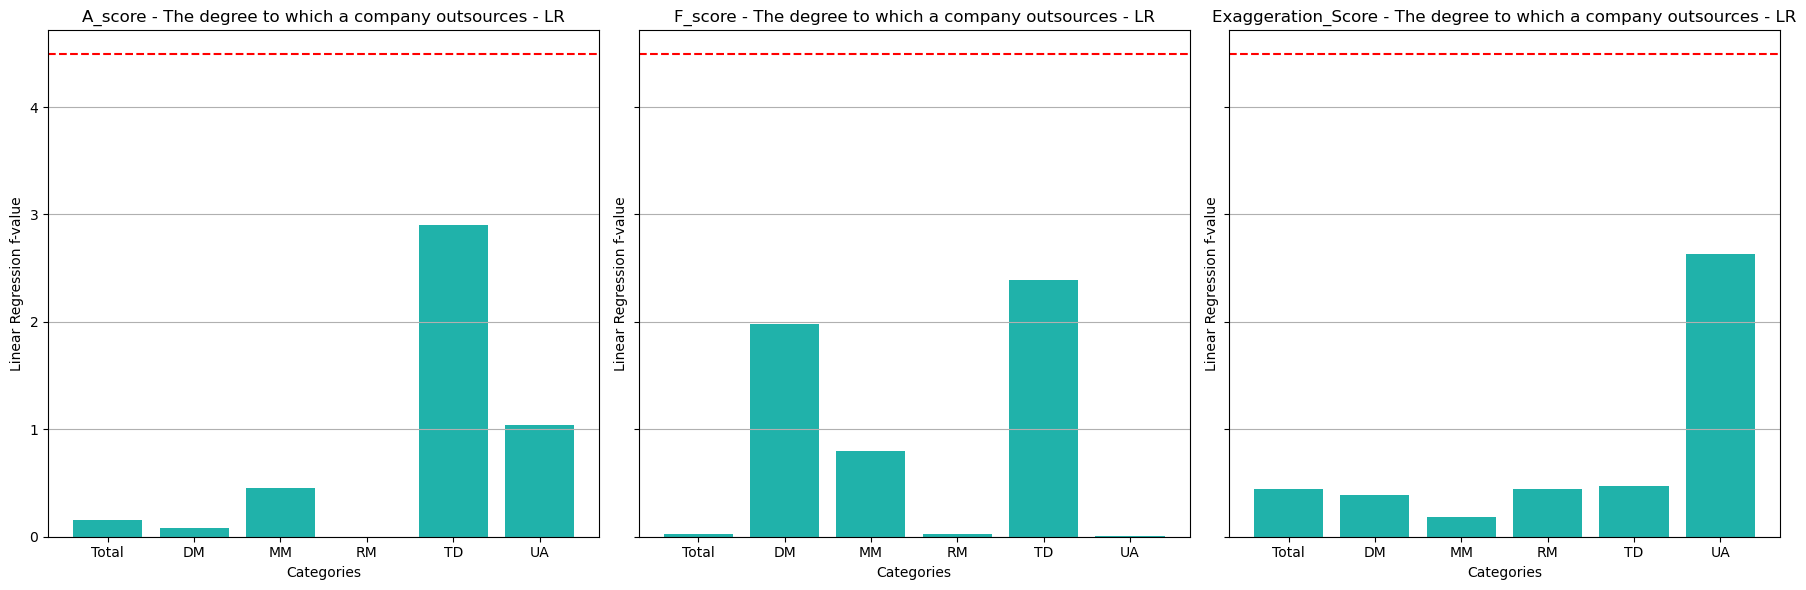

In [149]:
# Combine all F-values for the same category
combined_f_values = [
    Af0_values_Total + Af1_values_Total + Af2_values_Total + Af3_values_Total + Af4_values_Total + Af5_values_Total,
    Ff0_values_Total + Ff1_values_Total + Ff2_values_Total + Ff3_values_Total + Ff4_values_Total + Ff5_values_Total,
    Ef0_values_Total + Ef1_values_Total + Ef2_values_Total + Ef3_values_Total + Ef4_values_Total + Ef5_values_Total
]

# List of dataframes and their ANOVA p-values
dataframes = ['Total', 'DM', 'MM', 'RM', 'TD', 'UA']
custom_labels = ['A_score', 'F_score', 'Exaggeration_Score']

# Plotting the combined ANOVA p-values for each category in subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, values in enumerate(combined_f_values):
    axes[i].bar(dataframes, values, color='lightseagreen')
    axes[i].set_title(f'{custom_labels[i]} - The degree to which a company outsources - LR')
    axes[i].set_xlabel('Categories')
    axes[i].set_ylabel('Linear Regression f-value')
    axes[i].axhline(y=4.49, color='red', linestyle='--', label='Critical Value (4.49)')
    axes[i].grid(axis='y')

plt.tight_layout()
plt.show()

# MODEL <a id='section-7'></a>

In [304]:
#Defining the df used for the model
modelDf = df[['Q6', 'Q5', 'Q10', 'Q16_NPS_GROUP', 'Q23', 'Q22', 'Q9', 'Exaggeration_Score', 'A_score', 'F_score']]


modelDf['Q5'] = modelDf['Q5'].str.split(',').str[0]  # Only show the highest role of the person

# Setting Q5 Categorical
modelDf['Q5'] = pd.Categorical(modelDf['Q5'])

/var/folders/7t/z1t7x1b10798hv_p1_2rlgcc0000gn/T/ipykernel_2386/414279648.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modelDf['Q5'] = modelDf['Q5'].str.split(',').str[0]  # Only show the highest role of the person
/var/folders/7t/z1t7x1b10798hv_p1_2rlgcc0000gn/T/ipykernel_2386/414279648.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modelDf['Q5'] = pd.Categorical(modelDf['Q5'])


  Exaggeration model 
Linear mixed model fit by REML [’lmerMod’]
Formula: Exaggeration_Score~Q6+Q5+Q10+Q16_NPS_GROUP+Q23+Q22+(1|Q9)

Family: gaussian	 Inference: parametric

Number of observations: 31	 Groups: {'Q9': 8.0}

Log-likelihood: 3.340 	 AIC: 15.319

Random effects:

                 Name    Var    Std
Q9        (Intercept)  0.015  0.122
Residual               0.008  0.088

No random effect correlations specified

Fixed effects:

  A-score model 
Linear mixed model fit by REML [’lmerMod’]
Formula: A_score~Q6+Q5+Q10+Q16_NPS_GROUP+Q23+Q22+(1|Q9)

Family: gaussian	 Inference: parametric

Number of observations: 31	 Groups: {'Q9': 8.0}

Log-likelihood: 2.543 	 AIC: 16.914

Random effects:

                 Name    Var    Std
Q9        (Intercept)  0.025  0.157
Residual               0.007  0.085

No random effect correlations specified

Fixed effects:

  F-score model 
Linear mixed model fit by REML [’lmerMod’]
Formula: F_score~Q6+Q5+Q10+Q16_NPS_GROUP+Q23+Q22+(1|Q9)

Family: gauss

<Axes: xlabel='Estimate'>

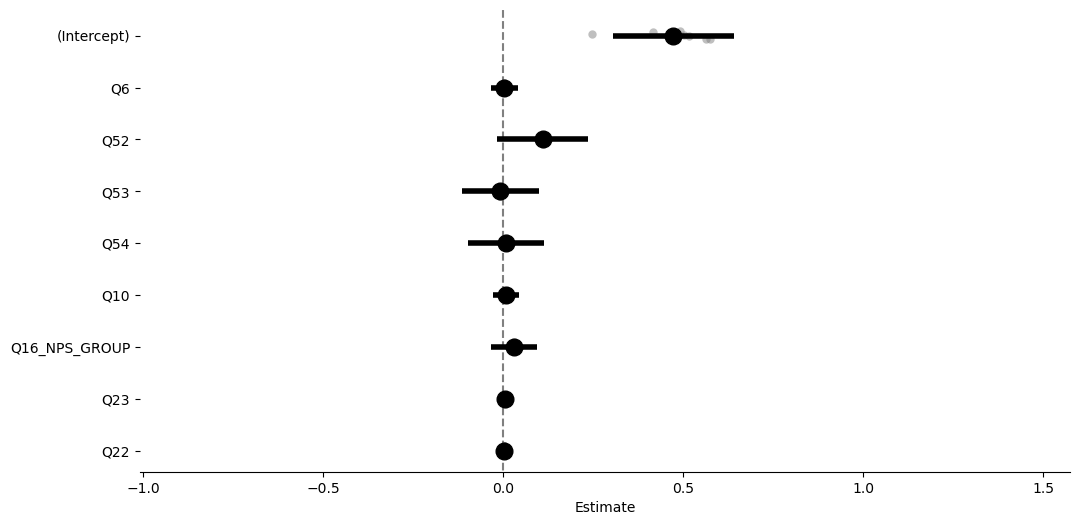

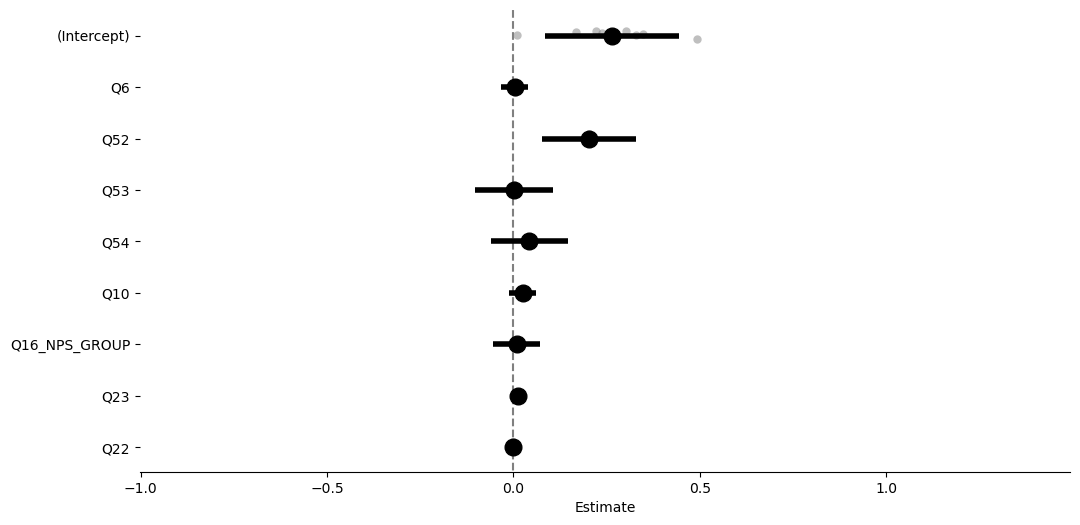

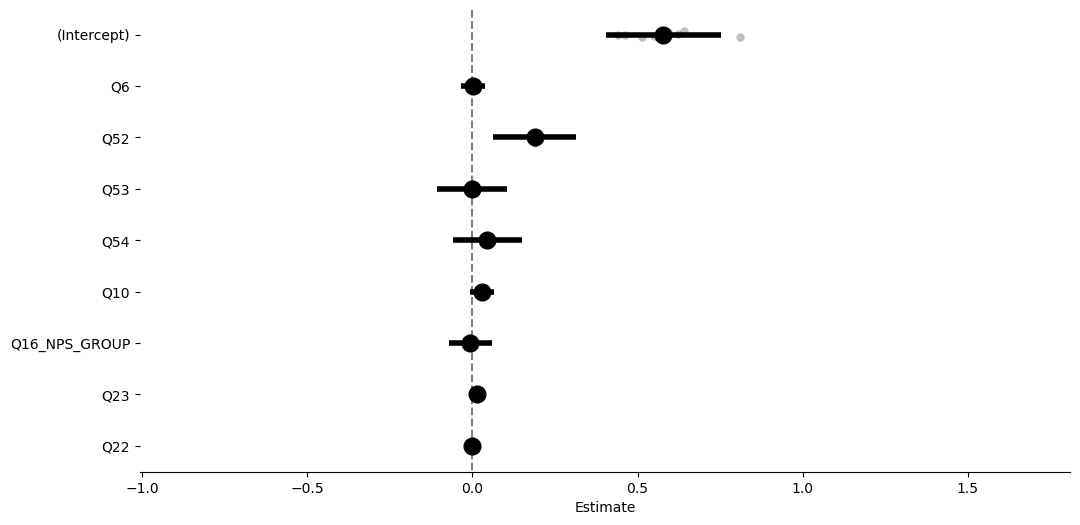

In [305]:
# Lmer model for 3 scores: Exaggeration_Score , A_score , F_score #

# The used columns are:
# # The size of a company (Q6)
# # The role of the person filling in the survey (Q5)
# # Adoption date of AI technologies (Q10)
# # Company's familiarity with the EU AI Act (Q16_NPS_GROUP)
# # The degree to which a company offshores (operates outside Europe)(Q23)
# # The degree to which a company outsources (employs others outside Europe) (Q22)
# # Q9 = industry

exModel = Lmer("Exaggeration_Score ~ Q6  + Q5 + Q10 + Q16_NPS_GROUP + Q23 + Q22 + (1|Q9)", data=modelDf)      # Model for Exaggeration_Score
aModel = Lmer("A_score ~ Q6  + Q5 + Q10 + Q16_NPS_GROUP + Q23 + Q22 + (1|Q9)", data=modelDf)                  # Model for A_score
fModel = Lmer("F_score ~ Q6  + Q5 + Q10 + Q16_NPS_GROUP + Q23 + Q22 + (1|Q9)", data=modelDf)                  # Model for F_score

# Fit all models
print('\033[1m  Exaggeration model \033[0m')
exModel.fit()

print('\033[1m  A-score model \033[0m')
aModel.fit()

print('\033[1m  F-score model \033[0m')
fModel.fit()

#Plot summaries of all models
exModel.plot_summary()
aModel.plot_summary()
fModel.plot_summary()

## Prediction model

### The used columns are:
### The size of a company (Q6)
- 1 = 1-50
- 2 = 51-200
- 3 = 201-500
- 4 = 500+

### The role of the person filling in the survey (Q5)
- 1 = Management
- 2 = Team leader
- 3 = Data scientist
- 4 = Other

### Adoption date of AI technologies (Q10)
- 1 = Less than 1 year
- 2 = 1-3 years
- 3 = 3-5 years
- 4 = Over 5 years

### Company's familiarity with the EU AI Act (Q16_NPS_GROUP)
- 3 = Promoter
- 1 = Detractor

### The degree to which a company offshores (operates outside Europe)(Q23)
- 0 to 10 scale (Inside to Outside EU)

### The degree to which a company outsources (employs others outside Europe) (Q22)
- 0 to 10 scale (Inside to Outside EU)

### Q9 = industry
- 1 = Finance
- 2 = Healthcare
- 3 = Retail
- 4 = Manufacturing
- 5 = Other

### Prediction 

In [306]:
# Dataframe with predicter variables
# Find explanation of numbers above^
prediction_data = pd.DataFrame({
    "Q6": [2],                  # The size of a company (Q6)
    "Q5": ['1'],                # The role of the person filling in the survey (Q5)
    "Q10": [1],                 # Adoption date of AI technologies (Q10)
    "Q16_NPS_GROUP": [1],       # Company's familiarity with the EU AI Act (Q16_NPS_GROUP)
    "Q23": [3],                 # The degree to which a company offshores (operates outside Europe)(Q23)
    "Q22": [1],                 # The degree to which a company outsources (employs others outside Europe) (Q22)
    "Q9": ['1']                 # Q9 = industry
})

# Predict scores
exPredictions = exModel.predict(prediction_data, skip_data_checks=True)   
aPredictions = aModel.predict(prediction_data, skip_data_checks=True)   
fPredictions = fModel.predict(prediction_data, skip_data_checks=True)   

# Print the predictions
print('''
Based on the input you've provided:
    Predicted score = ''',  exPredictions[0], '''
    A Score = ''',          aPredictions[0], '''
    F Score = ''',          fPredictions[0], ''' 
Calculated = ''', aPredictions[0]/fPredictions[0]
  )


Based on the input you've provided:
    Predicted score =  0.5252919374956707 
    A Score =  0.31122108966107137 
    F Score =  0.6078610378049277  
Calculated =  0.5119938115871594
